In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score

In [6]:
df = pd.read_csv('src\datasets\one_hot_encoded\combined-data.csv')

df.head()

Year  Temperature        Co2  Country_Albania  Country_Algeria  \
0  1970        0.248   8.952570                0                0   
1  1970        0.082   0.002168                0                0   
2  1970       -0.106   4.814516                1                0   
3  1970        0.422  19.437564                0                0   
4  1970        0.438  88.321009                0                0   

   Country_Angola  Country_Anguilla  Country_Antigua and Barbuda  \
0               1                 0                            0   
1               0                 1                            0   
2               0                 0                            0   
3               0                 0                            0   
4               0                 0                            0   

   Country_Argentina  Country_Australia  ...  Country_Uganda  \
0                  0                  0  ...               0   
1                  0                  0  ...               0   
2                  0                  0  ...               0   
3                  0                  0  ...               0   
4                  1                  0  ...               0   

   Country_United Arab Emirates  Country_United Kingdom  \
0                             0                       0   
1                             0                       0   
2                             0                       0   
3                             1                       0   
4                             0                       0   

   Country_United States  Country_Uruguay  Country_Vanuatu  Country_Vietnam  \
0                      0                0                0                0   
1                      0                0                0                0   
2                      0                0                0                0   
3                      0                0                0                0   
4                      0                0                0                0   

   Country_Western Sahara  Country_Zambia  Country_Zimbabwe  
0                       0               0                 0  
1                       0               0                 0  
2                       0               0                 0  
3                       0               0                 0  
4                       0               0                 0  

[5 rows x 135 columns]

In [7]:
avg_by_year = df.groupby('Year').mean()

X = avg_by_year[['Co2']].values
y = avg_by_year['Temperature'].values

split_index = int(len(X) * 0.8)

X_train, X_val_test = X[:split_index], X[split_index:]
y_train, y_val_test = y[:split_index], y[split_index:]


split_index_val = int(len(X_val_test) * 0.5)

X_val, X_test = X_val_test[:split_index_val], X_val_test[split_index_val:]
y_val, y_test = y_val_test[:split_index_val], y_val_test[split_index_val:]


seq_length = 3
tf.random.set_seed(42)

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_train,
    targets = y_train[seq_length:],
    sequence_length= seq_length,
    batch_size = 5,
    shuffle = True,
    seed = 42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_val,
    targets= y_val[seq_length:],
    sequence_length = seq_length,
    batch_size = 5
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_test,
    targets= y_test[seq_length:],
    sequence_length = seq_length,
    batch_size = 5
)


In [8]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=100):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(
      monitor = "val_mae", patience = 50, restore_best_weights=True)

  opt = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

  model.compile(loss = tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

  history = model.fit(train_set, validation_data = valid_set, epochs = epochs,
                                    callbacks=[early_stopping_cb])

  valid_loss, valid_mae = model.evaluate(valid_set)

  return valid_mae * 1e6

In [9]:
tf.random.set_seed(42)

deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True ),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

model = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/100
8/8 [==============================] - 4s 149ms/step - loss: 0.4882 - mae: 0.8839 - val_loss: 0.3764 - val_mae: 0.8646
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1147 - mae: 0.3961 - val_loss: 0.0057 - val_mae: 0.0778
Epoch 3/100
8/8 [==============================] - 0s 43ms/step - loss: 0.2517 - mae: 0.6072 - val_loss: 0.7278 - val_mae: 1.2278
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 0.1189 - mae: 0.3921 - val_loss: 0.1941 - val_mae: 0.6189
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0884 - mae: 0.3276 - val_loss: 0.1519 - val_mae: 0.5464
Epoch 6/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0970 - mae: 0.3644 - val_loss: 0.6193 - val_mae: 1.1193
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1418 - mae: 0.4412 - val_loss: 0.7807 - val_mae: 1.2807
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1096 - mae: 0.3

In [10]:
test_predictions = deep_model.predict(test_ds)

1/1 [==============================] - 16s 16s/step


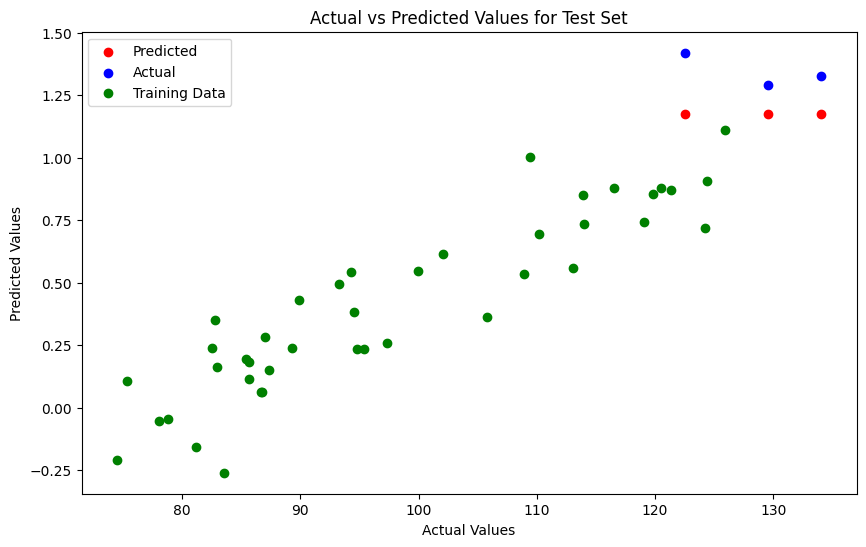

In [11]:

plt.figure(figsize=(10, 6))


plt.scatter(X_test[seq_length:], test_predictions, color='red', label='Predicted')


plt.scatter(X_test[seq_length:], y_test[seq_length:], color='blue', label='Actual')
plt.scatter(X_train, y_train, label='Training Data', color='green')

plt.title('Actual vs Predicted Values for Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

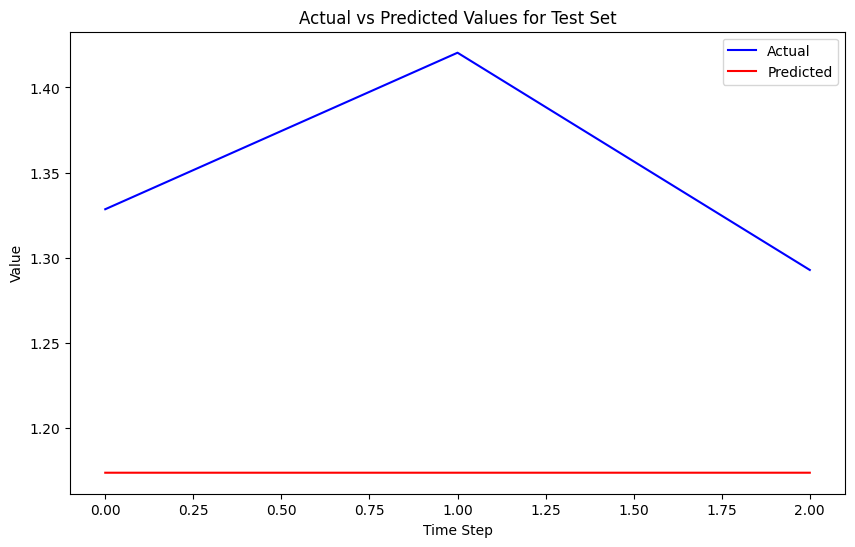

1/1 [==============================] - 0s 219ms/step - loss: 0.0165 - mae: 0.1735
Test MAE: 0.1735215187072754
Test loss: 0.016499733552336693


In [12]:

plt.figure(figsize=(10, 6))
plt.plot(y_test[seq_length:], label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Values for Test Set')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


test_loss, test_mae = deep_model.evaluate(test_ds)
print("Test MAE:", test_mae)
print("Test loss:", test_loss)


model_results = {
    "Test Loss": test_loss,
    "Test MAE": test_mae,
}

In [13]:
test_r2 = r2_score(y_test[seq_length:], test_predictions)

print("Test R^2:", test_r2)

Test R^2: -10.419989860636152


Epoch 1/100
8/8 [==============================] - 4s 74ms/step - loss: 0.3444 - mae: 0.7066 - val_loss: 1.6836 - val_mae: 2.1836
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 0.4114 - mae: 0.7683 - val_loss: 0.8938 - val_mae: 1.3938
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.2195 - mae: 0.5342 - val_loss: 0.1231 - val_mae: 0.4480
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.2573 - mae: 0.5540 - val_loss: 0.5195 - val_mae: 1.0132
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2048 - mae: 0.5335 - val_loss: 0.2708 - val_mae: 0.7000
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.3135 - mae: 0.6716 - val_loss: 0.2333 - val_mae: 0.6559
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1755 - mae: 0.4903 - val_loss: 0.8466 - val_mae: 1.3466
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 0.2922 - mae: 0.63

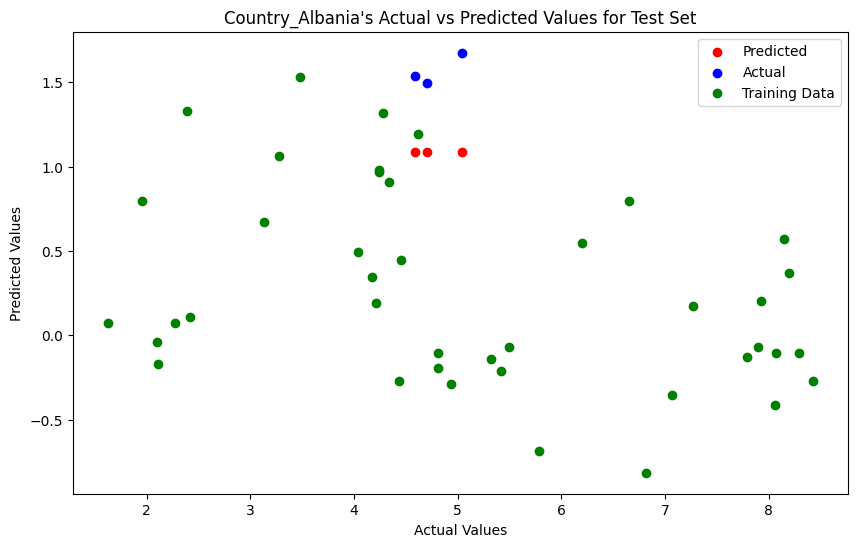

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.2360 - mae: 0.5778 - val_loss: 0.2689 - val_mae: 0.6760
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.2988 - mae: 0.6603 - val_loss: 0.0449 - val_mae: 0.2845
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3620 - mae: 0.7143 - val_loss: 0.1657 - val_mae: 0.5004
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2814 - mae: 0.6217 - val_loss: 0.6539 - val_mae: 1.1494
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.3066 - mae: 0.6397 - val_loss: 0.6182 - val_mae: 1.1107
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2342 - mae: 0.5762 - val_loss: 0.3268 - val_mae: 0.7574
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2647 - mae: 0.6172 - val_loss: 0.7672 - val_mae: 1.2671
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.4090 - mae: 0.78

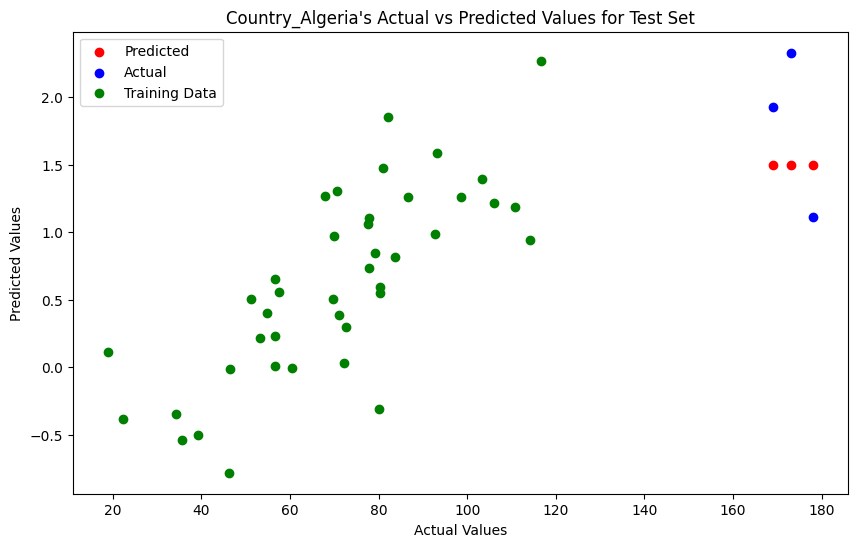

Epoch 1/100
8/8 [==============================] - 3s 74ms/step - loss: 0.2801 - mae: 0.6376 - val_loss: 0.0365 - val_mae: 0.2515
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0786 - mae: 0.3351 - val_loss: 0.0328 - val_mae: 0.2516
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1633 - mae: 0.5087 - val_loss: 0.0459 - val_mae: 0.2541
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1359 - mae: 0.4374 - val_loss: 0.0648 - val_mae: 0.2584
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1105 - mae: 0.3838 - val_loss: 0.2010 - val_mae: 0.5821
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0883 - mae: 0.3415 - val_loss: 0.2753 - val_mae: 0.6983
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0620 - mae: 0.2900 - val_loss: 0.4010 - val_mae: 0.8634
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0845 - mae: 0.33

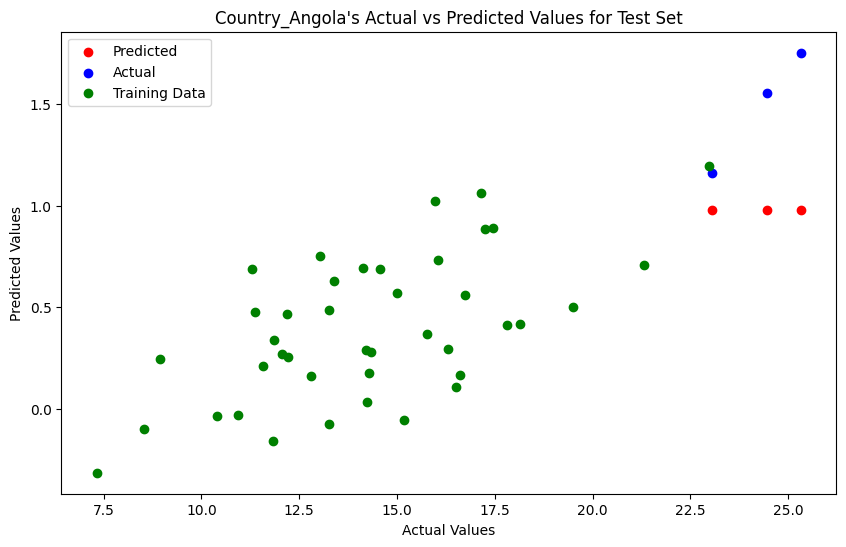

Epoch 1/100
8/8 [==============================] - 3s 82ms/step - loss: 0.0729 - mae: 0.2955 - val_loss: 0.3083 - val_mae: 0.7761
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0872 - mae: 0.3272 - val_loss: 0.1304 - val_mae: 0.4966
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0674 - mae: 0.2943 - val_loss: 0.0579 - val_mae: 0.3185
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0767 - mae: 0.3059 - val_loss: 0.1479 - val_mae: 0.5306
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0660 - mae: 0.2816 - val_loss: 0.1388 - val_mae: 0.5133
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0655 - mae: 0.2944 - val_loss: 0.0716 - val_mae: 0.3595
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0671 - mae: 0.2927 - val_loss: 0.2118 - val_mae: 0.6400
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0783 - mae: 0.31

1/1 [==============================] - 1s 1s/step


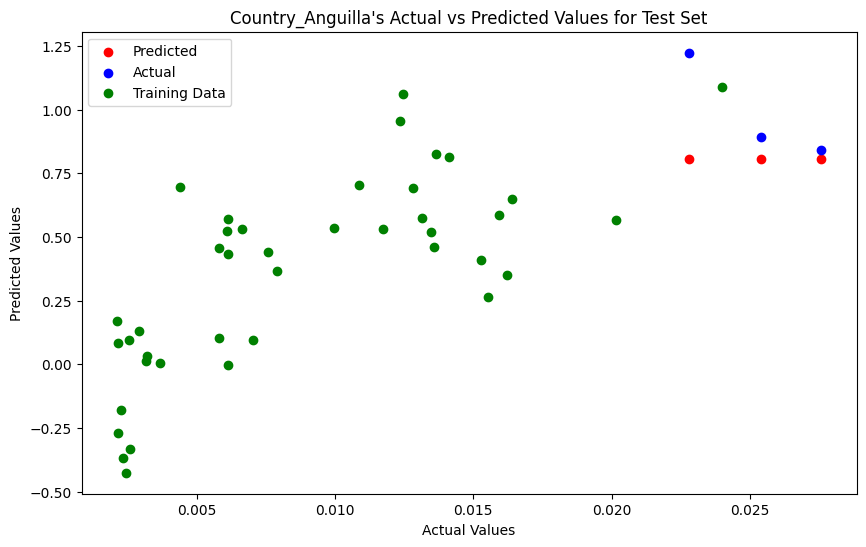

Epoch 1/100
8/8 [==============================] - 3s 75ms/step - loss: 0.0926 - mae: 0.3531 - val_loss: 0.2006 - val_mae: 0.6170
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0839 - mae: 0.3224 - val_loss: 0.0494 - val_mae: 0.2835
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0678 - mae: 0.2884 - val_loss: 0.0090 - val_mae: 0.1322
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0765 - mae: 0.2927 - val_loss: 0.0137 - val_mae: 0.1291
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0686 - mae: 0.3032 - val_loss: 0.0165 - val_mae: 0.1318
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0685 - mae: 0.2857 - val_loss: 0.0086 - val_mae: 0.1299
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0542 - mae: 0.2512 - val_loss: 0.0330 - val_mae: 0.2237
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0558 - mae: 0.24

1/1 [==============================] - 0s 377ms/step


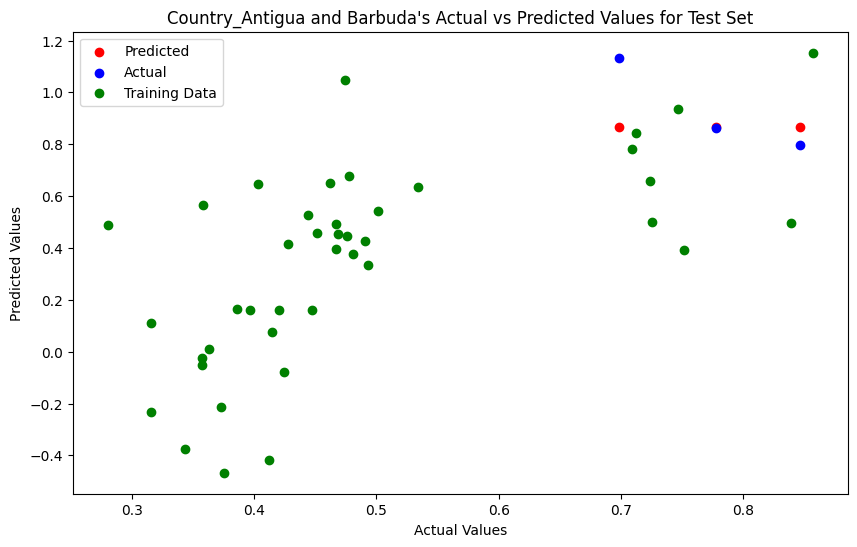

Epoch 1/100
8/8 [==============================] - 3s 78ms/step - loss: 0.1196 - mae: 0.4102 - val_loss: 0.0704 - val_mae: 0.3752
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0719 - mae: 0.3070 - val_loss: 0.0678 - val_mae: 0.3682
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0718 - mae: 0.2897 - val_loss: 0.3519 - val_mae: 0.8389
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0555 - mae: 0.2609 - val_loss: 0.3482 - val_mae: 0.8345
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0690 - mae: 0.3034 - val_loss: 0.3994 - val_mae: 0.8937
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0511 - mae: 0.2548 - val_loss: 0.0930 - val_mae: 0.4313
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0654 - mae: 0.2987 - val_loss: 0.2354 - val_mae: 0.6862
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0490 - mae: 0.24

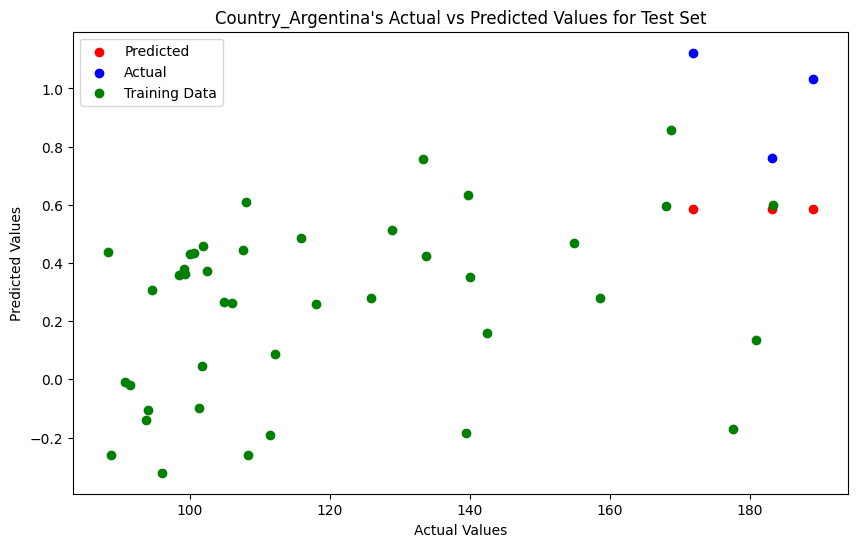

Epoch 1/100
8/8 [==============================] - 4s 120ms/step - loss: 0.0804 - mae: 0.3244 - val_loss: 0.2259 - val_mae: 0.6699
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0876 - mae: 0.3396 - val_loss: 0.2730 - val_mae: 0.7369
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0709 - mae: 0.3058 - val_loss: 0.1520 - val_mae: 0.5486
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0797 - mae: 0.3025 - val_loss: 0.2780 - val_mae: 0.7436
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0774 - mae: 0.3116 - val_loss: 0.2104 - val_mae: 0.6464
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0777 - mae: 0.3150 - val_loss: 0.2303 - val_mae: 0.6764
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0800 - mae: 0.3232 - val_loss: 0.2272 - val_mae: 0.6719
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0833 - mae: 0.3

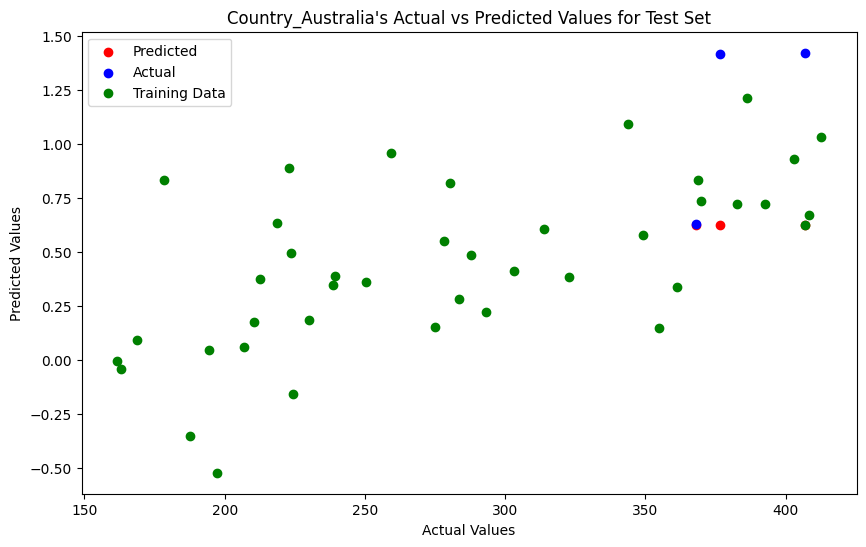

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.2503 - mae: 0.6060 - val_loss: 1.0125 - val_mae: 1.5125
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2533 - mae: 0.5947 - val_loss: 1.1061 - val_mae: 1.6061
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2439 - mae: 0.5895 - val_loss: 1.0142 - val_mae: 1.5142
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2557 - mae: 0.6093 - val_loss: 1.2160 - val_mae: 1.7160
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2869 - mae: 0.6425 - val_loss: 1.1824 - val_mae: 1.6824
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2949 - mae: 0.6331 - val_loss: 0.9493 - val_mae: 1.4493
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2448 - mae: 0.5590 - val_loss: 2.0870 - val_mae: 2.5870
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.3706 - mae: 0.71

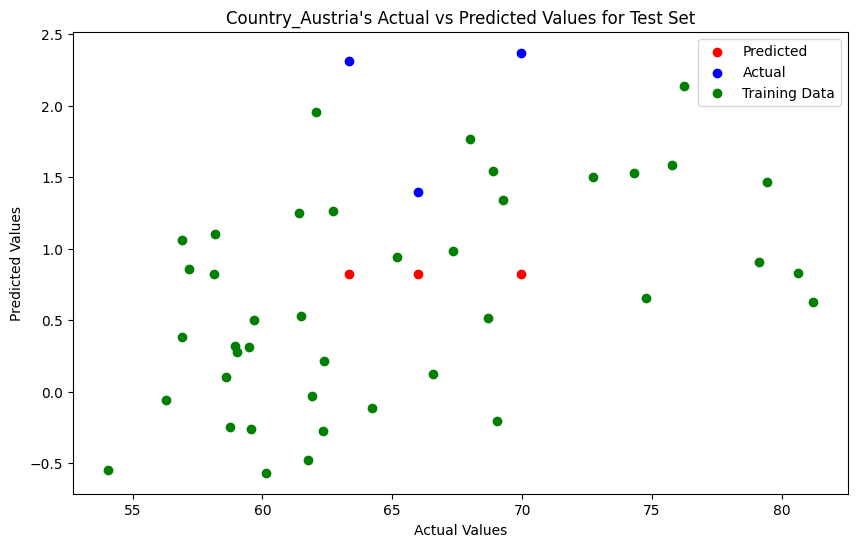

Epoch 1/100
8/8 [==============================] - 3s 75ms/step - loss: 0.1162 - mae: 0.4096 - val_loss: 0.0784 - val_mae: 0.3827
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0685 - mae: 0.2956 - val_loss: 0.1630 - val_mae: 0.5622
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0602 - mae: 0.2703 - val_loss: 0.3475 - val_mae: 0.8263
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0508 - mae: 0.2694 - val_loss: 0.2104 - val_mae: 0.6428
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0430 - mae: 0.2438 - val_loss: 0.4771 - val_mae: 0.9729
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0477 - mae: 0.2524 - val_loss: 0.1892 - val_mae: 0.6103
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0500 - mae: 0.2723 - val_loss: 0.2503 - val_mae: 0.7034
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0414 - mae: 0.24

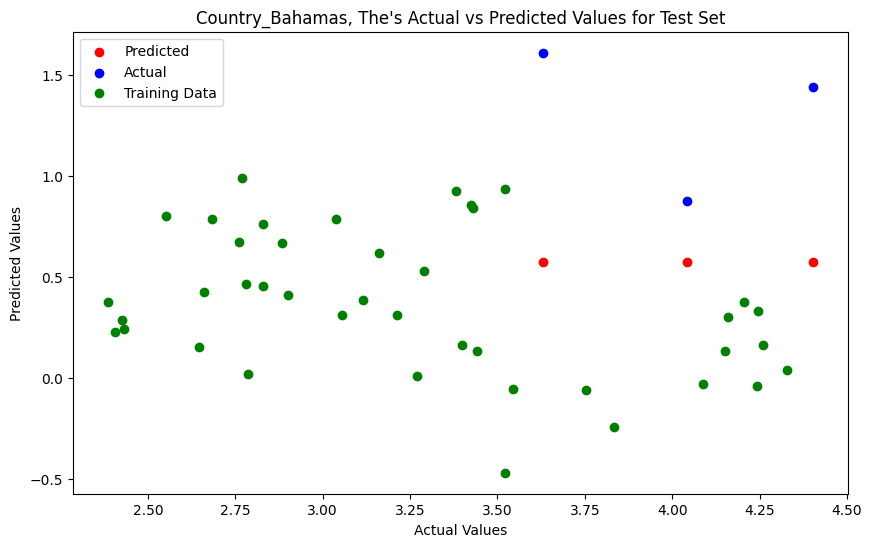

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.0946 - mae: 0.3487 - val_loss: 0.2362 - val_mae: 0.6767
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0684 - mae: 0.2954 - val_loss: 0.0711 - val_mae: 0.3576
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0667 - mae: 0.2961 - val_loss: 0.0562 - val_mae: 0.3130
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0667 - mae: 0.2942 - val_loss: 0.1810 - val_mae: 0.5896
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0536 - mae: 0.2570 - val_loss: 0.0344 - val_mae: 0.2332
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0570 - mae: 0.2615 - val_loss: 0.0935 - val_mae: 0.4155
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0469 - mae: 0.2472 - val_loss: 0.0733 - val_mae: 0.3636
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0528 - mae: 0.24

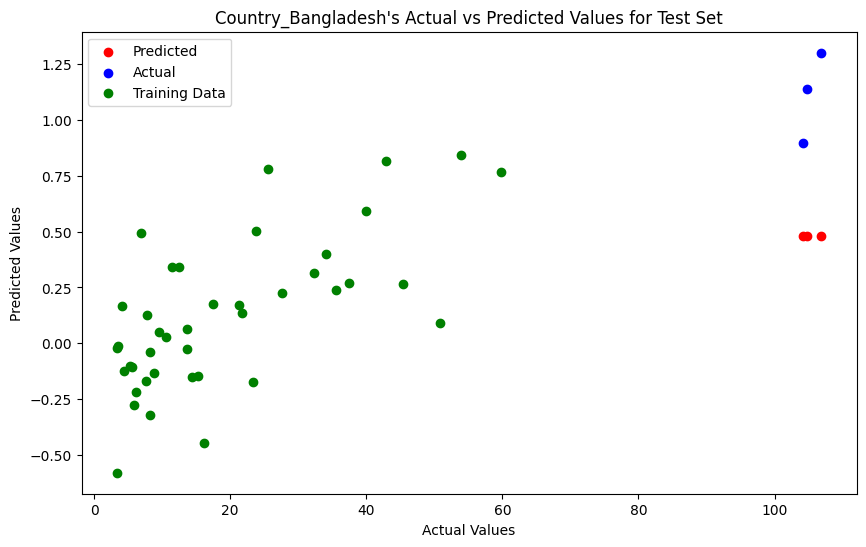

Epoch 1/100
8/8 [==============================] - 3s 74ms/step - loss: 0.1201 - mae: 0.4056 - val_loss: 0.0701 - val_mae: 0.2962
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0630 - mae: 0.2558 - val_loss: 0.0535 - val_mae: 0.2437
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0669 - mae: 0.3042 - val_loss: 0.0711 - val_mae: 0.2838
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0502 - mae: 0.2499 - val_loss: 0.0310 - val_mae: 0.2434
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0485 - mae: 0.2594 - val_loss: 0.0309 - val_mae: 0.2408
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0664 - mae: 0.2780 - val_loss: 0.0687 - val_mae: 0.2885
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1003 - mae: 0.3495 - val_loss: 0.0428 - val_mae: 0.2305
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0749 - mae: 0.33

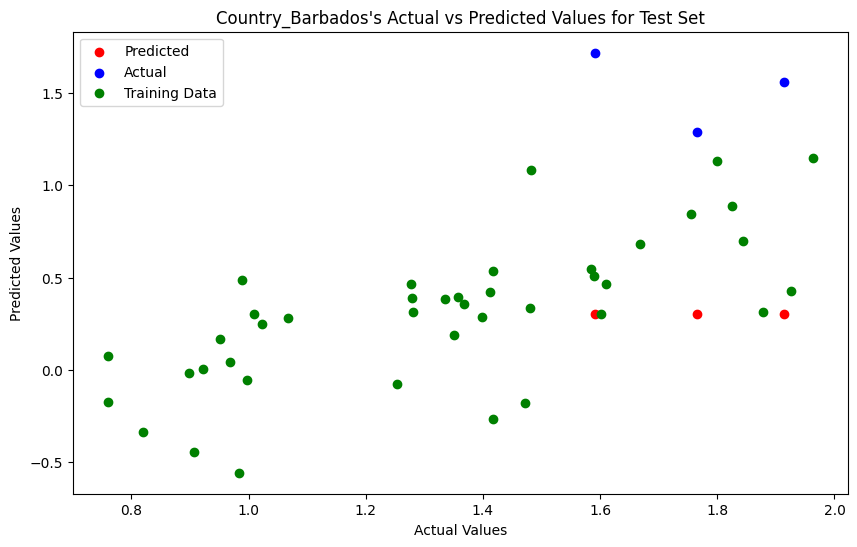

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.0713 - mae: 0.2965 - val_loss: 0.0782 - val_mae: 0.3897
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0544 - mae: 0.2717 - val_loss: 0.0847 - val_mae: 0.3768
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0382 - mae: 0.2183 - val_loss: 0.0829 - val_mae: 0.3799
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0527 - mae: 0.2762 - val_loss: 0.0746 - val_mae: 0.3855
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0761 - mae: 0.3189 - val_loss: 0.3214 - val_mae: 0.7062
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0614 - mae: 0.2708 - val_loss: 0.1242 - val_mae: 0.3957
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0487 - mae: 0.2482 - val_loss: 0.0943 - val_mae: 0.4004
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0438 - mae: 0.24

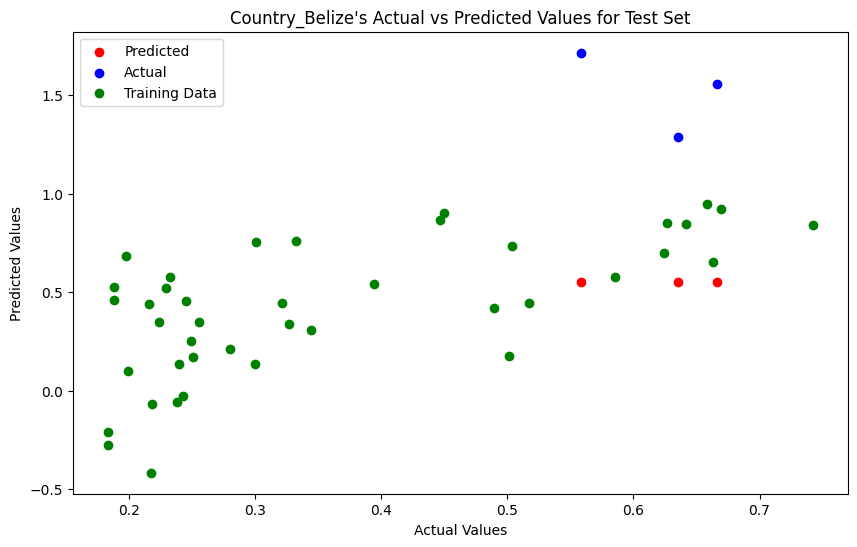

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.0517 - mae: 0.2622 - val_loss: 0.0076 - val_mae: 0.1086
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0643 - mae: 0.2910 - val_loss: 0.0226 - val_mae: 0.1978
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0431 - mae: 0.2284 - val_loss: 0.0039 - val_mae: 0.0800
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0423 - mae: 0.2327 - val_loss: 0.0040 - val_mae: 0.0831
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0390 - mae: 0.2365 - val_loss: 0.0097 - val_mae: 0.1169
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0376 - mae: 0.2240 - val_loss: 0.0060 - val_mae: 0.0801
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0351 - mae: 0.2075 - val_loss: 0.0042 - val_mae: 0.0807
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0404 - mae: 0.22

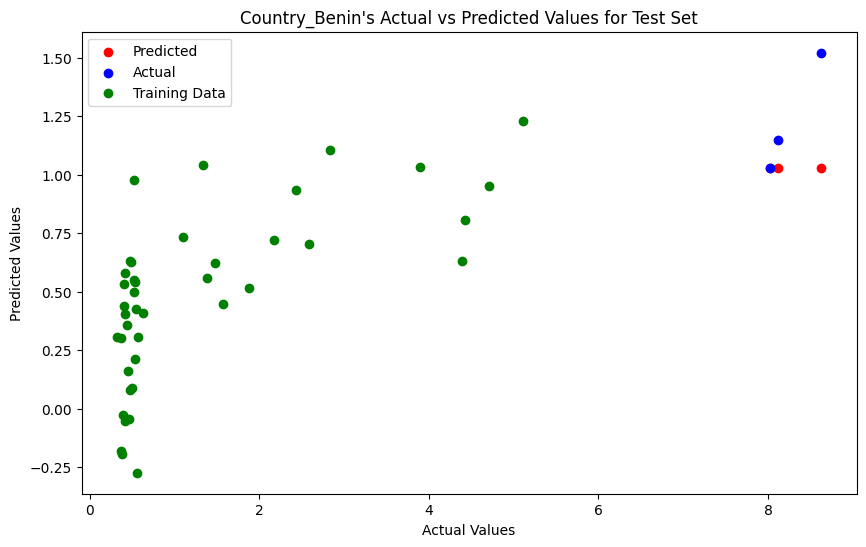

Epoch 1/100
8/8 [==============================] - 3s 74ms/step - loss: 0.1077 - mae: 0.3505 - val_loss: 0.0110 - val_mae: 0.1095
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1052 - mae: 0.3862 - val_loss: 0.0755 - val_mae: 0.3732
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0648 - mae: 0.2921 - val_loss: 0.0109 - val_mae: 0.1070
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0542 - mae: 0.2743 - val_loss: 0.0498 - val_mae: 0.2986
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0660 - mae: 0.3076 - val_loss: 0.0647 - val_mae: 0.3450
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0701 - mae: 0.3158 - val_loss: 0.0638 - val_mae: 0.3419
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0685 - mae: 0.3036 - val_loss: 0.0062 - val_mae: 0.1042
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0475 - mae: 0.25

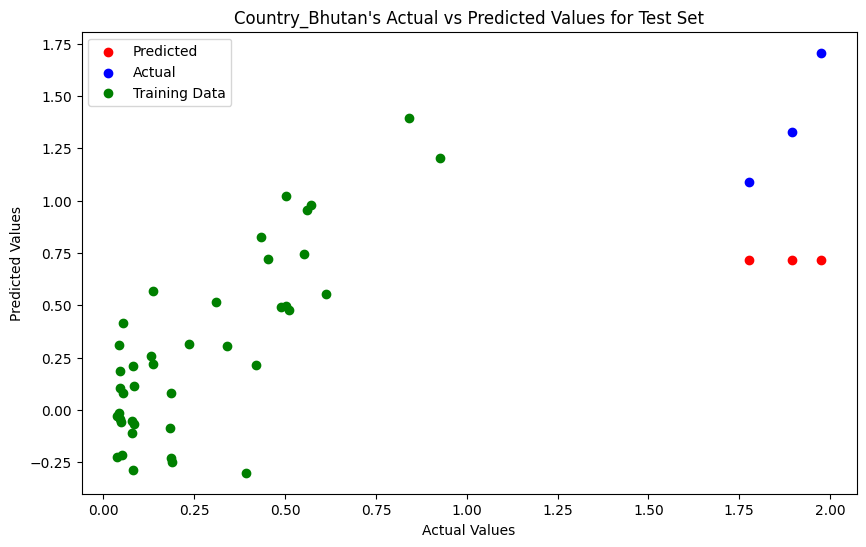

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.0911 - mae: 0.3606 - val_loss: 0.2633 - val_mae: 0.6660
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0645 - mae: 0.2829 - val_loss: 0.2116 - val_mae: 0.5841
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0348 - mae: 0.2152 - val_loss: 0.3428 - val_mae: 0.7761
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0350 - mae: 0.2057 - val_loss: 0.1696 - val_mae: 0.5053
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0297 - mae: 0.1920 - val_loss: 0.2049 - val_mae: 0.5730
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0270 - mae: 0.1935 - val_loss: 0.2132 - val_mae: 0.5861
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0278 - mae: 0.1852 - val_loss: 0.1600 - val_mae: 0.4874
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0291 - mae: 0.19

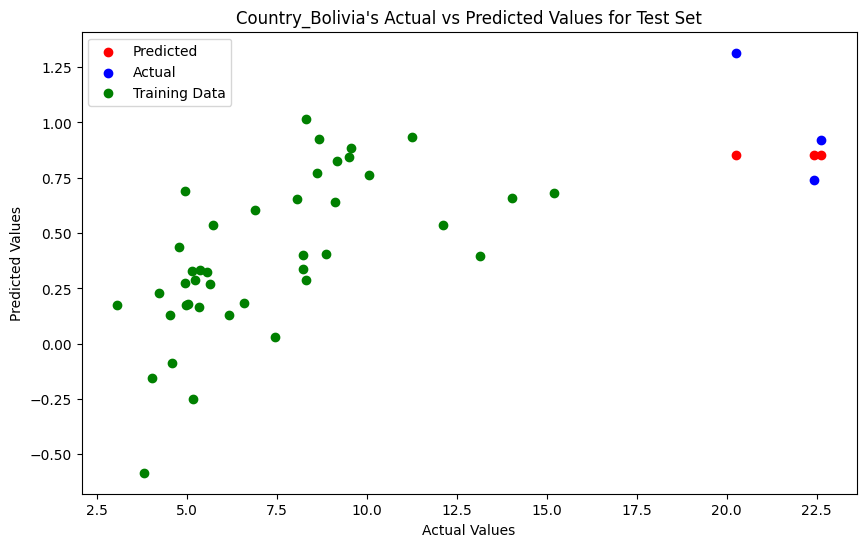

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.2027 - mae: 0.5444 - val_loss: 0.3391 - val_mae: 0.7159
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1663 - mae: 0.4988 - val_loss: 0.4246 - val_mae: 0.7624
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1449 - mae: 0.4411 - val_loss: 0.4151 - val_mae: 0.8521
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1700 - mae: 0.4633 - val_loss: 0.5020 - val_mae: 0.8386
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 0.1310 - mae: 0.4139 - val_loss: 0.4203 - val_mae: 0.8302
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1328 - mae: 0.4391 - val_loss: 0.5110 - val_mae: 0.7741
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1599 - mae: 0.4617 - val_loss: 0.3583 - val_mae: 0.8253
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1511 - mae: 0.45

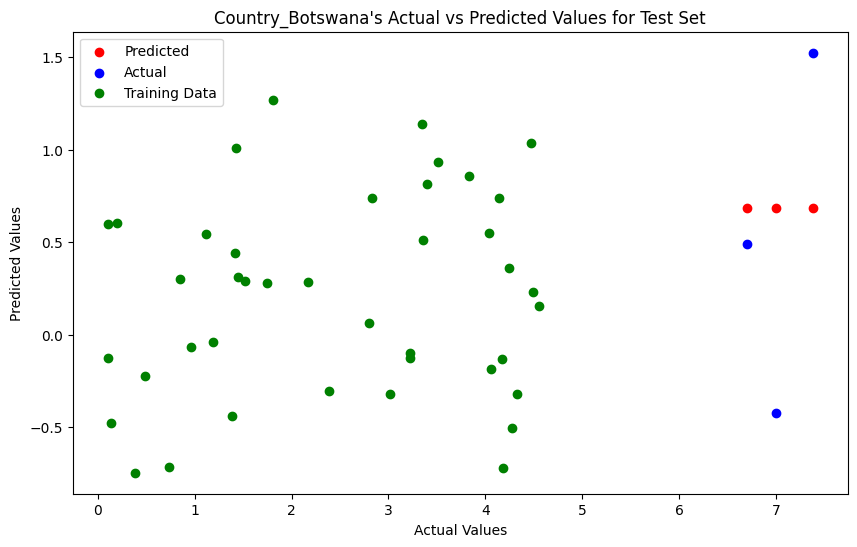

Epoch 1/100
8/8 [==============================] - 4s 79ms/step - loss: 0.0760 - mae: 0.3168 - val_loss: 0.3411 - val_mae: 0.8057
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0855 - mae: 0.3416 - val_loss: 0.4010 - val_mae: 0.8779
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0710 - mae: 0.3119 - val_loss: 0.3472 - val_mae: 0.8133
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0700 - mae: 0.2948 - val_loss: 0.3476 - val_mae: 0.8138
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0701 - mae: 0.3045 - val_loss: 0.4157 - val_mae: 0.8952
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0742 - mae: 0.3164 - val_loss: 0.3270 - val_mae: 0.7881
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0686 - mae: 0.3019 - val_loss: 0.4076 - val_mae: 0.8857
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0762 - mae: 0.31

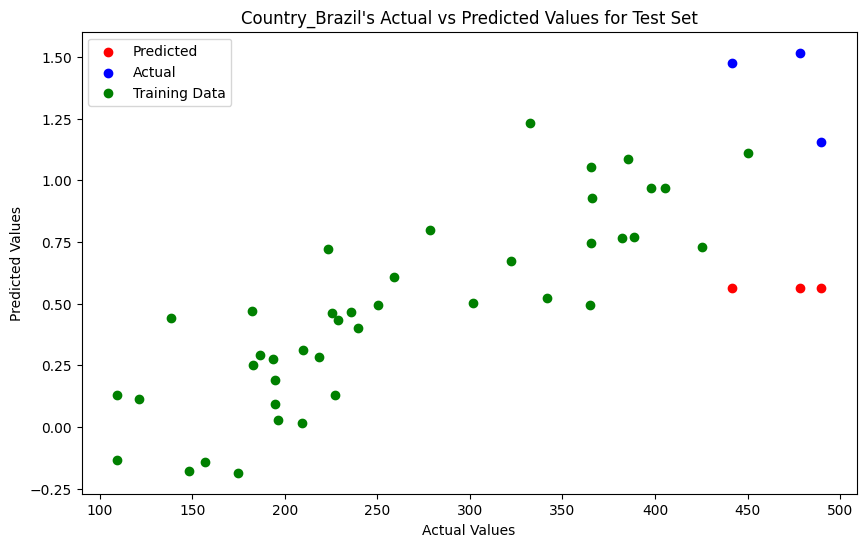

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.0686 - mae: 0.3026 - val_loss: 0.1392 - val_mae: 0.5193
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0584 - mae: 0.2874 - val_loss: 0.0171 - val_mae: 0.1600
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0506 - mae: 0.2550 - val_loss: 0.0077 - val_mae: 0.0932
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0481 - mae: 0.2566 - val_loss: 0.0089 - val_mae: 0.0954
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0495 - mae: 0.2471 - val_loss: 0.0244 - val_mae: 0.2002
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0458 - mae: 0.2514 - val_loss: 0.0318 - val_mae: 0.2343
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0746 - mae: 0.3057 - val_loss: 0.0850 - val_mae: 0.4016
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0747 - mae: 0.31

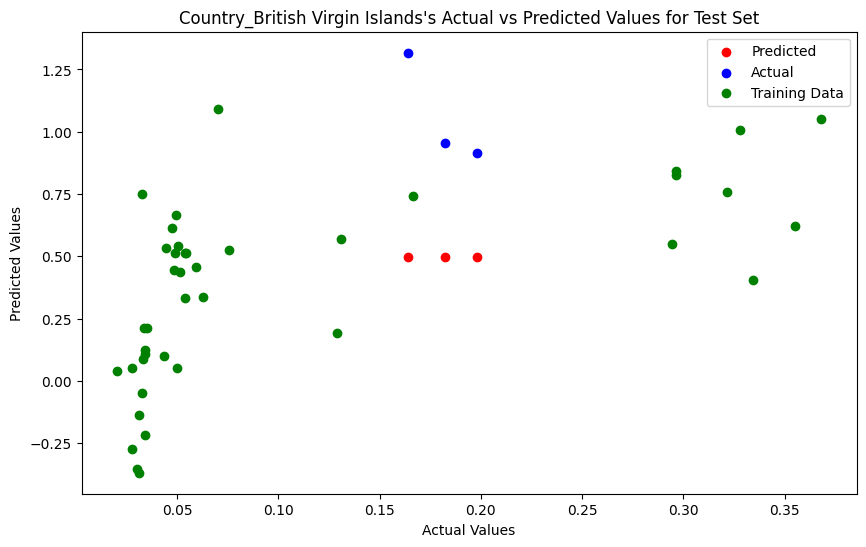

Epoch 1/100
8/8 [==============================] - 3s 75ms/step - loss: 0.2434 - mae: 0.5869 - val_loss: 0.5229 - val_mae: 1.0204
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2319 - mae: 0.5604 - val_loss: 0.5464 - val_mae: 1.0449
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.2343 - mae: 0.5589 - val_loss: 0.4566 - val_mae: 0.9492
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2821 - mae: 0.6381 - val_loss: 0.5660 - val_mae: 1.0653
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2842 - mae: 0.6138 - val_loss: 0.4391 - val_mae: 0.9299
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2495 - mae: 0.5833 - val_loss: 0.5007 - val_mae: 0.9969
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2522 - mae: 0.5933 - val_loss: 0.6710 - val_mae: 1.1710
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2861 - mae: 0.63

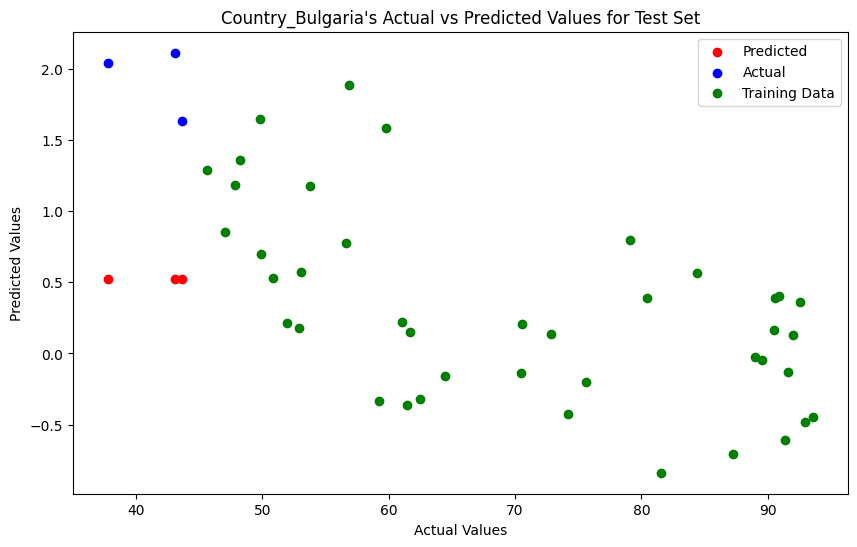

Epoch 1/100
8/8 [==============================] - 3s 108ms/step - loss: 0.0751 - mae: 0.3147 - val_loss: 0.0198 - val_mae: 0.1618
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1006 - mae: 0.3706 - val_loss: 0.0078 - val_mae: 0.1089
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0668 - mae: 0.2957 - val_loss: 0.0213 - val_mae: 0.1763
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0593 - mae: 0.2809 - val_loss: 0.0076 - val_mae: 0.1081
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0633 - mae: 0.2828 - val_loss: 0.0068 - val_mae: 0.1042
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0563 - mae: 0.2712 - val_loss: 0.0078 - val_mae: 0.0982
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0663 - mae: 0.2926 - val_loss: 0.0064 - val_mae: 0.1100
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0726 - mae: 0.3

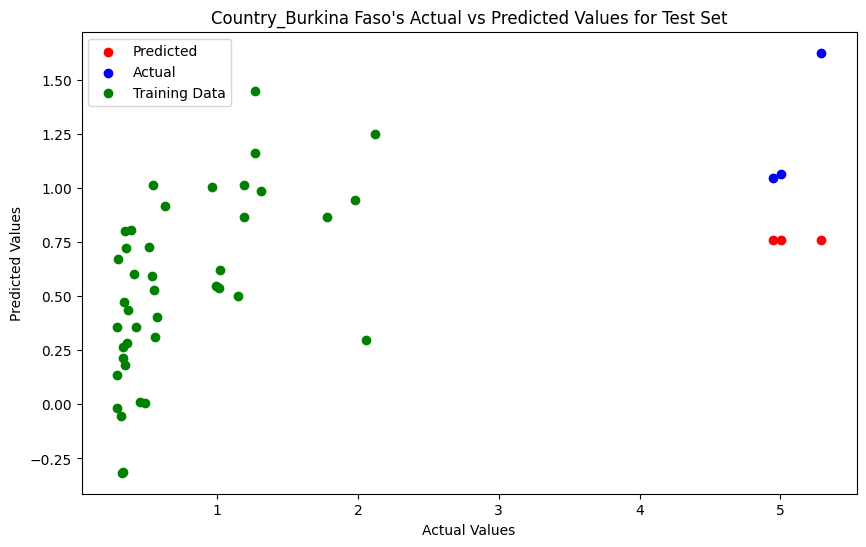

Epoch 1/100
8/8 [==============================] - 3s 75ms/step - loss: 0.2392 - mae: 0.6154 - val_loss: 8.5567e-05 - val_mae: 0.0122
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1250 - mae: 0.3972 - val_loss: 0.0850 - val_mae: 0.4119
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0994 - mae: 0.3547 - val_loss: 0.0086 - val_mae: 0.1295
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1227 - mae: 0.4182 - val_loss: 0.0145 - val_mae: 0.1700
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1261 - mae: 0.3956 - val_loss: 0.0039 - val_mae: 0.0877
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2309 - mae: 0.5492 - val_loss: 8.7534e-05 - val_mae: 0.0131
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.2132 - mae: 0.5322 - val_loss: 0.0051 - val_mae: 0.0981
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2130 - m

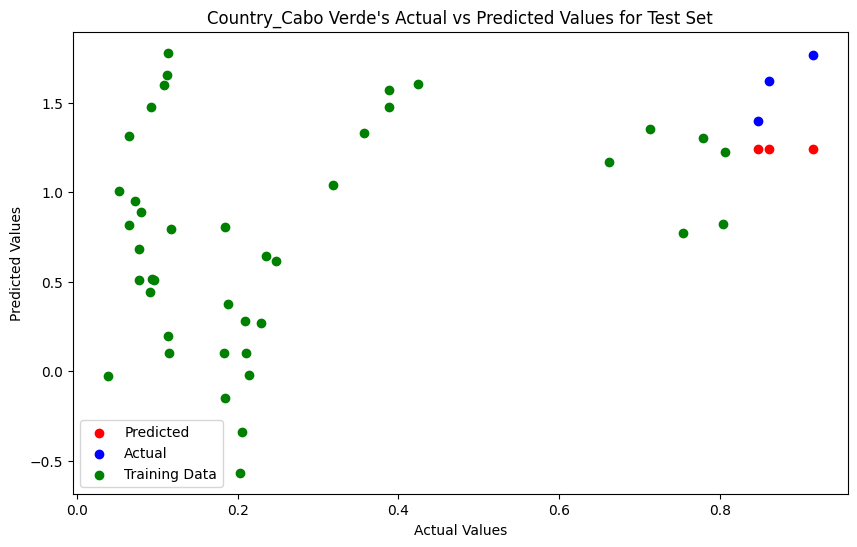

Epoch 1/100
8/8 [==============================] - 3s 74ms/step - loss: 0.0936 - mae: 0.3444 - val_loss: 0.0287 - val_mae: 0.2121
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0793 - mae: 0.3193 - val_loss: 0.0293 - val_mae: 0.1976
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0625 - mae: 0.2843 - val_loss: 0.0273 - val_mae: 0.1997
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0372 - mae: 0.2040 - val_loss: 0.0194 - val_mae: 0.1968
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0385 - mae: 0.2096 - val_loss: 0.0203 - val_mae: 0.2017
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0378 - mae: 0.2185 - val_loss: 0.0219 - val_mae: 0.2094
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0435 - mae: 0.2246 - val_loss: 0.0598 - val_mae: 0.2716
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0434 - mae: 0.21

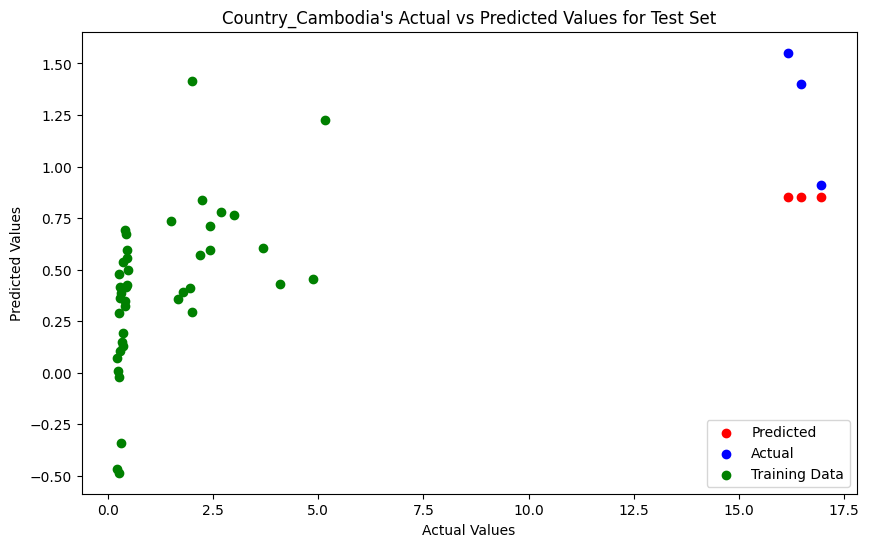

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.1091 - mae: 0.4033 - val_loss: 0.0979 - val_mae: 0.4203
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1069 - mae: 0.3741 - val_loss: 0.2085 - val_mae: 0.6306
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0478 - mae: 0.2449 - val_loss: 0.0592 - val_mae: 0.3147
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0381 - mae: 0.2366 - val_loss: 0.0561 - val_mae: 0.3052
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0531 - mae: 0.2671 - val_loss: 0.0259 - val_mae: 0.1825
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0838 - mae: 0.3271 - val_loss: 0.0417 - val_mae: 0.2526
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0574 - mae: 0.2736 - val_loss: 0.0580 - val_mae: 0.3088
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0463 - mae: 0.25

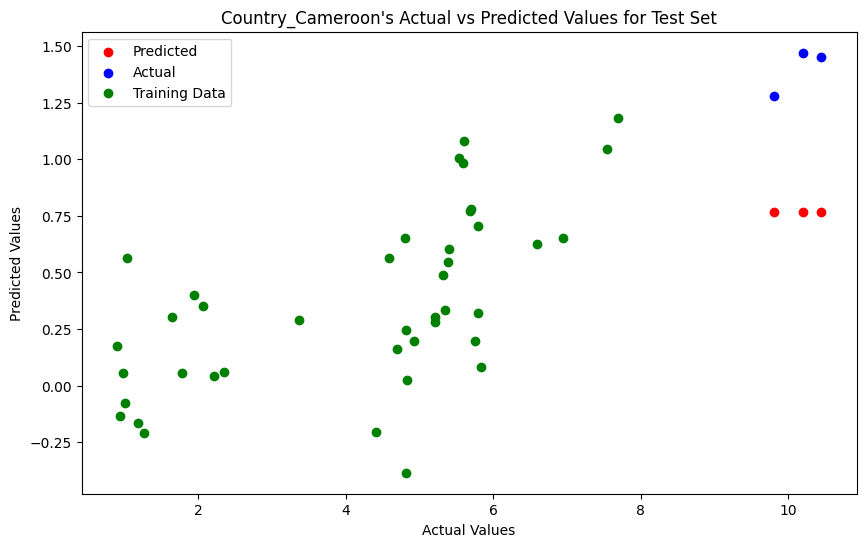

Epoch 1/100
8/8 [==============================] - 4s 81ms/step - loss: 0.3306 - mae: 0.6915 - val_loss: 0.1158 - val_mae: 0.4715
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3501 - mae: 0.7188 - val_loss: 0.1483 - val_mae: 0.4715
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3043 - mae: 0.6582 - val_loss: 0.1155 - val_mae: 0.4715
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.3387 - mae: 0.7278 - val_loss: 0.1297 - val_mae: 0.4715
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.3445 - mae: 0.6809 - val_loss: 0.1243 - val_mae: 0.4715
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.3263 - mae: 0.6991 - val_loss: 0.1119 - val_mae: 0.4715
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3144 - mae: 0.6713 - val_loss: 0.1646 - val_mae: 0.4715
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3477 - mae: 0.71

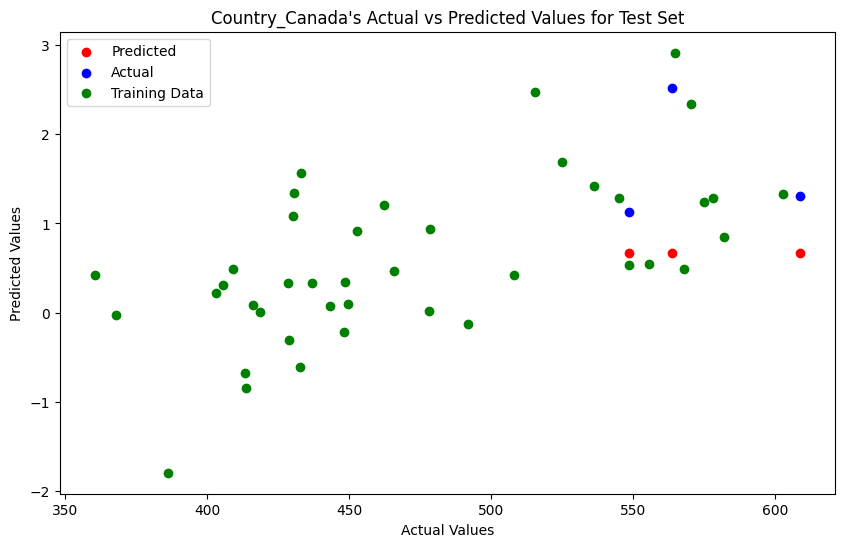

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.0592 - mae: 0.2895 - val_loss: 0.0581 - val_mae: 0.3142
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0520 - mae: 0.2532 - val_loss: 0.3256 - val_mae: 0.7972
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0648 - mae: 0.3040 - val_loss: 0.1596 - val_mae: 0.5502
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0494 - mae: 0.2467 - val_loss: 0.0591 - val_mae: 0.3199
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0631 - mae: 0.2794 - val_loss: 0.1743 - val_mae: 0.5775
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0487 - mae: 0.2519 - val_loss: 0.0396 - val_mae: 0.2507
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0455 - mae: 0.2451 - val_loss: 0.1256 - val_mae: 0.4855
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0508 - mae: 0.25

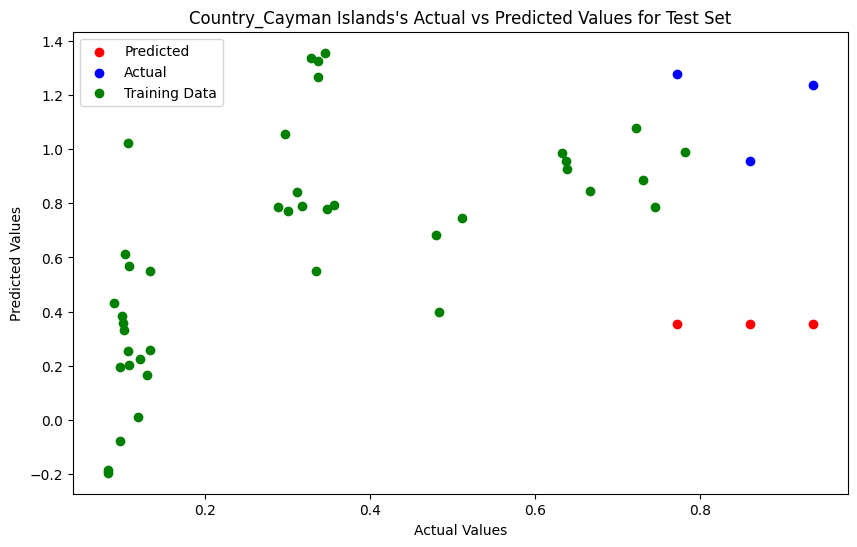

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.0404 - mae: 0.2156 - val_loss: 0.1476 - val_mae: 0.5078
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0488 - mae: 0.2347 - val_loss: 0.1913 - val_mae: 0.5888
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0402 - mae: 0.2197 - val_loss: 0.0739 - val_mae: 0.3273
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0377 - mae: 0.2127 - val_loss: 0.1140 - val_mae: 0.4390
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0347 - mae: 0.1902 - val_loss: 0.0828 - val_mae: 0.3679
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0318 - mae: 0.1855 - val_loss: 0.0948 - val_mae: 0.4039
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0327 - mae: 0.1878 - val_loss: 0.0859 - val_mae: 0.3802
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0338 - mae: 0.19

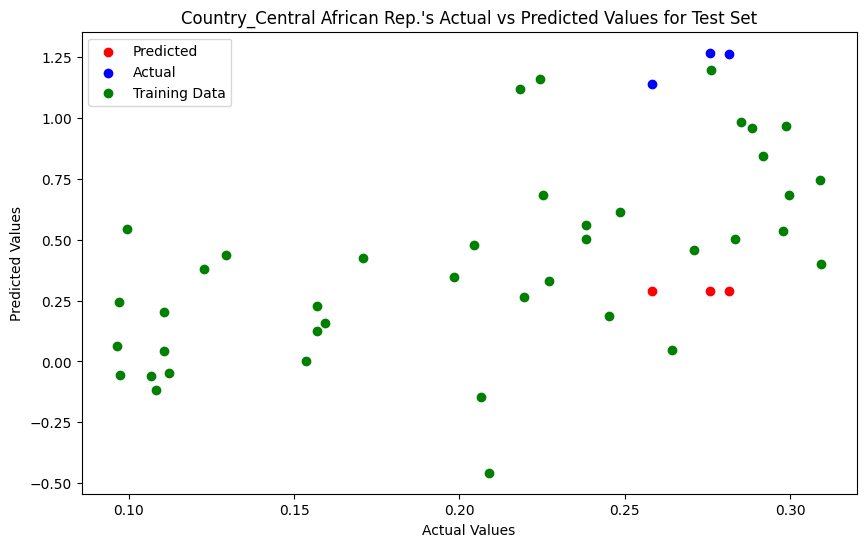

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.1037 - mae: 0.3805 - val_loss: 0.1625 - val_mae: 0.5246
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0661 - mae: 0.3052 - val_loss: 0.0410 - val_mae: 0.2288
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0525 - mae: 0.2666 - val_loss: 0.0271 - val_mae: 0.2265
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0627 - mae: 0.2874 - val_loss: 0.0265 - val_mae: 0.2250
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0516 - mae: 0.2796 - val_loss: 0.0277 - val_mae: 0.2268
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0706 - mae: 0.3154 - val_loss: 0.0435 - val_mae: 0.2395
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0637 - mae: 0.3147 - val_loss: 0.0217 - val_mae: 0.2061
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0562 - mae: 0.28

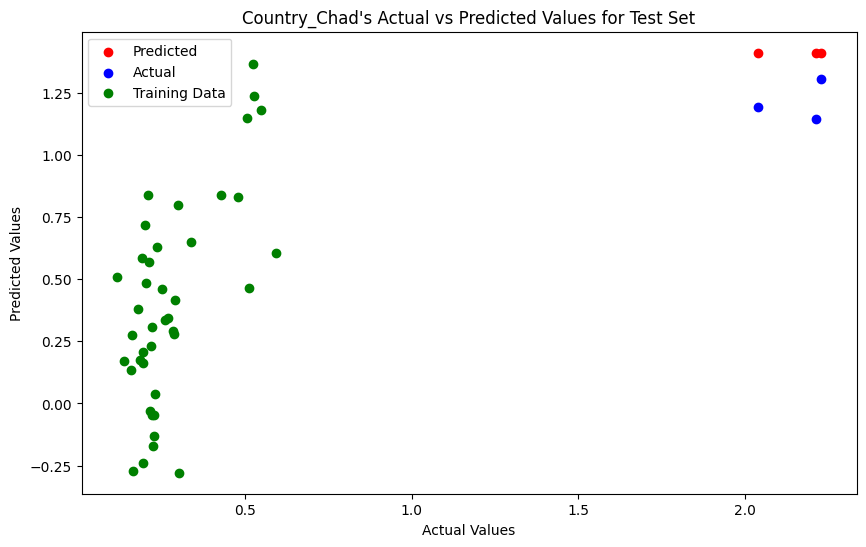

Epoch 1/100
8/8 [==============================] - 3s 78ms/step - loss: 0.2047 - mae: 0.5228 - val_loss: 0.0522 - val_mae: 0.2682
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0626 - mae: 0.2964 - val_loss: 0.0430 - val_mae: 0.2316
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0511 - mae: 0.2596 - val_loss: 0.1475 - val_mae: 0.5125
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0499 - mae: 0.2460 - val_loss: 0.2273 - val_mae: 0.6497
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0573 - mae: 0.2634 - val_loss: 0.2957 - val_mae: 0.7476
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0565 - mae: 0.2655 - val_loss: 0.0956 - val_mae: 0.3986
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0427 - mae: 0.2506 - val_loss: 0.1018 - val_mae: 0.4139
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0398 - mae: 0.23

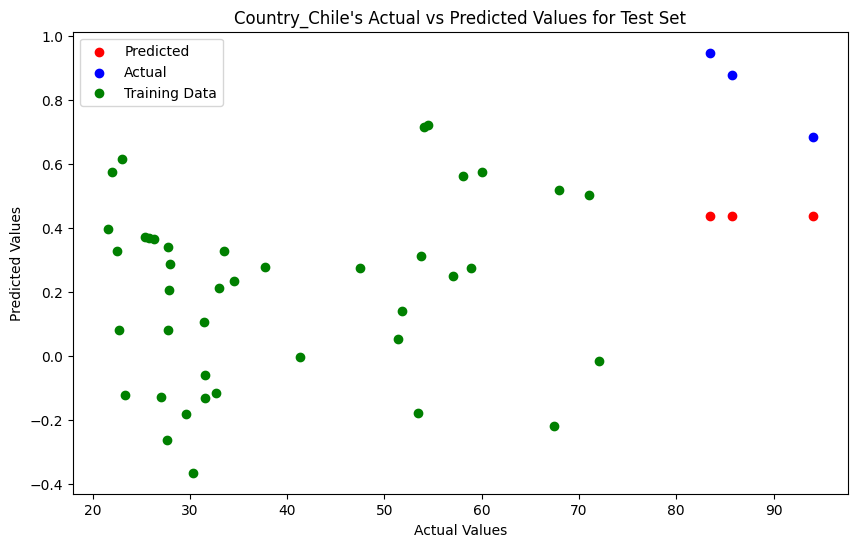

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.0606 - mae: 0.2870 - val_loss: 0.3218 - val_mae: 0.7776
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0777 - mae: 0.3252 - val_loss: 0.2562 - val_mae: 0.6880
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0689 - mae: 0.3084 - val_loss: 0.2089 - val_mae: 0.6154
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0758 - mae: 0.3336 - val_loss: 0.3234 - val_mae: 0.7797
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0658 - mae: 0.2907 - val_loss: 0.4299 - val_mae: 0.9091
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0686 - mae: 0.3159 - val_loss: 0.2636 - val_mae: 0.6987
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0600 - mae: 0.2885 - val_loss: 0.3782 - val_mae: 0.8476
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0754 - mae: 0.33

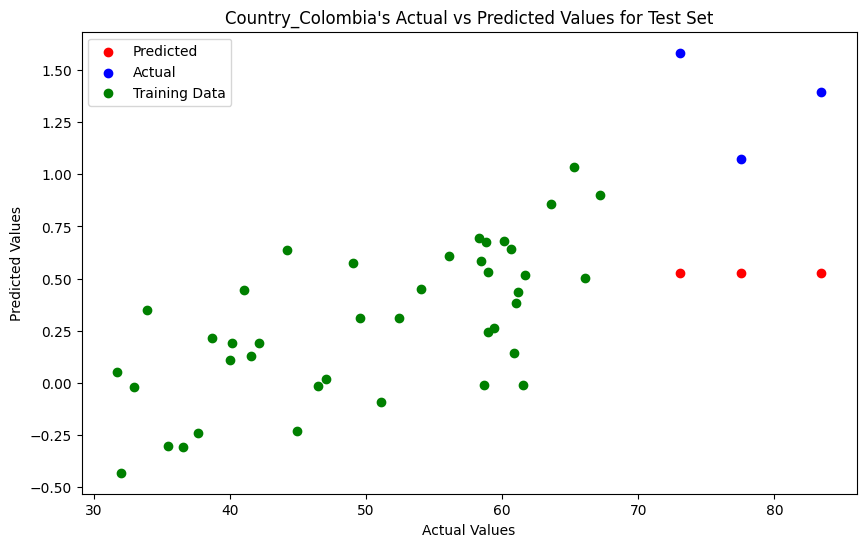

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.0736 - mae: 0.3275 - val_loss: 0.0488 - val_mae: 0.2942
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0336 - mae: 0.2089 - val_loss: 0.1247 - val_mae: 0.4033
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0325 - mae: 0.2139 - val_loss: 0.1396 - val_mae: 0.4389
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0313 - mae: 0.1980 - val_loss: 0.0639 - val_mae: 0.2946
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0257 - mae: 0.1870 - val_loss: 0.1232 - val_mae: 0.3997
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0275 - mae: 0.1846 - val_loss: 0.0898 - val_mae: 0.3046
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0237 - mae: 0.1790 - val_loss: 0.0975 - val_mae: 0.3289
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0270 - mae: 0.18

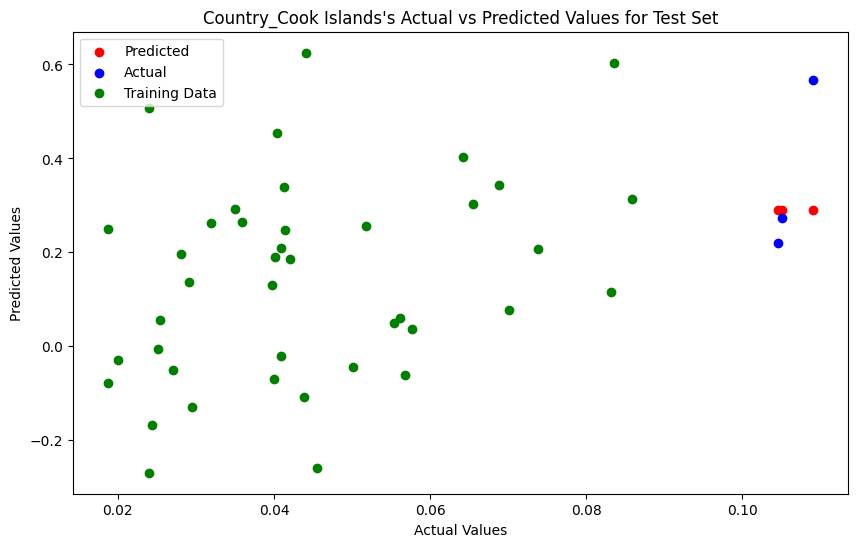

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.0865 - mae: 0.3223 - val_loss: 0.1425 - val_mae: 0.5130
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0665 - mae: 0.3111 - val_loss: 0.3319 - val_mae: 0.8013
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0679 - mae: 0.2896 - val_loss: 0.1729 - val_mae: 0.5693
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0762 - mae: 0.3244 - val_loss: 0.2913 - val_mae: 0.7489
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0938 - mae: 0.3387 - val_loss: 0.2565 - val_mae: 0.7009
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0675 - mae: 0.3009 - val_loss: 0.2650 - val_mae: 0.7129
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0645 - mae: 0.2918 - val_loss: 0.1930 - val_mae: 0.6035
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0689 - mae: 0.30

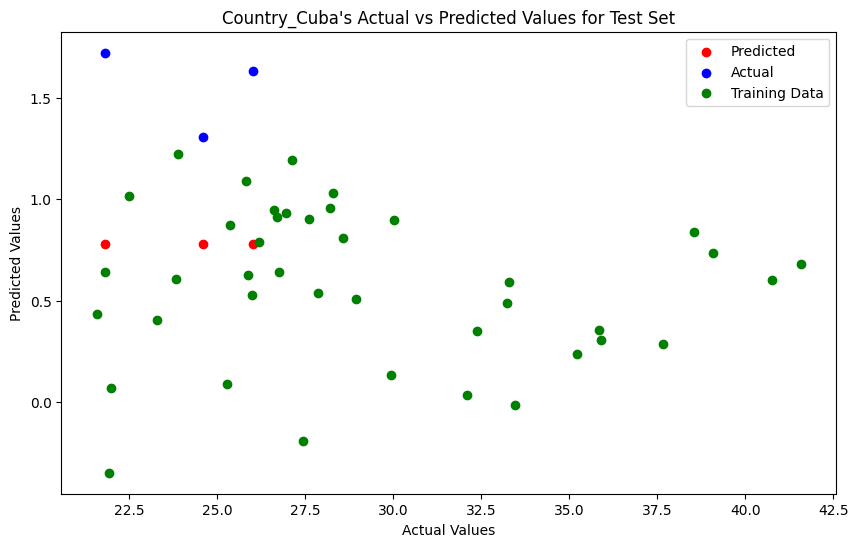

Epoch 1/100
8/8 [==============================] - 5s 123ms/step - loss: 0.1848 - mae: 0.5022 - val_loss: 0.1352 - val_mae: 0.5192
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1387 - mae: 0.3815 - val_loss: 0.4215 - val_mae: 0.9180
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1397 - mae: 0.4112 - val_loss: 0.0938 - val_mae: 0.4322
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0974 - mae: 0.3386 - val_loss: 0.0960 - val_mae: 0.4368
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1031 - mae: 0.3299 - val_loss: 0.0110 - val_mae: 0.1441
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1191 - mae: 0.3853 - val_loss: 8.6000e-04 - val_mae: 0.0327
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1591 - mae: 0.4639 - val_loss: 0.6616 - val_mae: 1.1616
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1834 - mae:

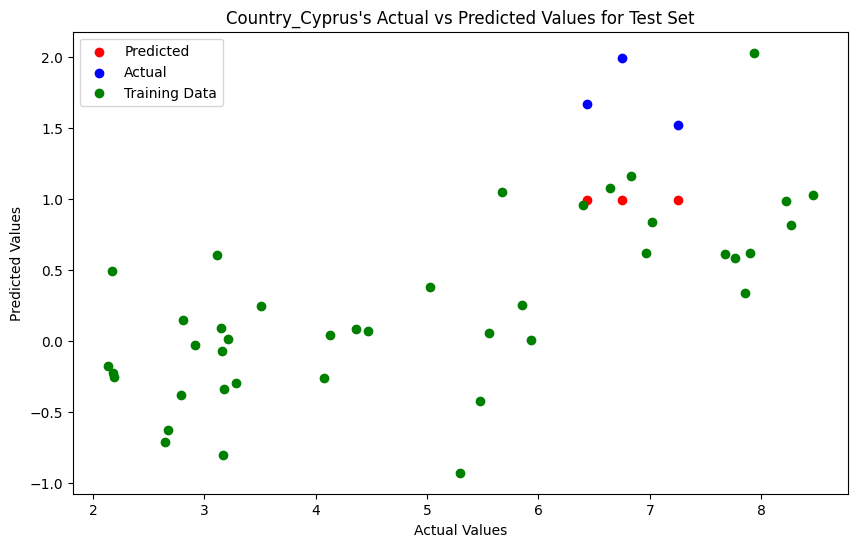

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.3790 - mae: 0.7403 - val_loss: 0.7632 - val_mae: 1.2330
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.3621 - mae: 0.7164 - val_loss: 0.8883 - val_mae: 1.3780
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.3433 - mae: 0.6969 - val_loss: 0.7772 - val_mae: 1.2499
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3383 - mae: 0.6964 - val_loss: 0.9477 - val_mae: 1.4429
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.3521 - mae: 0.7185 - val_loss: 0.8125 - val_mae: 1.2916
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 0.3480 - mae: 0.7135 - val_loss: 0.8079 - val_mae: 1.2862
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.3630 - mae: 0.7262 - val_loss: 0.8113 - val_mae: 1.2903
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.3885 - mae: 0.78

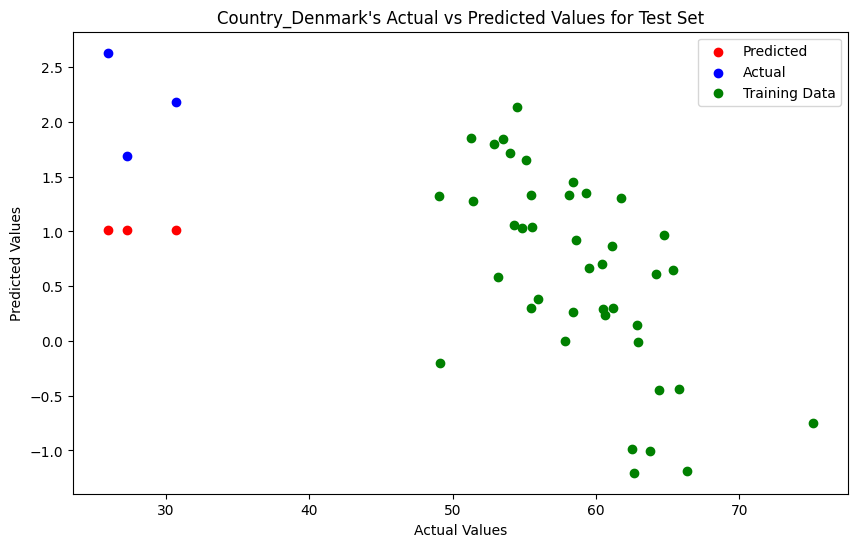

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.1367 - mae: 0.4318 - val_loss: 0.4895 - val_mae: 0.9689
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1264 - mae: 0.4423 - val_loss: 0.3818 - val_mae: 0.8420
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0887 - mae: 0.3641 - val_loss: 0.2847 - val_mae: 0.7212
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0929 - mae: 0.3768 - val_loss: 0.4146 - val_mae: 0.8868
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0975 - mae: 0.3690 - val_loss: 0.5041 - val_mae: 0.9898
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1094 - mae: 0.3695 - val_loss: 0.2526 - val_mae: 0.6701
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0941 - mae: 0.3595 - val_loss: 0.4717 - val_mae: 0.9515
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1166 - mae: 0.39

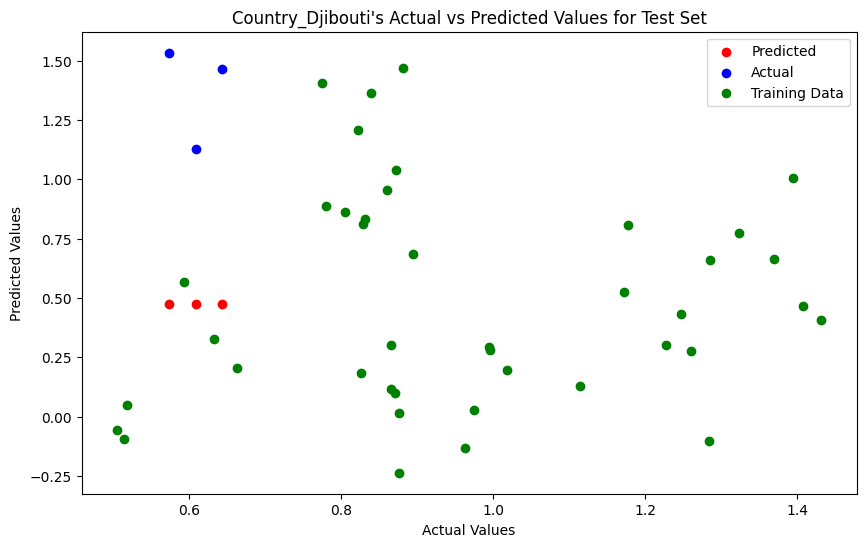

Epoch 1/100
8/8 [==============================] - 4s 86ms/step - loss: 0.0595 - mae: 0.2689 - val_loss: 0.0176 - val_mae: 0.1721
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0564 - mae: 0.2855 - val_loss: 0.0065 - val_mae: 0.1086
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0515 - mae: 0.2521 - val_loss: 9.0115e-04 - val_mae: 0.0416
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0509 - mae: 0.2588 - val_loss: 0.0011 - val_mae: 0.0441
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0504 - mae: 0.2560 - val_loss: 0.0015 - val_mae: 0.0515
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0545 - mae: 0.2560 - val_loss: 0.0246 - val_mae: 0.2070
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0678 - mae: 0.3033 - val_loss: 0.0258 - val_mae: 0.1990
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0563 - mae: 

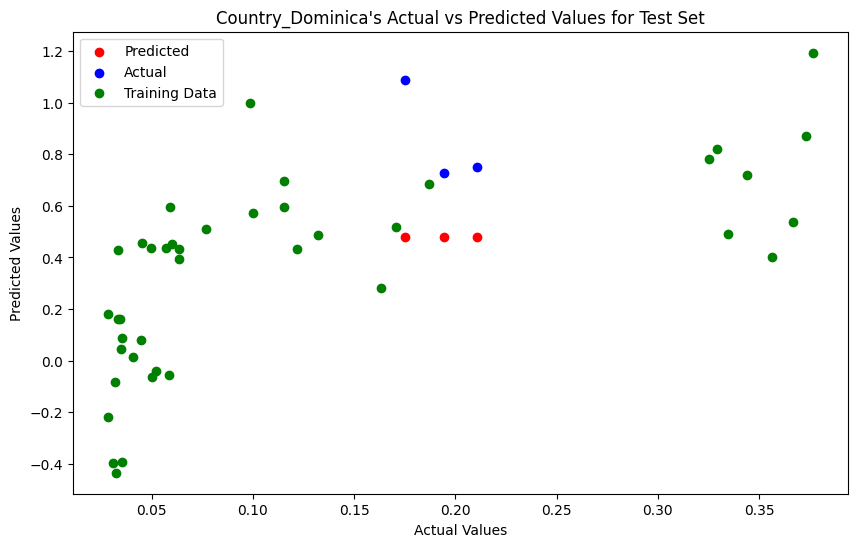

Epoch 1/100
8/8 [==============================] - 3s 75ms/step - loss: 0.1087 - mae: 0.3699 - val_loss: 0.1964 - val_mae: 0.6158
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0861 - mae: 0.3297 - val_loss: 0.2331 - val_mae: 0.6727
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0791 - mae: 0.3152 - val_loss: 0.1139 - val_mae: 0.4628
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0854 - mae: 0.3234 - val_loss: 0.2450 - val_mae: 0.6902
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0824 - mae: 0.3208 - val_loss: 0.1689 - val_mae: 0.5694
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0741 - mae: 0.3043 - val_loss: 0.1518 - val_mae: 0.5385
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0637 - mae: 0.2757 - val_loss: 0.1692 - val_mae: 0.5699
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0734 - mae: 0.30

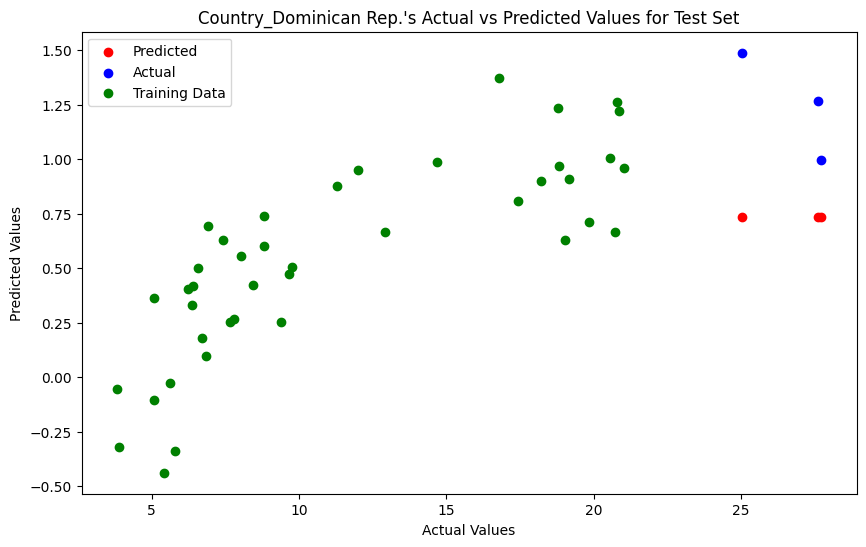

Epoch 1/100
8/8 [==============================] - 3s 75ms/step - loss: 0.1031 - mae: 0.3654 - val_loss: 0.3338 - val_mae: 0.7944
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0813 - mae: 0.3370 - val_loss: 0.1555 - val_mae: 0.5239
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0820 - mae: 0.3358 - val_loss: 0.2694 - val_mae: 0.7087
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0702 - mae: 0.3047 - val_loss: 0.1846 - val_mae: 0.5768
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0637 - mae: 0.2946 - val_loss: 0.1902 - val_mae: 0.5864
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0650 - mae: 0.2924 - val_loss: 0.1994 - val_mae: 0.6023
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0735 - mae: 0.3126 - val_loss: 0.1543 - val_mae: 0.5216
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0705 - mae: 0.31

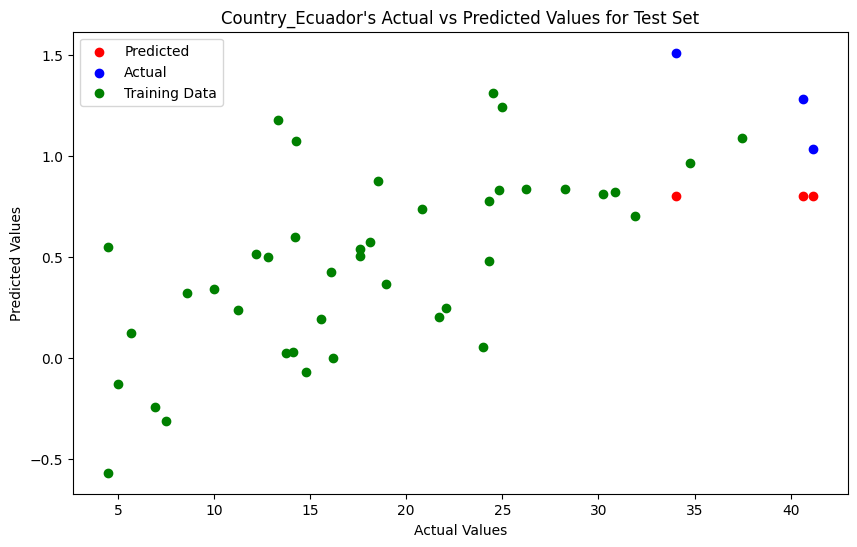

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.0611 - mae: 0.2705 - val_loss: 0.1521 - val_mae: 0.4529
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0382 - mae: 0.2226 - val_loss: 0.0987 - val_mae: 0.3147
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0338 - mae: 0.2121 - val_loss: 0.1095 - val_mae: 0.3463
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0329 - mae: 0.2107 - val_loss: 0.1634 - val_mae: 0.4771
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0360 - mae: 0.2248 - val_loss: 0.1486 - val_mae: 0.4450
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0314 - mae: 0.2086 - val_loss: 0.1404 - val_mae: 0.4261
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0346 - mae: 0.2130 - val_loss: 0.1452 - val_mae: 0.4372
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0375 - mae: 0.22

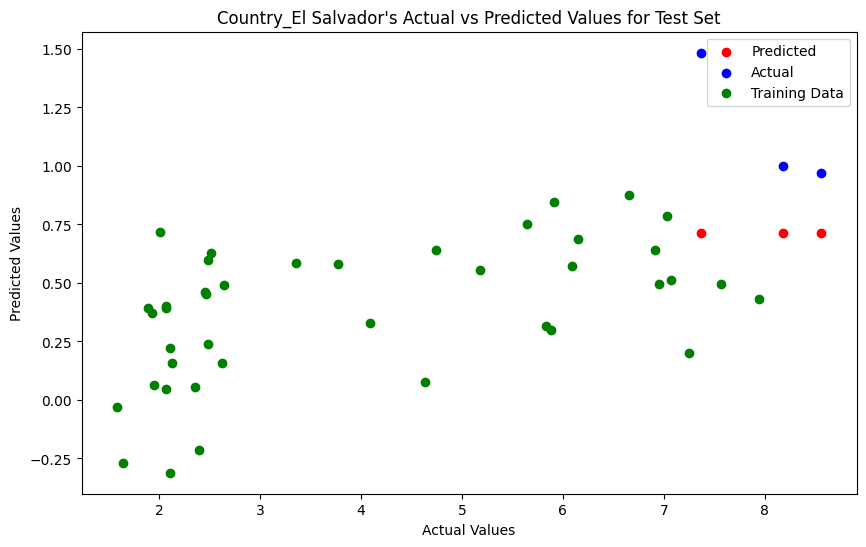

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.0529 - mae: 0.2400 - val_loss: 8.8484e-04 - val_mae: 0.0420
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0457 - mae: 0.2512 - val_loss: 1.2794e-04 - val_mae: 0.0158
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0276 - mae: 0.1921 - val_loss: 0.0086 - val_mae: 0.1308
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0263 - mae: 0.1860 - val_loss: 1.5630e-04 - val_mae: 0.0175
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0282 - mae: 0.1923 - val_loss: 8.6264e-04 - val_mae: 0.0414
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0252 - mae: 0.1757 - val_loss: 6.1230e-04 - val_mae: 0.0349
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0237 - mae: 0.1710 - val_loss: 5.1146e-04 - val_mae: 0.0318
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - 

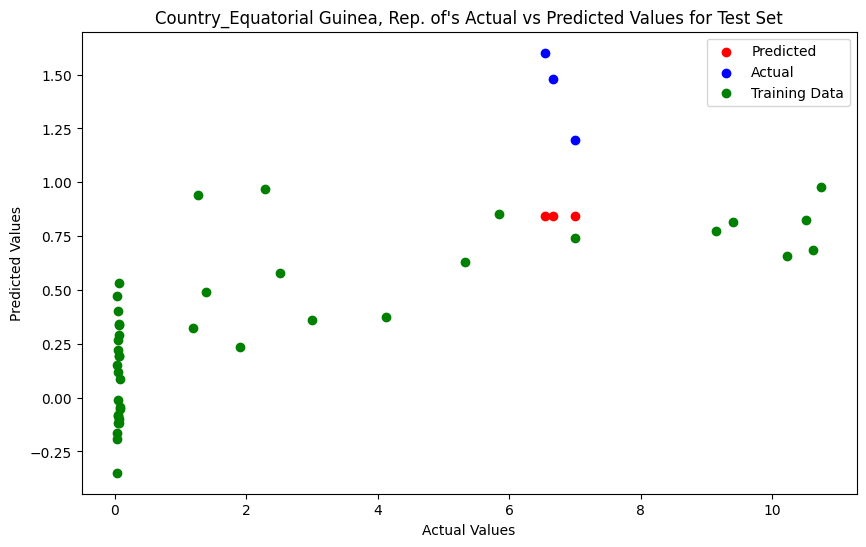

Epoch 1/100
8/8 [==============================] - 3s 78ms/step - loss: 0.4500 - mae: 0.8541 - val_loss: 1.3630 - val_mae: 1.8630
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.4461 - mae: 0.8482 - val_loss: 1.3594 - val_mae: 1.8594
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.4406 - mae: 0.8165 - val_loss: 1.2397 - val_mae: 1.7397
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.4281 - mae: 0.8137 - val_loss: 1.4736 - val_mae: 1.9736
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.4336 - mae: 0.8297 - val_loss: 1.3047 - val_mae: 1.8047
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.4351 - mae: 0.8171 - val_loss: 1.2735 - val_mae: 1.7735
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.4305 - mae: 0.8138 - val_loss: 1.3647 - val_mae: 1.8647
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.4427 - mae: 0.84

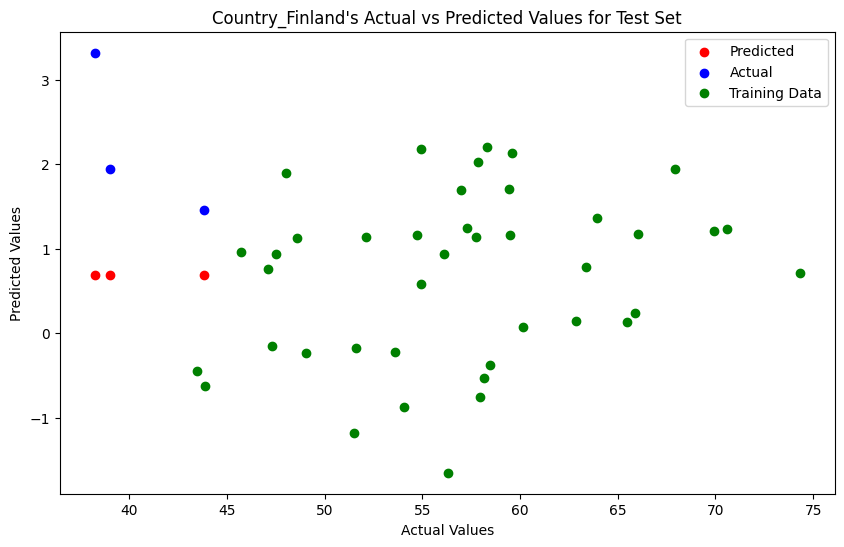

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.0590 - mae: 0.2743 - val_loss: 0.0332 - val_mae: 0.2554
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0317 - mae: 0.2099 - val_loss: 7.0905e-04 - val_mae: 0.0285
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0265 - mae: 0.1980 - val_loss: 0.0014 - val_mae: 0.0461
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0230 - mae: 0.1777 - val_loss: 0.0030 - val_mae: 0.0624
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0208 - mae: 0.1713 - val_loss: 0.0021 - val_mae: 0.0648
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0241 - mae: 0.1770 - val_loss: 0.0060 - val_mae: 0.0931
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0198 - mae: 0.1647 - val_loss: 0.0024 - val_mae: 0.0646
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0188 - mae: 

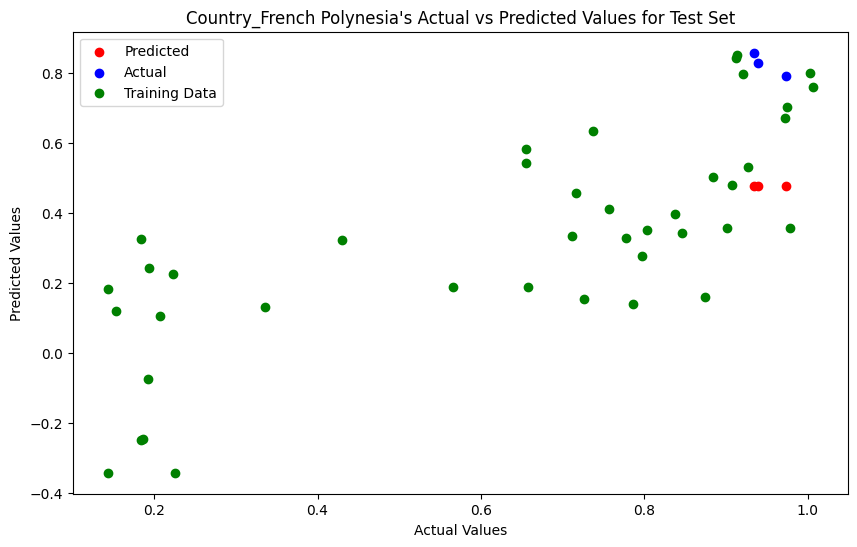

Epoch 1/100
8/8 [==============================] - 4s 74ms/step - loss: 0.0934 - mae: 0.3701 - val_loss: 0.2470 - val_mae: 0.6940
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0847 - mae: 0.3323 - val_loss: 0.1723 - val_mae: 0.5767
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0792 - mae: 0.3365 - val_loss: 0.1552 - val_mae: 0.5466
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0768 - mae: 0.3338 - val_loss: 0.1795 - val_mae: 0.5895
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0812 - mae: 0.3085 - val_loss: 0.1741 - val_mae: 0.5802
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0757 - mae: 0.3253 - val_loss: 0.1538 - val_mae: 0.5441
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0723 - mae: 0.3130 - val_loss: 0.2216 - val_mae: 0.6573
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0881 - mae: 0.32

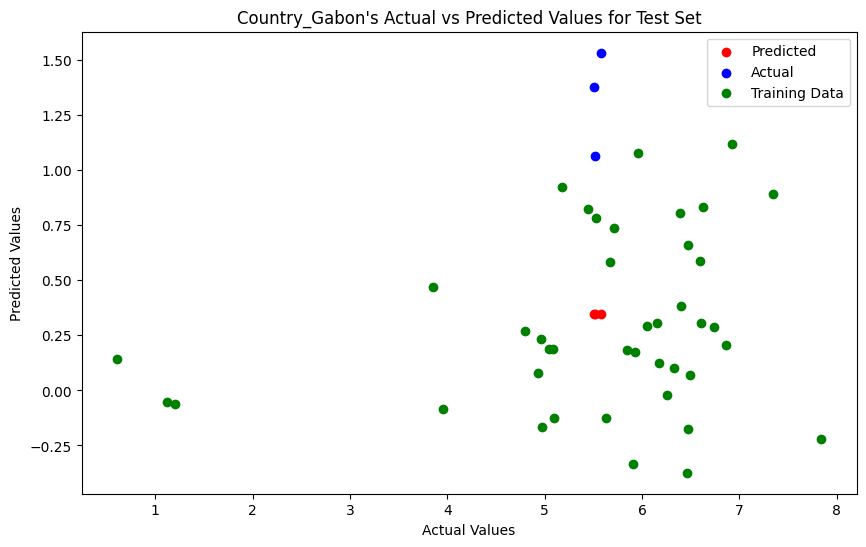

Epoch 1/100
8/8 [==============================] - 3s 126ms/step - loss: 0.3112 - mae: 0.7116 - val_loss: 0.7299 - val_mae: 1.2196
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.2852 - mae: 0.6661 - val_loss: 0.8835 - val_mae: 1.3831
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.2734 - mae: 0.6626 - val_loss: 0.8008 - val_mae: 1.2968
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2808 - mae: 0.6645 - val_loss: 0.8325 - val_mae: 1.3303
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.2766 - mae: 0.6676 - val_loss: 0.9032 - val_mae: 1.4031
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2800 - mae: 0.6716 - val_loss: 0.8601 - val_mae: 1.3591
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.3016 - mae: 0.6882 - val_loss: 0.7207 - val_mae: 1.2094
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2871 - mae: 0.6

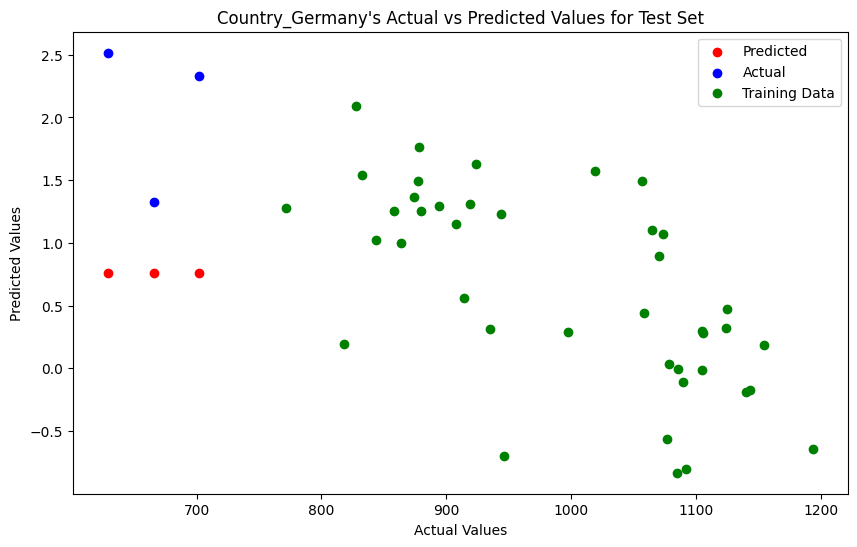

Epoch 1/100
8/8 [==============================] - 3s 93ms/step - loss: 0.0627 - mae: 0.2857 - val_loss: 0.1015 - val_mae: 0.4327
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0489 - mae: 0.2381 - val_loss: 0.0312 - val_mae: 0.2145
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0392 - mae: 0.2147 - val_loss: 0.0137 - val_mae: 0.1283
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0403 - mae: 0.2223 - val_loss: 0.0288 - val_mae: 0.2020
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0413 - mae: 0.2265 - val_loss: 0.0200 - val_mae: 0.1521
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0390 - mae: 0.2200 - val_loss: 0.0222 - val_mae: 0.1680
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0365 - mae: 0.2097 - val_loss: 0.0185 - val_mae: 0.1457
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0385 - mae: 0.21

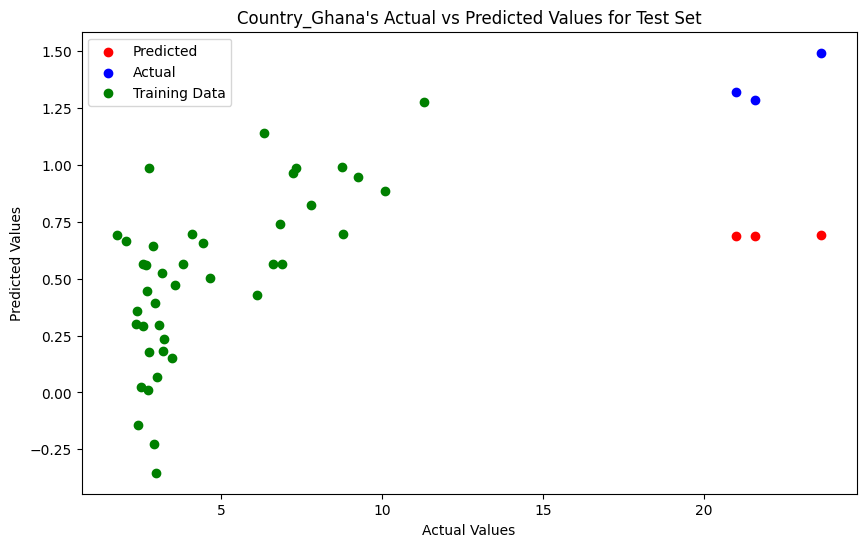

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.2187 - mae: 0.5432 - val_loss: 0.2947 - val_mae: 0.7677
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1054 - mae: 0.3737 - val_loss: 0.1692 - val_mae: 0.5801
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1052 - mae: 0.3816 - val_loss: 0.2177 - val_mae: 0.6589
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0782 - mae: 0.3156 - val_loss: 0.1419 - val_mae: 0.5324
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1104 - mae: 0.3791 - val_loss: 0.1128 - val_mae: 0.4750
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0747 - mae: 0.3031 - val_loss: 0.0643 - val_mae: 0.3585
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1379 - mae: 0.4195 - val_loss: 0.3467 - val_mae: 0.8322
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1553 - mae: 0.45

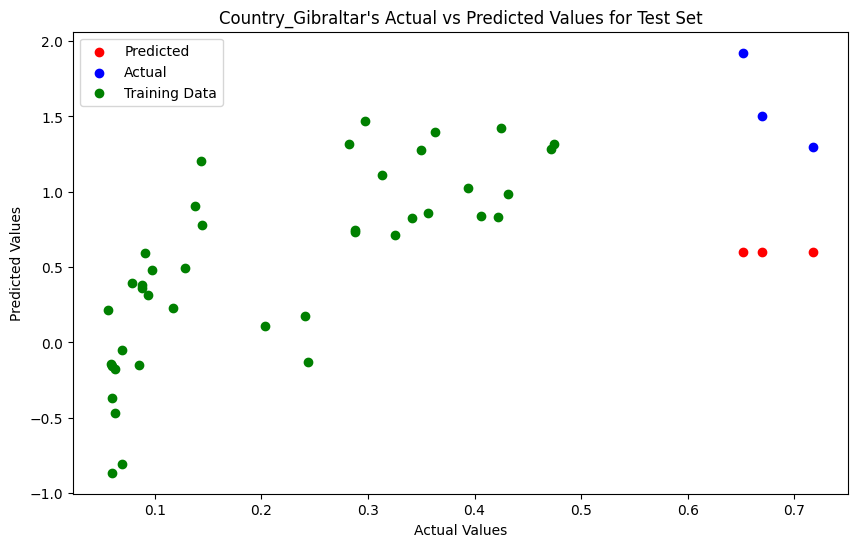

Epoch 1/100
8/8 [==============================] - 3s 74ms/step - loss: 0.2125 - mae: 0.5352 - val_loss: 0.4307 - val_mae: 0.9248
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1588 - mae: 0.4685 - val_loss: 0.3107 - val_mae: 0.7844
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1590 - mae: 0.4718 - val_loss: 0.3638 - val_mae: 0.8495
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1712 - mae: 0.4865 - val_loss: 0.3332 - val_mae: 0.8126
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1629 - mae: 0.4710 - val_loss: 0.4601 - val_mae: 0.9564
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1568 - mae: 0.4594 - val_loss: 0.2932 - val_mae: 0.7618
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1680 - mae: 0.4876 - val_loss: 0.3256 - val_mae: 0.8032
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1632 - mae: 0.46

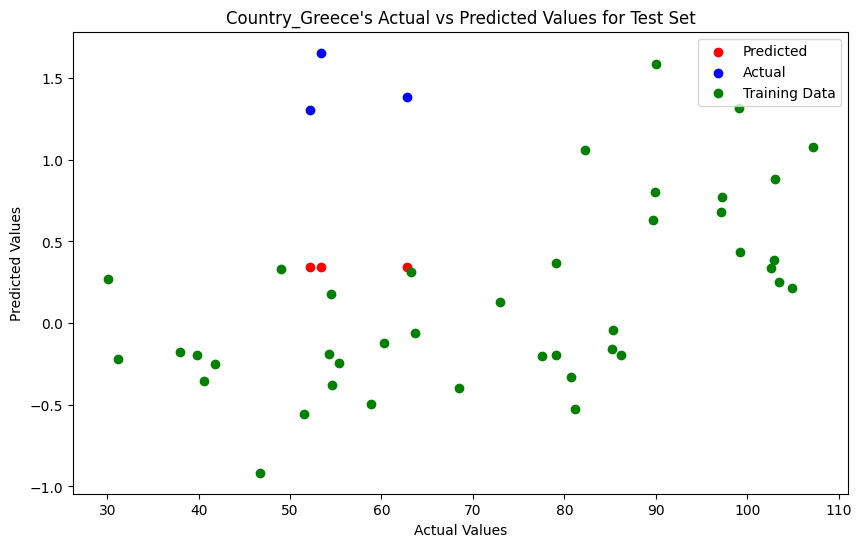

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.5155 - mae: 0.9304 - val_loss: 0.2037 - val_mae: 0.6242
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.5156 - mae: 0.9302 - val_loss: 0.3866 - val_mae: 0.6850
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.6108 - mae: 1.0229 - val_loss: 0.2184 - val_mae: 0.6373
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.5319 - mae: 0.9535 - val_loss: 0.8874 - val_mae: 1.3716
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.6734 - mae: 1.0438 - val_loss: 0.2712 - val_mae: 0.6500
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.4933 - mae: 0.8842 - val_loss: 0.2120 - val_mae: 0.6297
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.4640 - mae: 0.8077 - val_loss: 0.3275 - val_mae: 0.5776
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.4866 - mae: 0.86

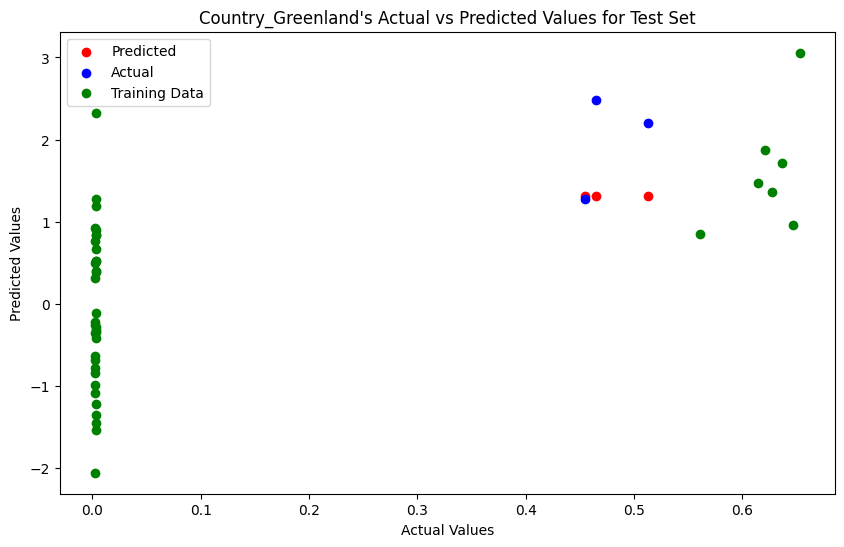

Epoch 1/100
8/8 [==============================] - 3s 91ms/step - loss: 0.1602 - mae: 0.4794 - val_loss: 0.0186 - val_mae: 0.1707
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0750 - mae: 0.3332 - val_loss: 0.0901 - val_mae: 0.4120
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0548 - mae: 0.2536 - val_loss: 0.0146 - val_mae: 0.1345
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0372 - mae: 0.2136 - val_loss: 0.0068 - val_mae: 0.1074
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0446 - mae: 0.2465 - val_loss: 0.0089 - val_mae: 0.1056
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0485 - mae: 0.2544 - val_loss: 0.0071 - val_mae: 0.1022
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0686 - mae: 0.2764 - val_loss: 0.0051 - val_mae: 0.1006
Epoch 8/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0512 - mae: 0.27

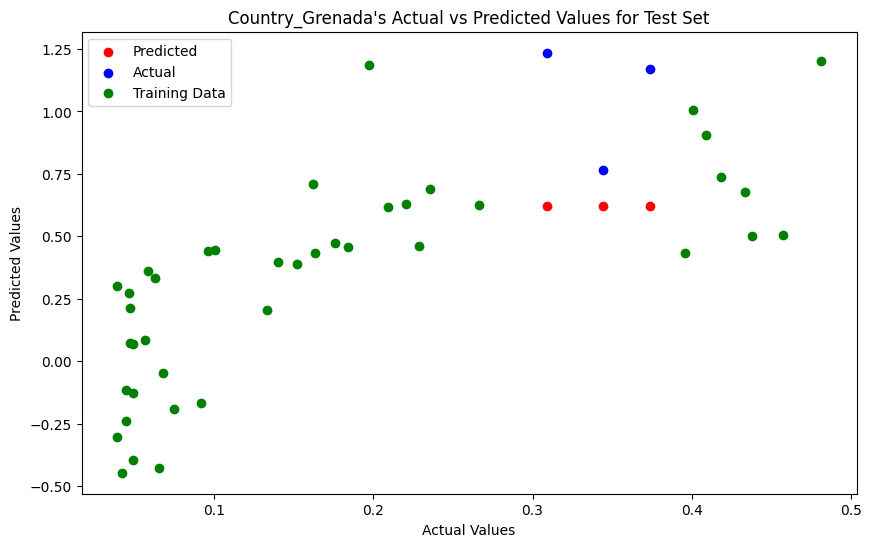

Epoch 1/100
8/8 [==============================] - 3s 81ms/step - loss: 0.0678 - mae: 0.2980 - val_loss: 0.1448 - val_mae: 0.5213
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0728 - mae: 0.3192 - val_loss: 0.0844 - val_mae: 0.3805
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0367 - mae: 0.2225 - val_loss: 0.0151 - val_mae: 0.1511
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0552 - mae: 0.2852 - val_loss: 0.0982 - val_mae: 0.4070
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0449 - mae: 0.2458 - val_loss: 0.0212 - val_mae: 0.1523
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0361 - mae: 0.2218 - val_loss: 0.0701 - val_mae: 0.3364
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0363 - mae: 0.2150 - val_loss: 0.0337 - val_mae: 0.2018
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0323 - mae: 0.20

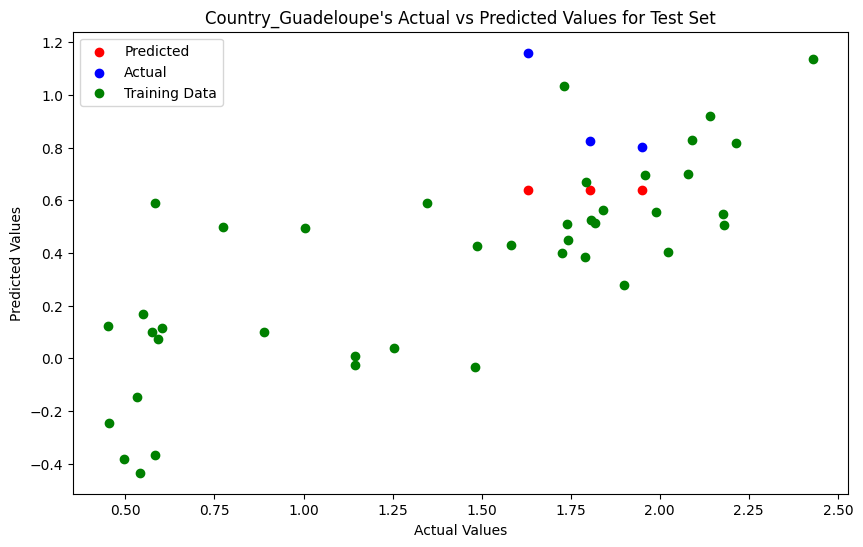

Epoch 1/100
8/8 [==============================] - 4s 117ms/step - loss: 0.0553 - mae: 0.2784 - val_loss: 0.2778 - val_mae: 0.7012
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0501 - mae: 0.2568 - val_loss: 0.1188 - val_mae: 0.4170
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0448 - mae: 0.2350 - val_loss: 0.1314 - val_mae: 0.4463
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0420 - mae: 0.2376 - val_loss: 0.1590 - val_mae: 0.5043
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0412 - mae: 0.2292 - val_loss: 0.1212 - val_mae: 0.4230
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0329 - mae: 0.2077 - val_loss: 0.0957 - val_mae: 0.3579
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0305 - mae: 0.1918 - val_loss: 0.0669 - val_mae: 0.2659
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0333 - mae: 0.2

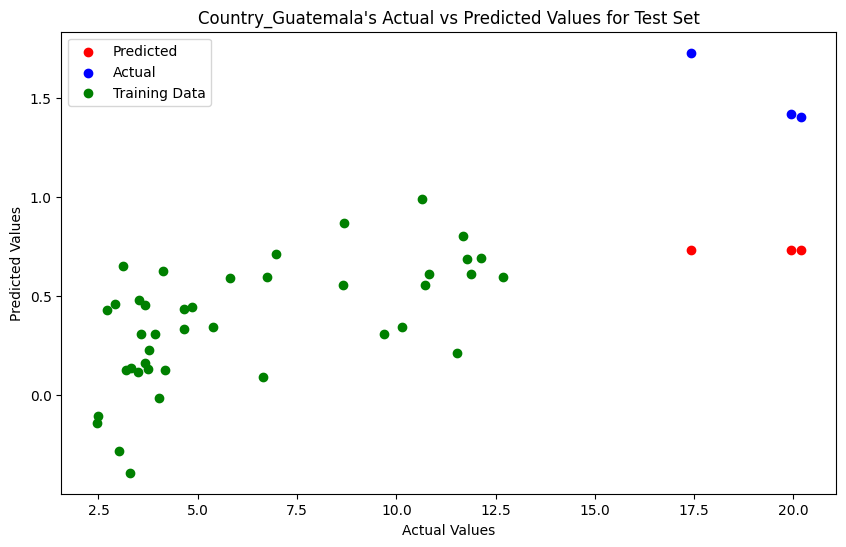

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.1042 - mae: 0.3803 - val_loss: 0.0283 - val_mae: 0.1958
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0590 - mae: 0.2858 - val_loss: 0.0067 - val_mae: 0.1148
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0555 - mae: 0.2858 - val_loss: 0.0193 - val_mae: 0.1479
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0382 - mae: 0.2272 - val_loss: 0.0093 - val_mae: 0.1345
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0375 - mae: 0.2194 - val_loss: 0.0214 - val_mae: 0.1625
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0290 - mae: 0.2028 - val_loss: 0.0108 - val_mae: 0.1246
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0275 - mae: 0.1870 - val_loss: 0.0092 - val_mae: 0.1296
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0299 - mae: 0.19

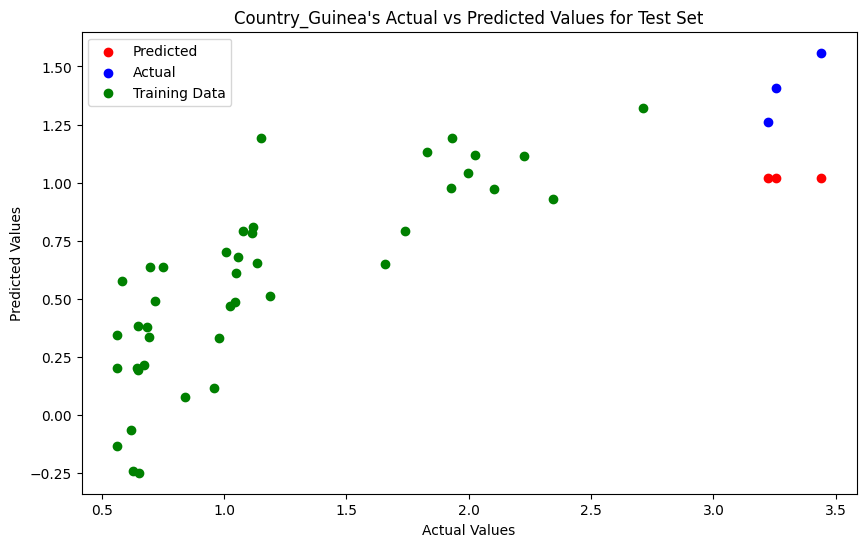

Epoch 1/100
8/8 [==============================] - 4s 95ms/step - loss: 0.0836 - mae: 0.3376 - val_loss: 0.0027 - val_mae: 0.0732
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0426 - mae: 0.2523 - val_loss: 8.9836e-04 - val_mae: 0.0400
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0408 - mae: 0.2258 - val_loss: 0.0293 - val_mae: 0.2416
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0414 - mae: 0.2217 - val_loss: 5.9386e-04 - val_mae: 0.0311
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0408 - mae: 0.2336 - val_loss: 8.3113e-05 - val_mae: 0.0124
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0376 - mae: 0.2049 - val_loss: 0.0014 - val_mae: 0.0523
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0336 - mae: 0.2051 - val_loss: 0.0025 - val_mae: 0.0701
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0372

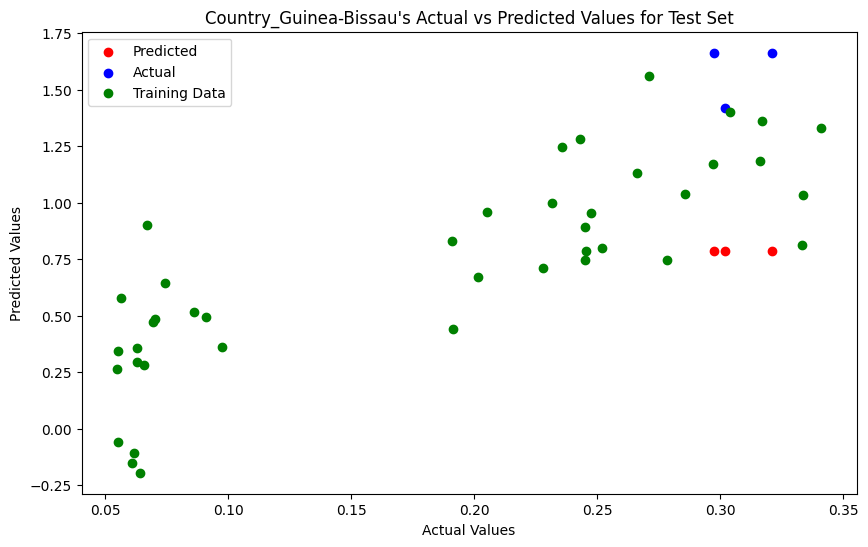

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.1305 - mae: 0.4397 - val_loss: 0.5228 - val_mae: 1.0191
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1346 - mae: 0.4366 - val_loss: 0.2455 - val_mae: 0.6854
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1245 - mae: 0.4187 - val_loss: 0.2385 - val_mae: 0.6744
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1213 - mae: 0.4069 - val_loss: 0.3500 - val_mae: 0.8230
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1271 - mae: 0.4223 - val_loss: 0.2870 - val_mae: 0.7427
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1227 - mae: 0.4116 - val_loss: 0.3328 - val_mae: 0.8023
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1299 - mae: 0.4262 - val_loss: 0.2592 - val_mae: 0.7049
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1282 - mae: 0.41

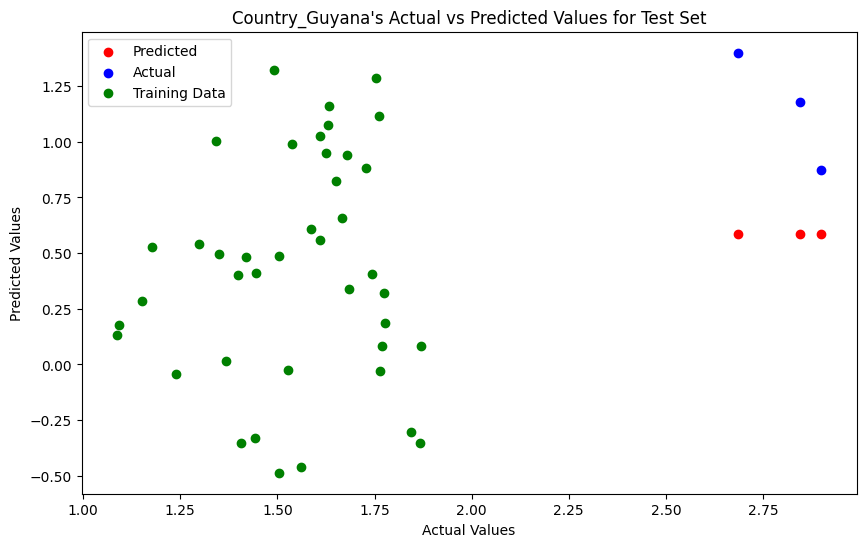

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.0944 - mae: 0.3566 - val_loss: 0.1929 - val_mae: 0.6200
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0574 - mae: 0.2734 - val_loss: 0.1427 - val_mae: 0.5328
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0492 - mae: 0.2474 - val_loss: 0.0280 - val_mae: 0.2335
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0593 - mae: 0.2906 - val_loss: 0.0915 - val_mae: 0.4261
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0894 - mae: 0.3409 - val_loss: 0.1366 - val_mae: 0.5212
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0433 - mae: 0.2427 - val_loss: 0.0883 - val_mae: 0.4186
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0361 - mae: 0.2238 - val_loss: 0.0329 - val_mae: 0.2540
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0348 - mae: 0.21

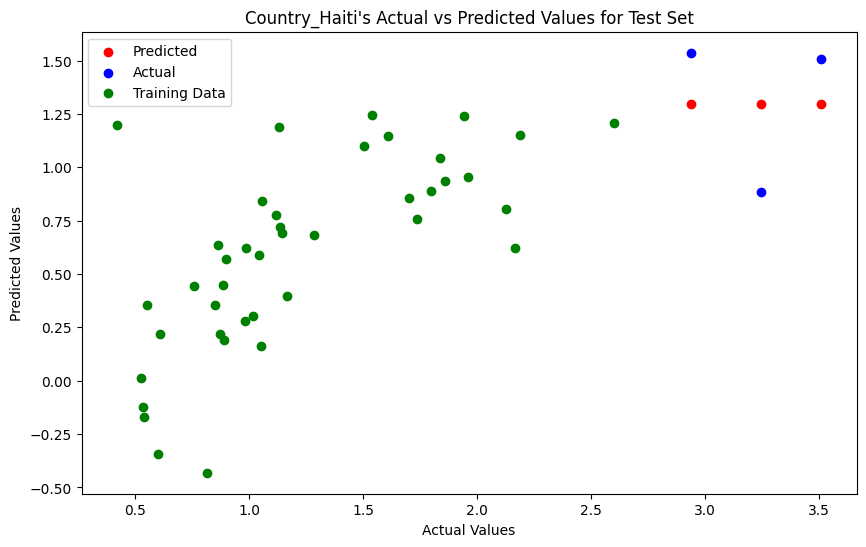

Epoch 1/100
8/8 [==============================] - 4s 84ms/step - loss: 0.0946 - mae: 0.3507 - val_loss: 0.0957 - val_mae: 0.3723
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 0.0656 - mae: 0.2763 - val_loss: 0.0883 - val_mae: 0.3519
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0495 - mae: 0.2422 - val_loss: 0.0269 - val_mae: 0.2299
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0682 - mae: 0.2947 - val_loss: 0.1582 - val_mae: 0.5134
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0438 - mae: 0.2517 - val_loss: 0.0511 - val_mae: 0.2299
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0364 - mae: 0.2194 - val_loss: 0.0649 - val_mae: 0.2773
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0346 - mae: 0.2276 - val_loss: 0.0590 - val_mae: 0.2552
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0357 - mae: 0.22

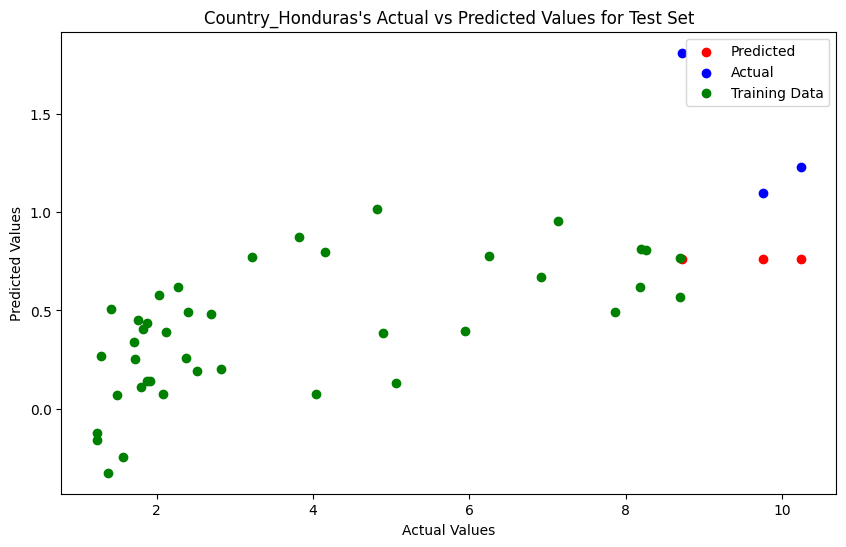

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.2790 - mae: 0.6274 - val_loss: 1.2034 - val_mae: 1.7034
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2772 - mae: 0.6226 - val_loss: 1.2151 - val_mae: 1.7151
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2659 - mae: 0.6056 - val_loss: 1.0558 - val_mae: 1.5558
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3000 - mae: 0.6427 - val_loss: 1.0382 - val_mae: 1.5382
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2783 - mae: 0.6179 - val_loss: 1.2760 - val_mae: 1.7760
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2761 - mae: 0.6259 - val_loss: 1.1095 - val_mae: 1.6095
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.3014 - mae: 0.6572 - val_loss: 1.0610 - val_mae: 1.5610
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.2864 - mae: 0.64

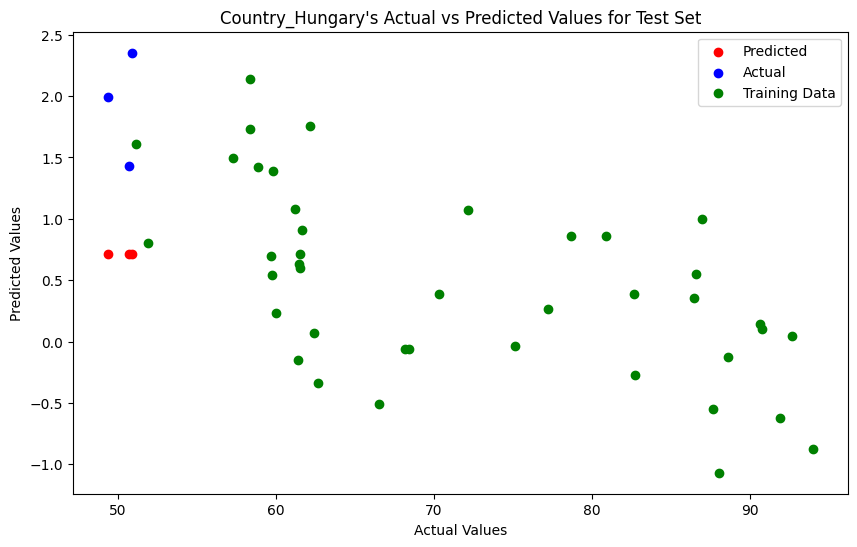

Epoch 1/100
8/8 [==============================] - 3s 90ms/step - loss: 0.1971 - mae: 0.4958 - val_loss: 0.3767 - val_mae: 0.6375
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1289 - mae: 0.3862 - val_loss: 0.2225 - val_mae: 0.6168
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0989 - mae: 0.3475 - val_loss: 0.2050 - val_mae: 0.6053
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1580 - mae: 0.4713 - val_loss: 0.3747 - val_mae: 0.6407
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1627 - mae: 0.4564 - val_loss: 0.2881 - val_mae: 0.6103
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1160 - mae: 0.3455 - val_loss: 0.2693 - val_mae: 0.6009
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1691 - mae: 0.4664 - val_loss: 0.2289 - val_mae: 0.5685
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1775 - mae: 0.46

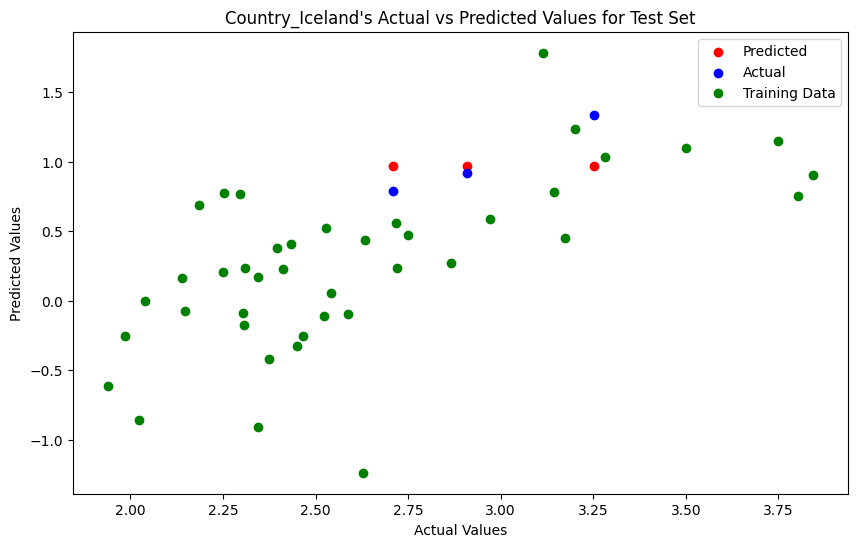

Epoch 1/100
8/8 [==============================] - 3s 78ms/step - loss: 0.1296 - mae: 0.4129 - val_loss: 0.1834 - val_mae: 0.5988
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0679 - mae: 0.2995 - val_loss: 0.0342 - val_mae: 0.2455
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0615 - mae: 0.2860 - val_loss: 0.0546 - val_mae: 0.3178
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0582 - mae: 0.2795 - val_loss: 0.0660 - val_mae: 0.3519
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0594 - mae: 0.2731 - val_loss: 0.0665 - val_mae: 0.3532
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0572 - mae: 0.2727 - val_loss: 0.0420 - val_mae: 0.2753
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0558 - mae: 0.2689 - val_loss: 0.0744 - val_mae: 0.3749
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0599 - mae: 0.27

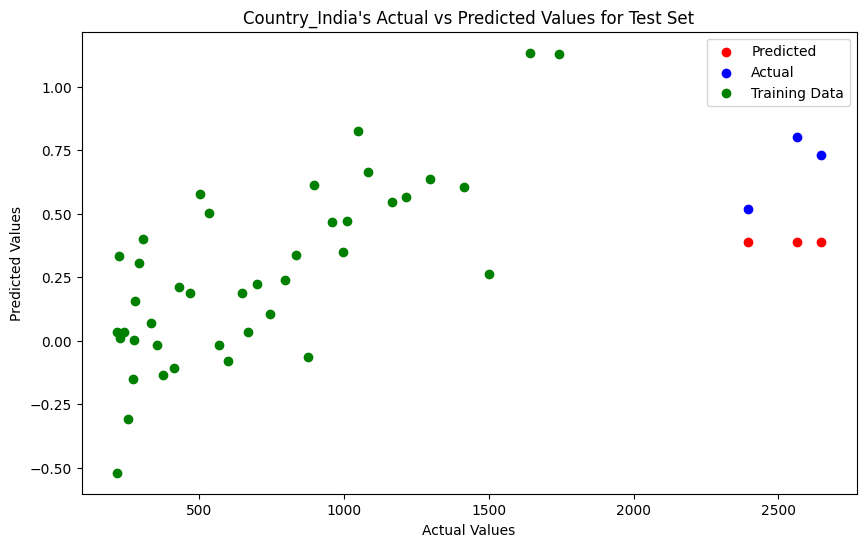

Epoch 1/100
8/8 [==============================] - 3s 84ms/step - loss: 0.0319 - mae: 0.2002 - val_loss: 0.1259 - val_mae: 0.5015
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0322 - mae: 0.1941 - val_loss: 0.1512 - val_mae: 0.5498
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0304 - mae: 0.1911 - val_loss: 0.1072 - val_mae: 0.4628
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0327 - mae: 0.2038 - val_loss: 0.1076 - val_mae: 0.4637
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0305 - mae: 0.1906 - val_loss: 0.1479 - val_mae: 0.5437
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0317 - mae: 0.1951 - val_loss: 0.1311 - val_mae: 0.5118
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0327 - mae: 0.2007 - val_loss: 0.1160 - val_mae: 0.4815
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0326 - mae: 0.19

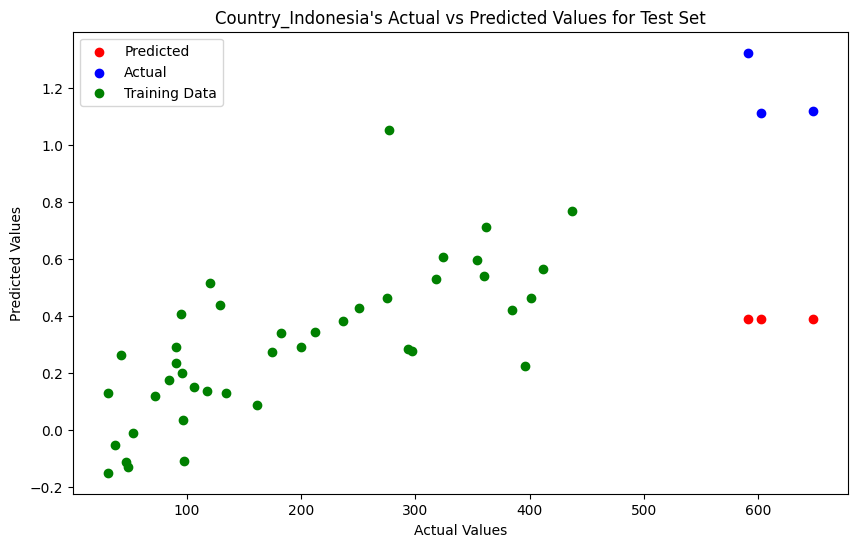

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.2817 - mae: 0.6217 - val_loss: 0.6078 - val_mae: 1.0858
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2805 - mae: 0.6278 - val_loss: 0.5999 - val_mae: 1.0765
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.2796 - mae: 0.6271 - val_loss: 0.5839 - val_mae: 1.0575
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2875 - mae: 0.6476 - val_loss: 0.5496 - val_mae: 1.0160
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2785 - mae: 0.6123 - val_loss: 0.7245 - val_mae: 1.2178
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 0.2899 - mae: 0.6230 - val_loss: 0.6706 - val_mae: 1.1580
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2951 - mae: 0.6525 - val_loss: 0.4950 - val_mae: 0.9478
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2857 - mae: 0.64

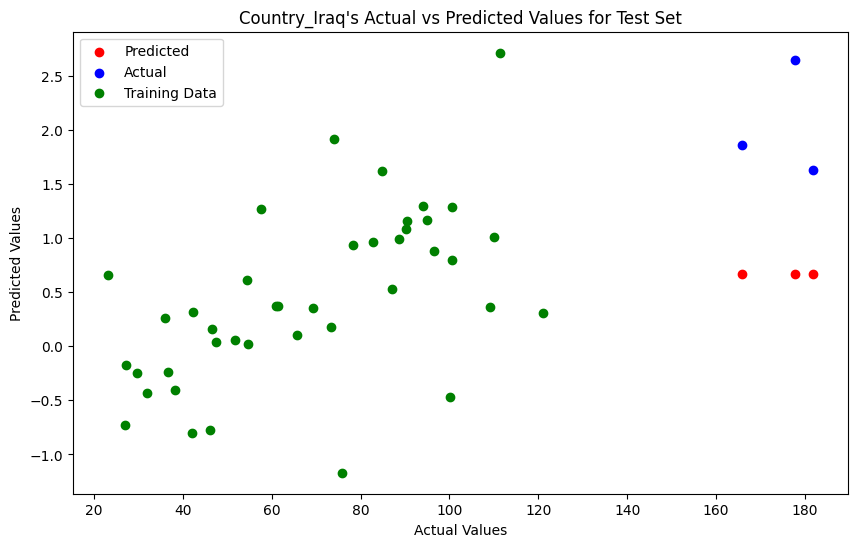

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.1552 - mae: 0.4745 - val_loss: 0.2093 - val_mae: 0.4609
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1473 - mae: 0.4548 - val_loss: 0.2471 - val_mae: 0.5367
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1459 - mae: 0.4528 - val_loss: 0.1673 - val_mae: 0.4540
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1454 - mae: 0.4513 - val_loss: 0.2036 - val_mae: 0.4540
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1431 - mae: 0.4499 - val_loss: 0.1993 - val_mae: 0.4540
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1453 - mae: 0.4509 - val_loss: 0.2140 - val_mae: 0.4710
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1493 - mae: 0.4595 - val_loss: 0.1825 - val_mae: 0.4540
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1470 - mae: 0.45

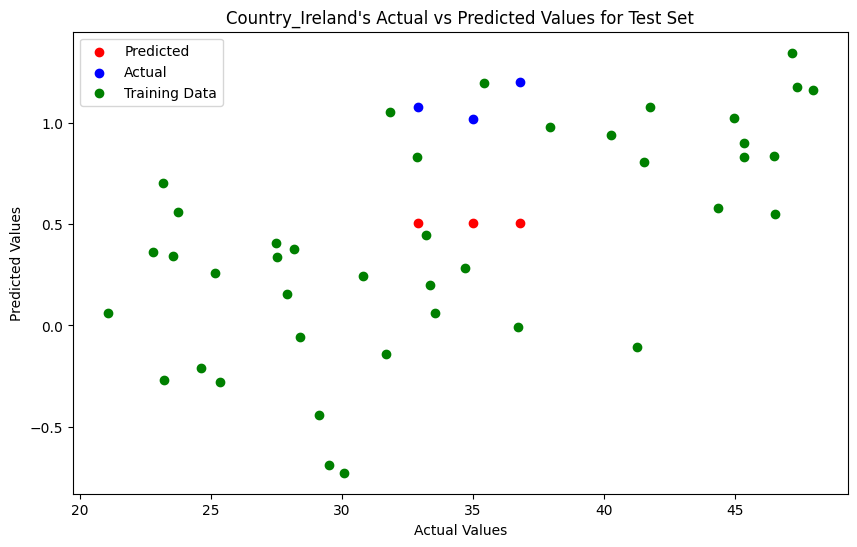

Epoch 1/100
8/8 [==============================] - 4s 85ms/step - loss: 0.0834 - mae: 0.3378 - val_loss: 0.2054 - val_mae: 0.6339
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0780 - mae: 0.3330 - val_loss: 0.2154 - val_mae: 0.6496
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0774 - mae: 0.3280 - val_loss: 0.2197 - val_mae: 0.6561
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0761 - mae: 0.3258 - val_loss: 0.2177 - val_mae: 0.6531
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0760 - mae: 0.3244 - val_loss: 0.2273 - val_mae: 0.6676
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0755 - mae: 0.3228 - val_loss: 0.2274 - val_mae: 0.6678
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0774 - mae: 0.3274 - val_loss: 0.2087 - val_mae: 0.6391
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0768 - mae: 0.32

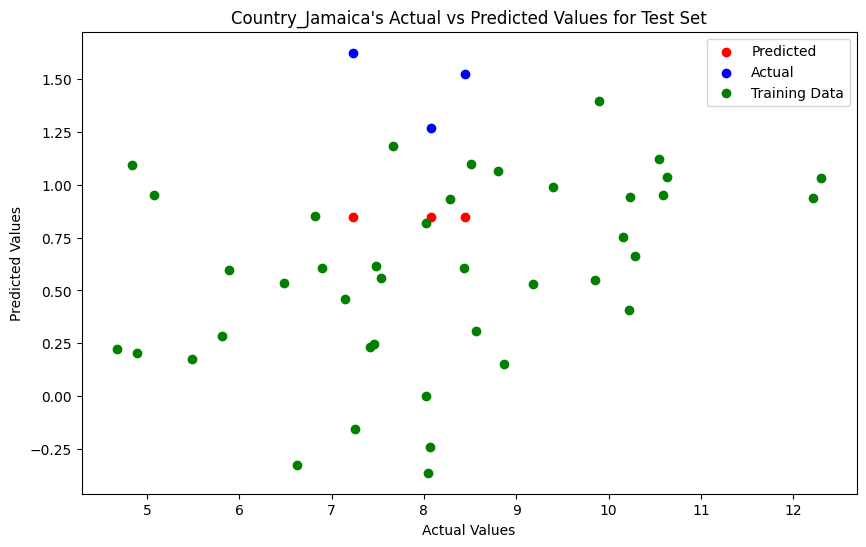

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.1885 - mae: 0.5101 - val_loss: 0.1041 - val_mae: 0.4354
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1559 - mae: 0.4734 - val_loss: 0.1298 - val_mae: 0.4909
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1344 - mae: 0.4178 - val_loss: 0.0321 - val_mae: 0.2136
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1350 - mae: 0.4170 - val_loss: 0.1190 - val_mae: 0.4684
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1411 - mae: 0.4352 - val_loss: 0.0785 - val_mae: 0.3719
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1340 - mae: 0.4193 - val_loss: 0.0760 - val_mae: 0.3653
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1394 - mae: 0.4280 - val_loss: 0.0703 - val_mae: 0.3492
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1585 - mae: 0.46

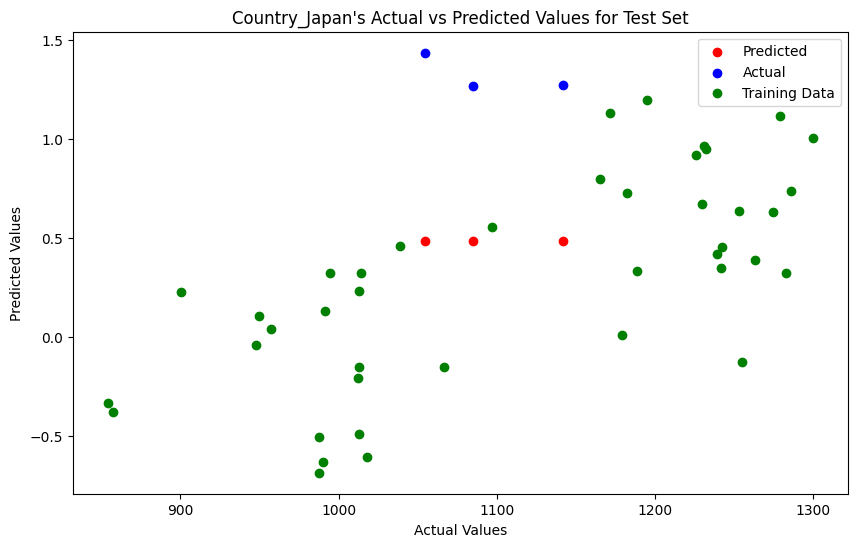

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.2289 - mae: 0.5611 - val_loss: 0.5519 - val_mae: 1.0309
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2004 - mae: 0.4902 - val_loss: 0.4597 - val_mae: 0.9193
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1832 - mae: 0.4778 - val_loss: 0.3012 - val_mae: 0.7069
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1789 - mae: 0.4502 - val_loss: 0.4517 - val_mae: 0.9093
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1736 - mae: 0.4820 - val_loss: 0.2771 - val_mae: 0.6716
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1490 - mae: 0.3822 - val_loss: 0.1228 - val_mae: 0.3775
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1499 - mae: 0.4074 - val_loss: 0.1747 - val_mae: 0.4964
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 0.1437 - mae: 0.38

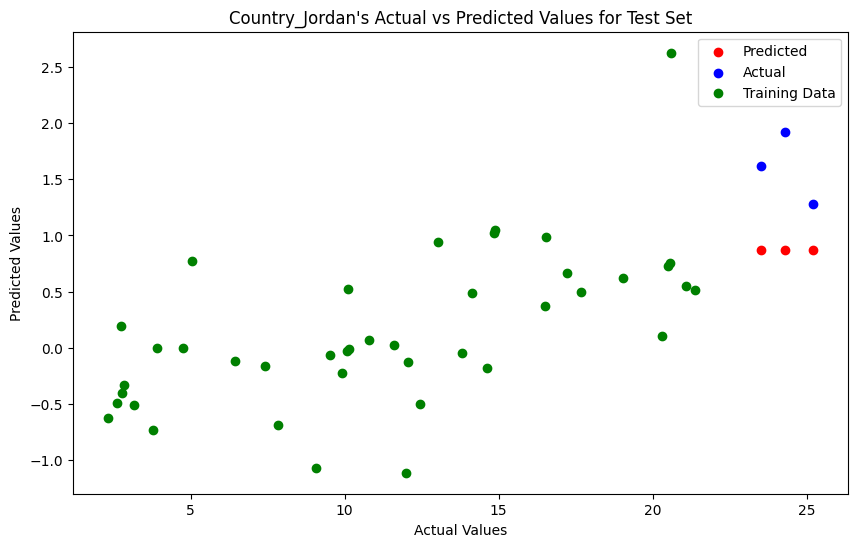

Epoch 1/100
8/8 [==============================] - 3s 81ms/step - loss: 0.0807 - mae: 0.3482 - val_loss: 0.0977 - val_mae: 0.4408
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0723 - mae: 0.3139 - val_loss: 0.2663 - val_mae: 0.7276
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0601 - mae: 0.2857 - val_loss: 0.2018 - val_mae: 0.6322
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0642 - mae: 0.2985 - val_loss: 0.1855 - val_mae: 0.6057
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0588 - mae: 0.2896 - val_loss: 0.2624 - val_mae: 0.7215
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0630 - mae: 0.2917 - val_loss: 0.2358 - val_mae: 0.6836
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0625 - mae: 0.2995 - val_loss: 0.2120 - val_mae: 0.6478
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0614 - mae: 0.29

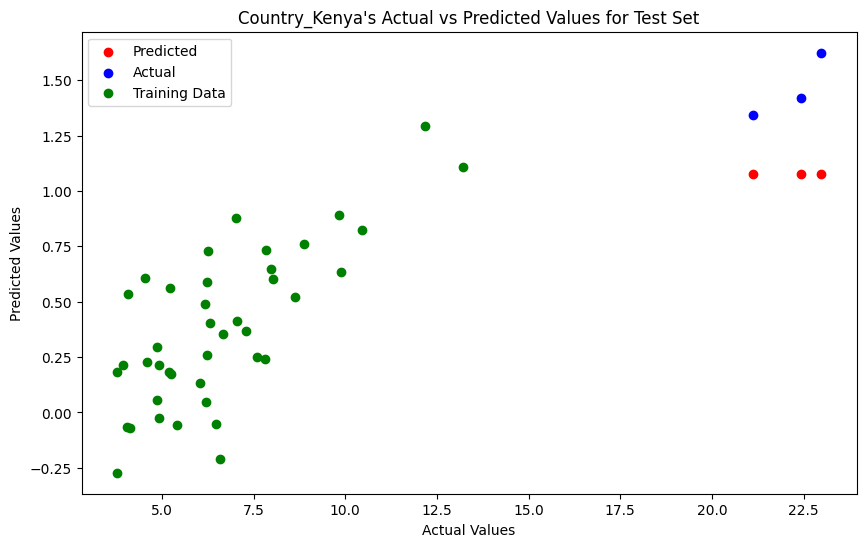

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.1375 - mae: 0.4132 - val_loss: 0.0832 - val_mae: 0.4024
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0917 - mae: 0.3216 - val_loss: 0.2490 - val_mae: 0.7025
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0660 - mae: 0.2712 - val_loss: 0.2215 - val_mae: 0.6622
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0667 - mae: 0.2664 - val_loss: 0.1031 - val_mae: 0.4491
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0641 - mae: 0.2812 - val_loss: 0.2544 - val_mae: 0.7101
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0753 - mae: 0.2803 - val_loss: 0.1369 - val_mae: 0.5189
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0675 - mae: 0.2764 - val_loss: 0.1681 - val_mae: 0.5759
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0597 - mae: 0.23

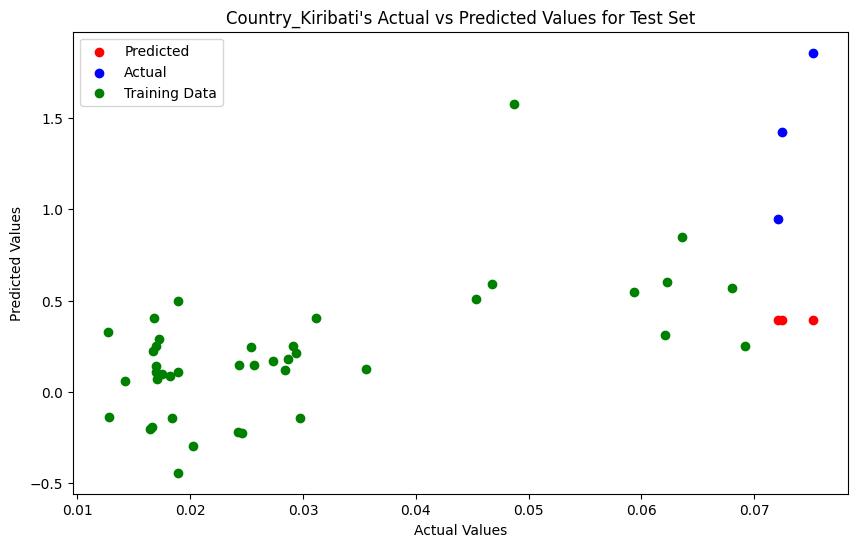

Epoch 1/100
8/8 [==============================] - 3s 108ms/step - loss: 0.3070 - mae: 0.6756 - val_loss: 0.4874 - val_mae: 0.9524
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 0.3179 - mae: 0.6886 - val_loss: 0.8645 - val_mae: 1.3645
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 0.2898 - mae: 0.6389 - val_loss: 0.4721 - val_mae: 0.9335
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 0.3080 - mae: 0.6816 - val_loss: 0.6881 - val_mae: 1.1830
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 0.3052 - mae: 0.6477 - val_loss: 0.8638 - val_mae: 1.3638
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2919 - mae: 0.6558 - val_loss: 0.5199 - val_mae: 0.9919
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3248 - mae: 0.6990 - val_loss: 0.7141 - val_mae: 1.2107
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3101 - mae: 0.6

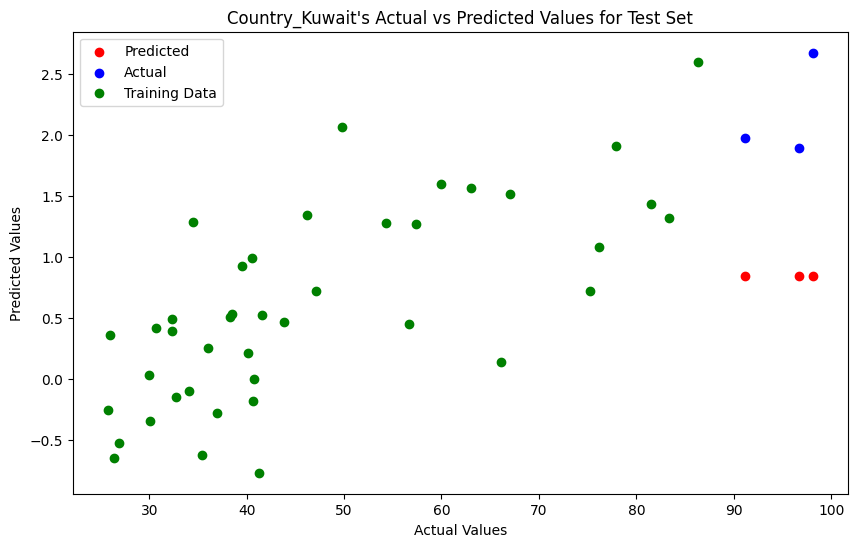

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.2362 - mae: 0.5648 - val_loss: 0.5491 - val_mae: 1.0454
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1548 - mae: 0.4196 - val_loss: 0.1358 - val_mae: 0.4941
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1363 - mae: 0.3938 - val_loss: 0.1132 - val_mae: 0.4460
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1344 - mae: 0.4033 - val_loss: 0.3512 - val_mae: 0.8217
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1998 - mae: 0.5156 - val_loss: 0.2624 - val_mae: 0.7052
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1363 - mae: 0.4045 - val_loss: 0.0137 - val_mae: 0.1652
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2023 - mae: 0.5273 - val_loss: 0.5839 - val_mae: 1.0821
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1740 - mae: 0.48

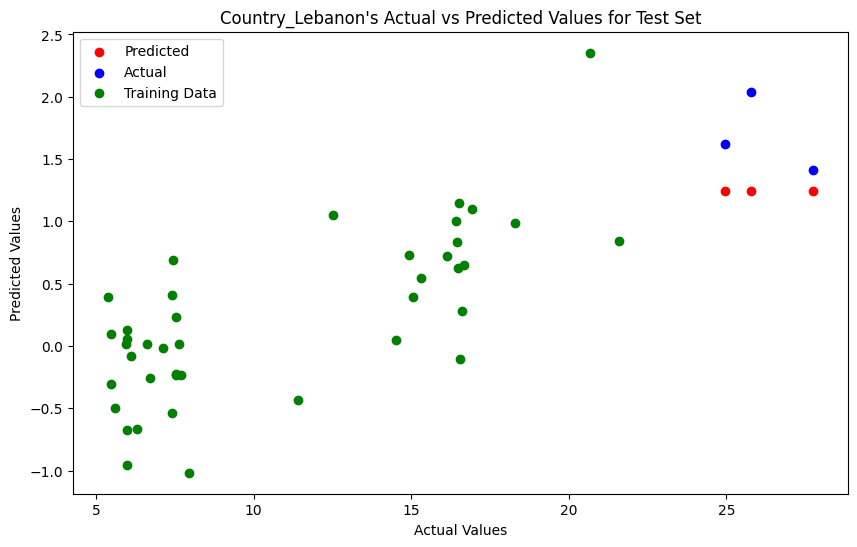

Epoch 1/100
8/8 [==============================] - 5s 79ms/step - loss: 0.1152 - mae: 0.4225 - val_loss: 0.2495 - val_mae: 0.6696
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0797 - mae: 0.3192 - val_loss: 0.1835 - val_mae: 0.5583
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0543 - mae: 0.2681 - val_loss: 0.2775 - val_mae: 0.7005
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0433 - mae: 0.2283 - val_loss: 0.1795 - val_mae: 0.5459
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0364 - mae: 0.2123 - val_loss: 0.1319 - val_mae: 0.4269
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0343 - mae: 0.2095 - val_loss: 0.1720 - val_mae: 0.4803
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0368 - mae: 0.2132 - val_loss: 0.2394 - val_mae: 0.6099
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0359 - mae: 0.20

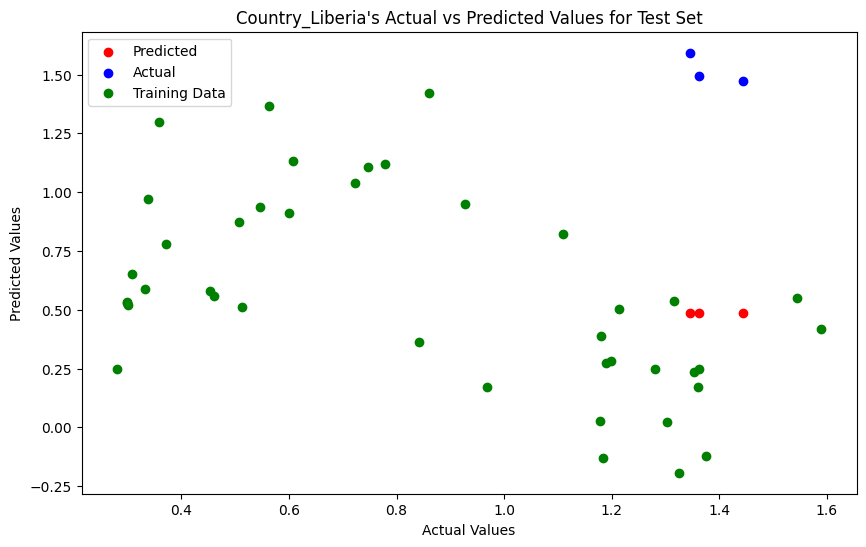

Epoch 1/100
8/8 [==============================] - 4s 109ms/step - loss: 0.1464 - mae: 0.4472 - val_loss: 0.2658 - val_mae: 0.6800
Epoch 2/100
8/8 [==============================] - 0s 28ms/step - loss: 0.1526 - mae: 0.4463 - val_loss: 0.2200 - val_mae: 0.6089
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1507 - mae: 0.4510 - val_loss: 0.1669 - val_mae: 0.5144
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1426 - mae: 0.4369 - val_loss: 0.2708 - val_mae: 0.6874
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1519 - mae: 0.4427 - val_loss: 0.2645 - val_mae: 0.6780
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 0.1441 - mae: 0.4366 - val_loss: 0.1806 - val_mae: 0.5403
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1539 - mae: 0.4609 - val_loss: 0.1833 - val_mae: 0.5453
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1488 - mae: 0.4

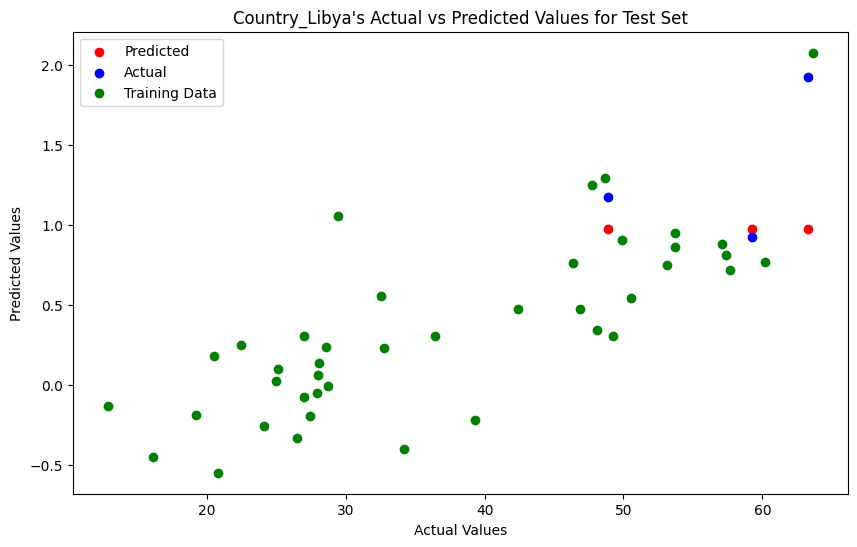

Epoch 1/100
8/8 [==============================] - 3s 83ms/step - loss: 0.0723 - mae: 0.3076 - val_loss: 0.1508 - val_mae: 0.5491
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0881 - mae: 0.3408 - val_loss: 0.0399 - val_mae: 0.2824
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0663 - mae: 0.2968 - val_loss: 0.0992 - val_mae: 0.4454
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0677 - mae: 0.3156 - val_loss: 0.0844 - val_mae: 0.4109
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0657 - mae: 0.2954 - val_loss: 0.0425 - val_mae: 0.2915
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0603 - mae: 0.2973 - val_loss: 0.1006 - val_mae: 0.4486
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0523 - mae: 0.2774 - val_loss: 0.0985 - val_mae: 0.4439
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0624 - mae: 0.28

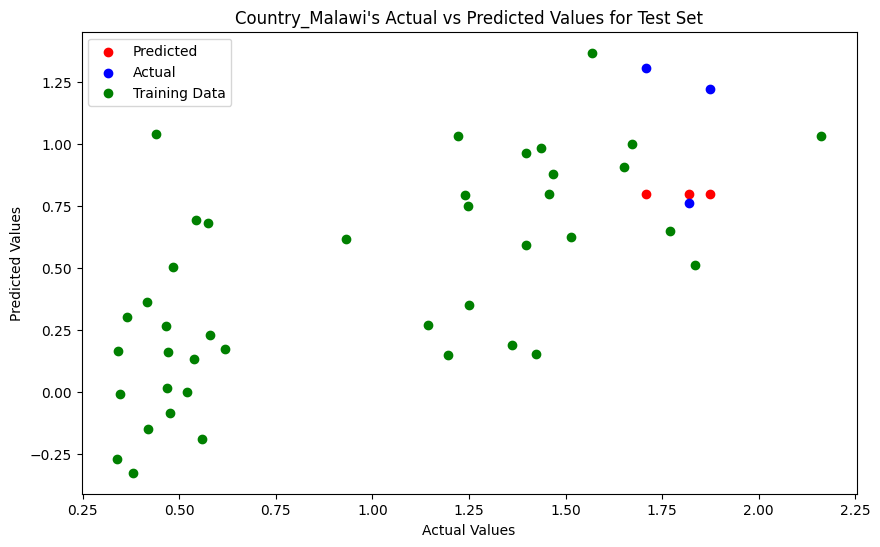

Epoch 1/100
8/8 [==============================] - 3s 78ms/step - loss: 0.0640 - mae: 0.2968 - val_loss: 0.4813 - val_mae: 0.9784
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0506 - mae: 0.2401 - val_loss: 0.1800 - val_mae: 0.5938
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0295 - mae: 0.1837 - val_loss: 0.1154 - val_mae: 0.4726
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0357 - mae: 0.2086 - val_loss: 0.2418 - val_mae: 0.6900
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0312 - mae: 0.2022 - val_loss: 0.1593 - val_mae: 0.5577
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0315 - mae: 0.2041 - val_loss: 0.2193 - val_mae: 0.6565
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0310 - mae: 0.1856 - val_loss: 0.1922 - val_mae: 0.6140
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0285 - mae: 0.17

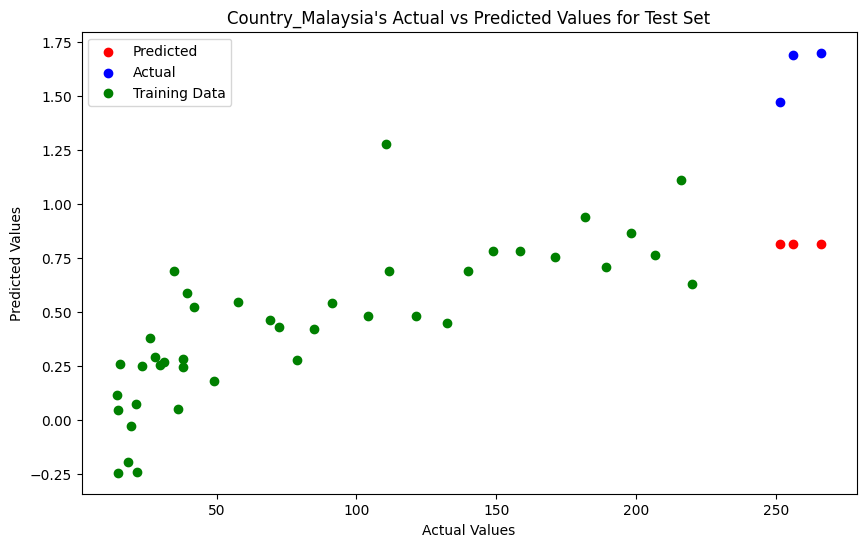

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 0.0555 - mae: 0.2736 - val_loss: 0.0696 - val_mae: 0.3563
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0444 - mae: 0.2386 - val_loss: 0.0690 - val_mae: 0.3580
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0385 - mae: 0.2201 - val_loss: 0.0677 - val_mae: 0.3546
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0331 - mae: 0.2109 - val_loss: 0.0641 - val_mae: 0.3453
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0315 - mae: 0.2055 - val_loss: 0.0509 - val_mae: 0.3047
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0280 - mae: 0.1886 - val_loss: 0.0641 - val_mae: 0.3474
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0296 - mae: 0.1910 - val_loss: 0.0721 - val_mae: 0.3710
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0320 - mae: 0.19

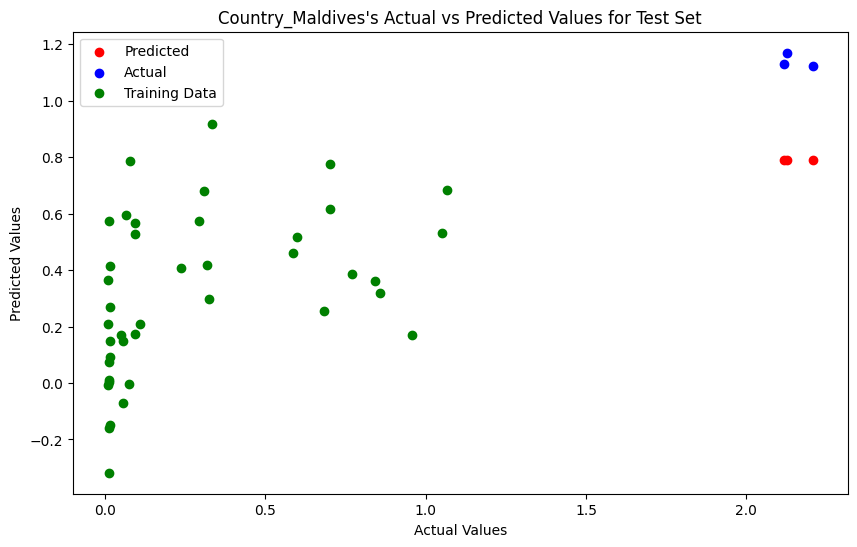

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.1056 - mae: 0.3649 - val_loss: 0.0089 - val_mae: 0.1151
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0873 - mae: 0.3474 - val_loss: 0.0197 - val_mae: 0.1613
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0650 - mae: 0.2974 - val_loss: 0.0098 - val_mae: 0.1156
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0680 - mae: 0.2856 - val_loss: 0.0677 - val_mae: 0.3493
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0600 - mae: 0.2873 - val_loss: 0.0566 - val_mae: 0.3162
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0616 - mae: 0.2861 - val_loss: 0.0583 - val_mae: 0.3213
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0525 - mae: 0.2597 - val_loss: 0.1074 - val_mae: 0.4490
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0587 - mae: 0.28

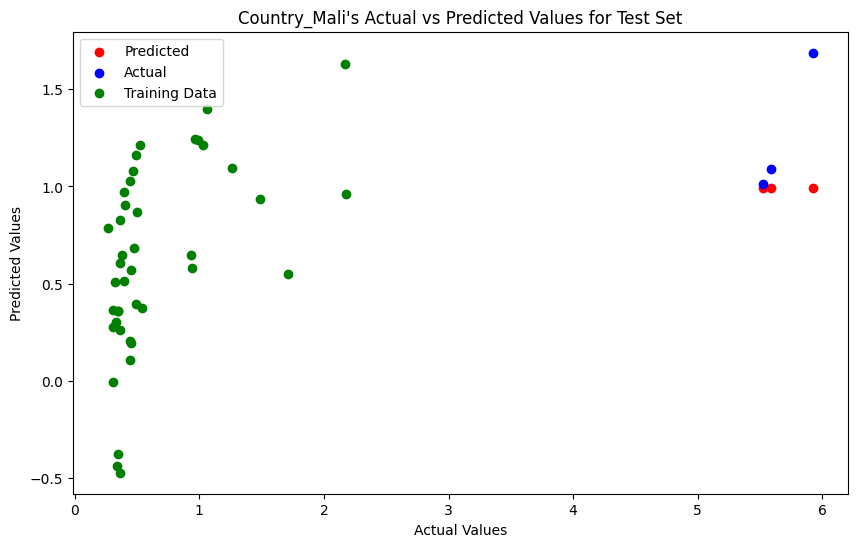

Epoch 1/100
8/8 [==============================] - 3s 83ms/step - loss: 0.1739 - mae: 0.4976 - val_loss: 0.3300 - val_mae: 0.8108
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1033 - mae: 0.3711 - val_loss: 0.0950 - val_mae: 0.4328
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0861 - mae: 0.3552 - val_loss: 0.0918 - val_mae: 0.4253
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1011 - mae: 0.3583 - val_loss: 0.3247 - val_mae: 0.8043
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1432 - mae: 0.4555 - val_loss: 0.2269 - val_mae: 0.6717
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0735 - mae: 0.3087 - val_loss: 0.0320 - val_mae: 0.2475
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0838 - mae: 0.3395 - val_loss: 0.2444 - val_mae: 0.6973
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 0.1089 - mae: 0.39

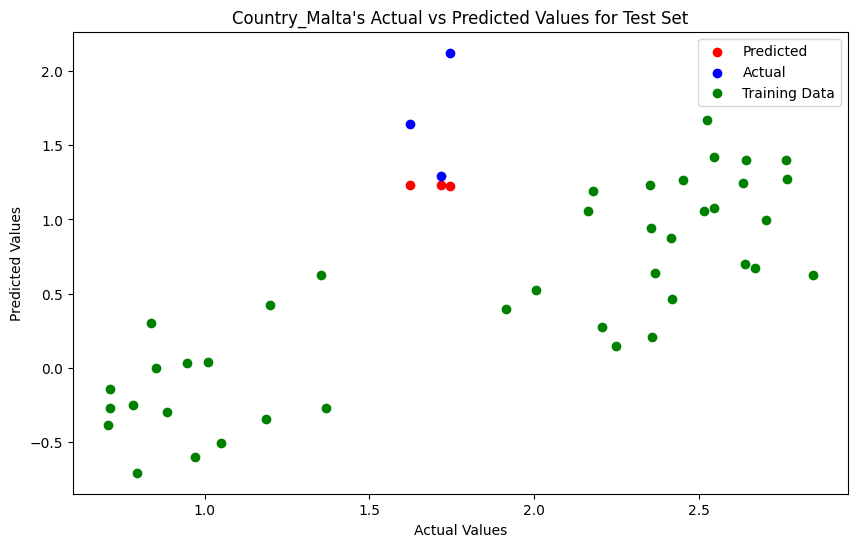

Epoch 1/100
8/8 [==============================] - 3s 82ms/step - loss: 0.0771 - mae: 0.3309 - val_loss: 0.0523 - val_mae: 0.3052
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0400 - mae: 0.2181 - val_loss: 0.0096 - val_mae: 0.1081
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0276 - mae: 0.1836 - val_loss: 0.0062 - val_mae: 0.1078
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0375 - mae: 0.2219 - val_loss: 0.0184 - val_mae: 0.1594
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0284 - mae: 0.1981 - val_loss: 0.0121 - val_mae: 0.1123
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0344 - mae: 0.2245 - val_loss: 0.0087 - val_mae: 0.1038
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0395 - mae: 0.2131 - val_loss: 0.0065 - val_mae: 0.1052
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0294 - mae: 0.19

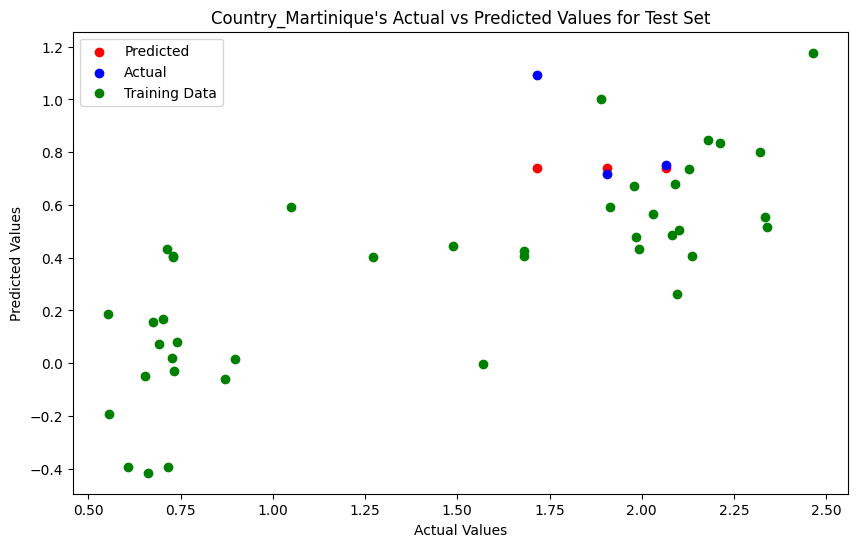

Epoch 1/100
8/8 [==============================] - 3s 81ms/step - loss: 0.1161 - mae: 0.3752 - val_loss: 0.0963 - val_mae: 0.4203
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0422 - mae: 0.2405 - val_loss: 0.0858 - val_mae: 0.3944
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0337 - mae: 0.2163 - val_loss: 0.1712 - val_mae: 0.5712
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0379 - mae: 0.2222 - val_loss: 0.1273 - val_mae: 0.4885
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0319 - mae: 0.2162 - val_loss: 0.0990 - val_mae: 0.4266
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0273 - mae: 0.1949 - val_loss: 0.1352 - val_mae: 0.5043
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0340 - mae: 0.2067 - val_loss: 0.1429 - val_mae: 0.5194
Epoch 8/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0308 - mae: 0.19

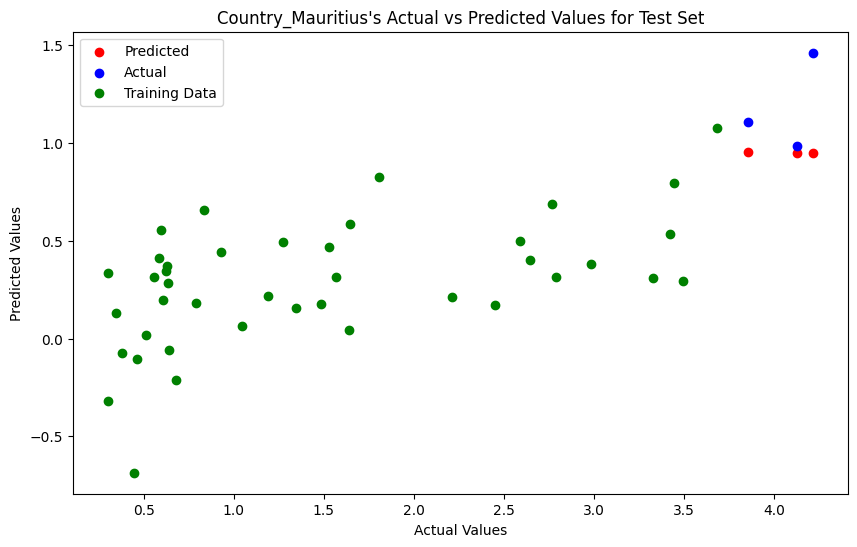

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.1519 - mae: 0.4519 - val_loss: 0.2364 - val_mae: 0.6780
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0786 - mae: 0.3185 - val_loss: 0.2549 - val_mae: 0.7047
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0718 - mae: 0.3169 - val_loss: 0.1945 - val_mae: 0.6131
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0673 - mae: 0.3079 - val_loss: 0.2746 - val_mae: 0.7321
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0725 - mae: 0.3191 - val_loss: 0.2395 - val_mae: 0.6825
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0727 - mae: 0.3183 - val_loss: 0.2601 - val_mae: 0.7120
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0728 - mae: 0.3197 - val_loss: 0.1888 - val_mae: 0.6037
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0679 - mae: 0.30

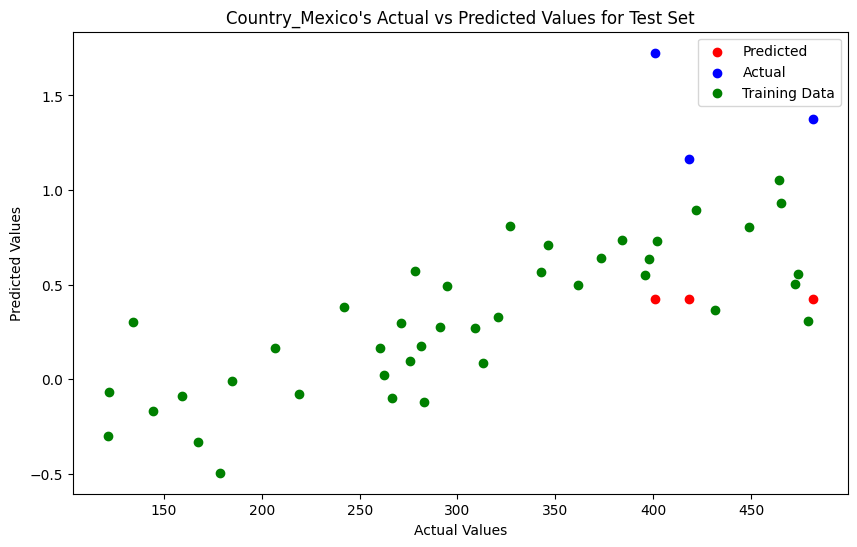

Epoch 1/100
8/8 [==============================] - 3s 88ms/step - loss: 0.3073 - mae: 0.6671 - val_loss: 0.4865 - val_mae: 0.9813
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.2513 - mae: 0.6047 - val_loss: 0.5432 - val_mae: 1.0414
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.2461 - mae: 0.5915 - val_loss: 0.5971 - val_mae: 1.0968
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.2438 - mae: 0.5902 - val_loss: 0.6419 - val_mae: 1.1419
Epoch 5/100
8/8 [==============================] - 0s 27ms/step - loss: 0.2479 - mae: 0.5967 - val_loss: 0.6003 - val_mae: 1.1001
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.2488 - mae: 0.5969 - val_loss: 0.6169 - val_mae: 1.1168
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.2559 - mae: 0.6018 - val_loss: 0.4953 - val_mae: 0.9907
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2612 - mae: 0.61

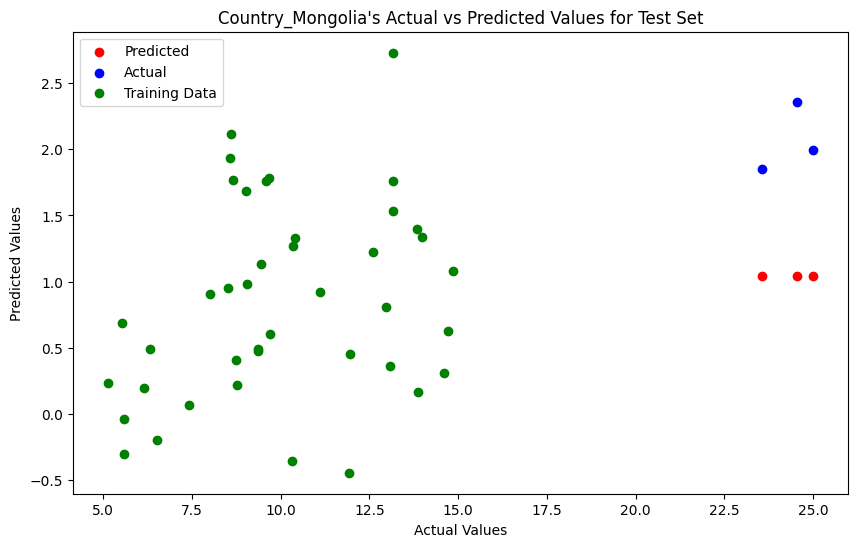

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.1974 - mae: 0.5023 - val_loss: 0.2126 - val_mae: 0.6047
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1833 - mae: 0.5140 - val_loss: 0.3436 - val_mae: 0.7926
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1857 - mae: 0.5189 - val_loss: 0.1630 - val_mae: 0.5162
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1834 - mae: 0.4857 - val_loss: 0.1332 - val_mae: 0.4549
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1469 - mae: 0.4262 - val_loss: 0.0993 - val_mae: 0.3729
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1026 - mae: 0.3525 - val_loss: 0.0298 - val_mae: 0.2440
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1042 - mae: 0.3696 - val_loss: 0.2850 - val_mae: 0.7144
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1699 - mae: 0.46

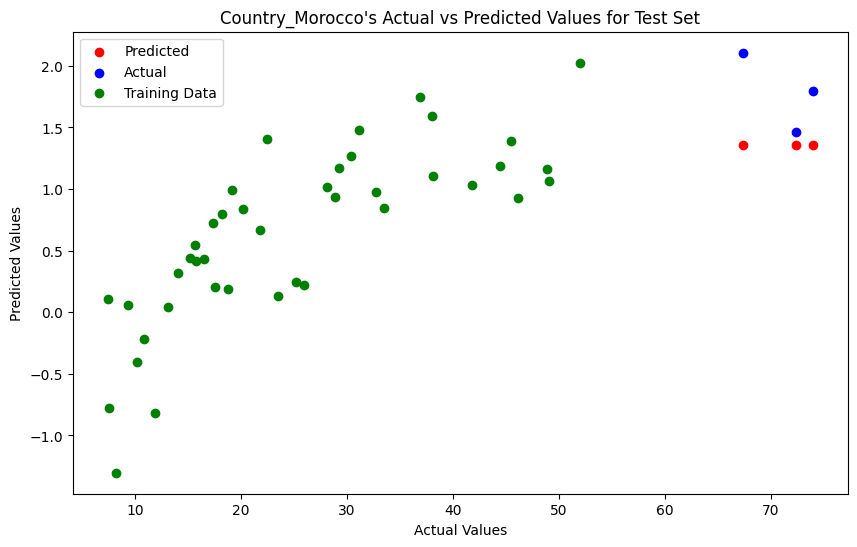

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.2163 - mae: 0.5174 - val_loss: 0.1449 - val_mae: 0.3824
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1340 - mae: 0.4477 - val_loss: 0.0760 - val_mae: 0.3878
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1474 - mae: 0.4342 - val_loss: 0.0876 - val_mae: 0.3879
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 0.1028 - mae: 0.3684 - val_loss: 0.0769 - val_mae: 0.3880
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 0.1125 - mae: 0.4016 - val_loss: 0.0819 - val_mae: 0.3878
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1006 - mae: 0.3609 - val_loss: 0.0771 - val_mae: 0.3878
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1003 - mae: 0.3828 - val_loss: 0.0767 - val_mae: 0.3878
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1099 - mae: 0.37

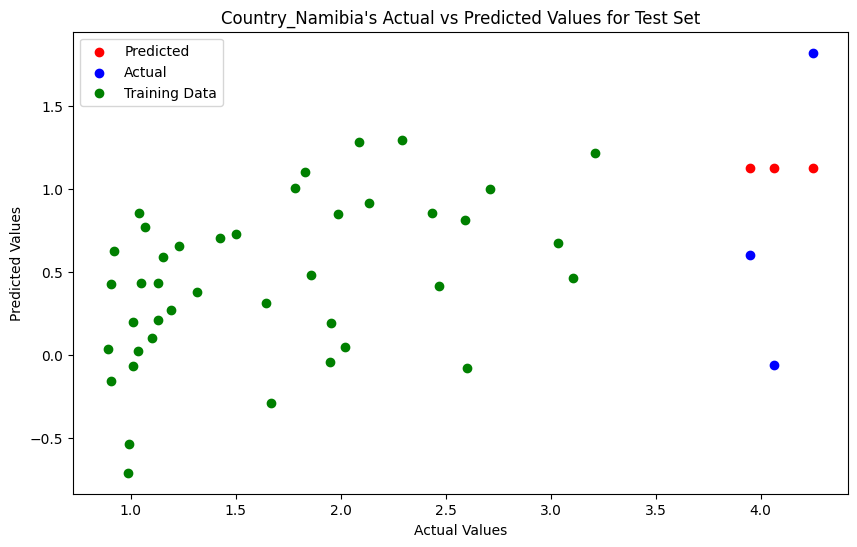

Epoch 1/100
8/8 [==============================] - 3s 78ms/step - loss: 0.0484 - mae: 0.2276 - val_loss: 0.0121 - val_mae: 0.1553
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0432 - mae: 0.2284 - val_loss: 0.0196 - val_mae: 0.1558
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0420 - mae: 0.2427 - val_loss: 0.0346 - val_mae: 0.2113
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0461 - mae: 0.2508 - val_loss: 0.0201 - val_mae: 0.1566
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0363 - mae: 0.2256 - val_loss: 0.0216 - val_mae: 0.1571
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0343 - mae: 0.2021 - val_loss: 0.0211 - val_mae: 0.1571
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0295 - mae: 0.1845 - val_loss: 0.0158 - val_mae: 0.1571
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0285 - mae: 0.18

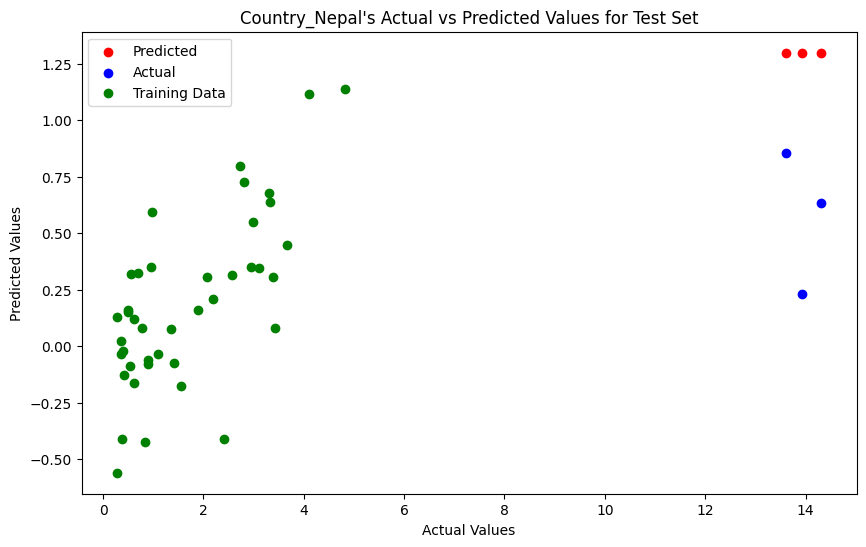

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.3182 - mae: 0.6927 - val_loss: 0.8284 - val_mae: 1.3000
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.2876 - mae: 0.6759 - val_loss: 0.6612 - val_mae: 1.0851
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.2838 - mae: 0.6628 - val_loss: 0.7004 - val_mae: 1.1382
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.2822 - mae: 0.6633 - val_loss: 0.7788 - val_mae: 1.2392
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.2877 - mae: 0.6722 - val_loss: 0.6905 - val_mae: 1.1250
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.2934 - mae: 0.6816 - val_loss: 0.7522 - val_mae: 1.2057
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 0.3127 - mae: 0.6964 - val_loss: 0.6382 - val_mae: 1.0529
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.3034 - mae: 0.69

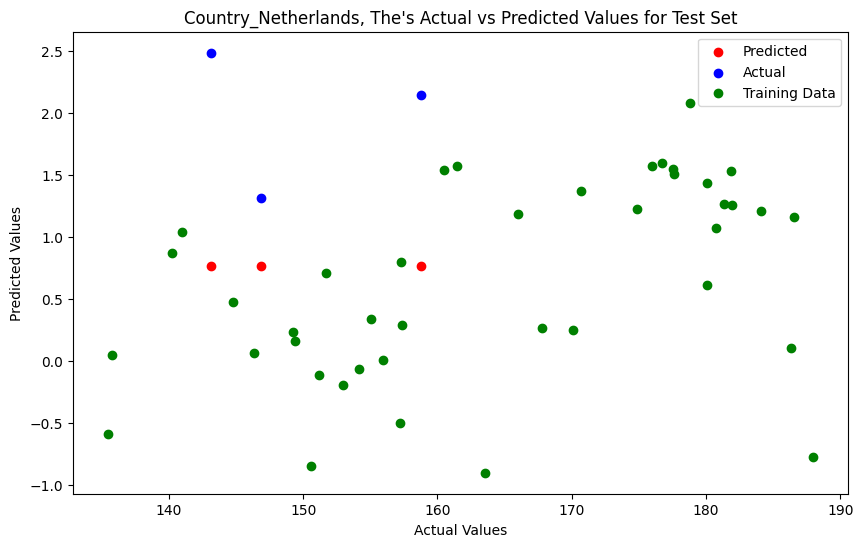

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.0876 - mae: 0.3323 - val_loss: 0.0731 - val_mae: 0.3682
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0848 - mae: 0.3271 - val_loss: 0.0476 - val_mae: 0.2908
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0820 - mae: 0.3023 - val_loss: 0.0259 - val_mae: 0.2012
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0569 - mae: 0.2539 - val_loss: 0.0315 - val_mae: 0.2285
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0599 - mae: 0.2577 - val_loss: 0.0202 - val_mae: 0.1702
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0648 - mae: 0.2766 - val_loss: 0.0207 - val_mae: 0.1735
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0549 - mae: 0.2564 - val_loss: 0.0349 - val_mae: 0.2426
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0700 - mae: 0.28

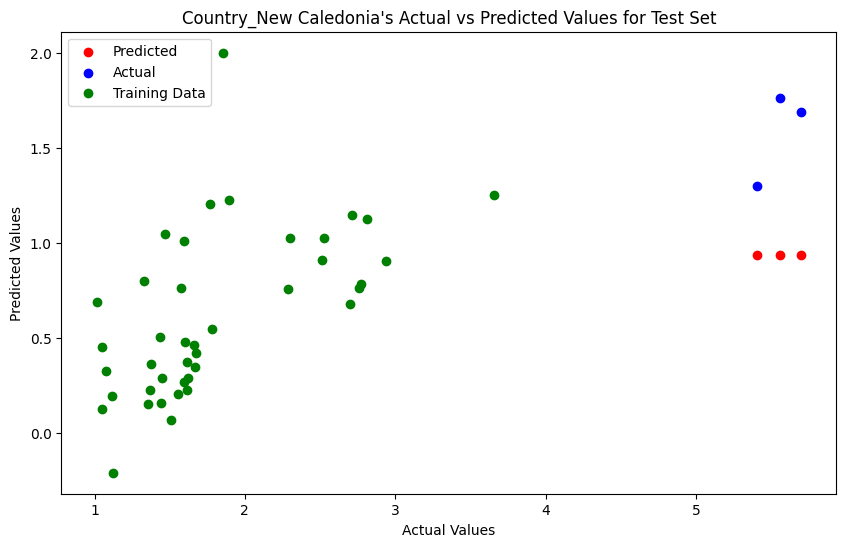

Epoch 1/100
8/8 [==============================] - 3s 81ms/step - loss: 0.1811 - mae: 0.5199 - val_loss: 0.1660 - val_mae: 0.5760
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0927 - mae: 0.3313 - val_loss: 0.0301 - val_mae: 0.2451
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0756 - mae: 0.3143 - val_loss: 0.0728 - val_mae: 0.3813
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0729 - mae: 0.3002 - val_loss: 0.0449 - val_mae: 0.2993
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0763 - mae: 0.3200 - val_loss: 0.0574 - val_mae: 0.3385
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0694 - mae: 0.2908 - val_loss: 0.0354 - val_mae: 0.2658
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0749 - mae: 0.2957 - val_loss: 0.0419 - val_mae: 0.2892
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0722 - mae: 0.29

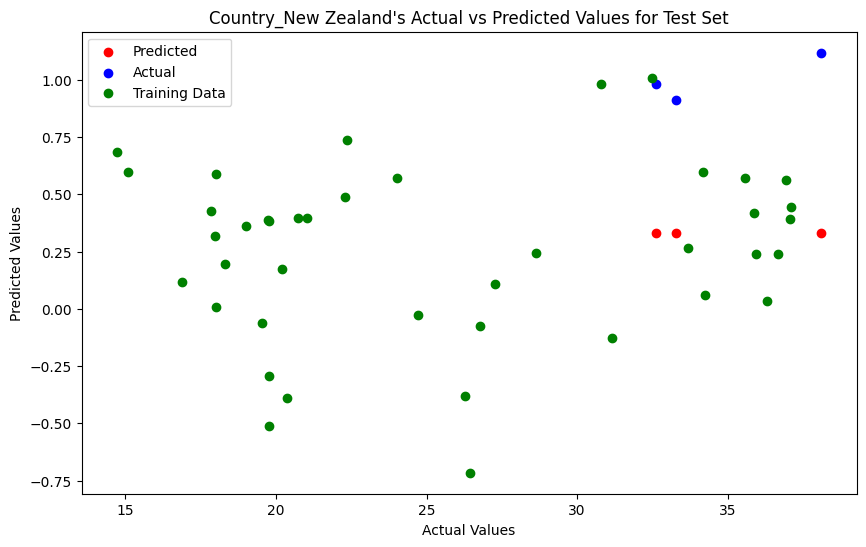

Epoch 1/100
8/8 [==============================] - 3s 86ms/step - loss: 0.0582 - mae: 0.2912 - val_loss: 0.1136 - val_mae: 0.4653
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0458 - mae: 0.2608 - val_loss: 0.0902 - val_mae: 0.4139
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0396 - mae: 0.2438 - val_loss: 0.0215 - val_mae: 0.1822
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0517 - mae: 0.2678 - val_loss: 0.0629 - val_mae: 0.3399
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0451 - mae: 0.2514 - val_loss: 0.0449 - val_mae: 0.2809
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0392 - mae: 0.2367 - val_loss: 0.0525 - val_mae: 0.3065
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0388 - mae: 0.2335 - val_loss: 0.0281 - val_mae: 0.2127
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0399 - mae: 0.23

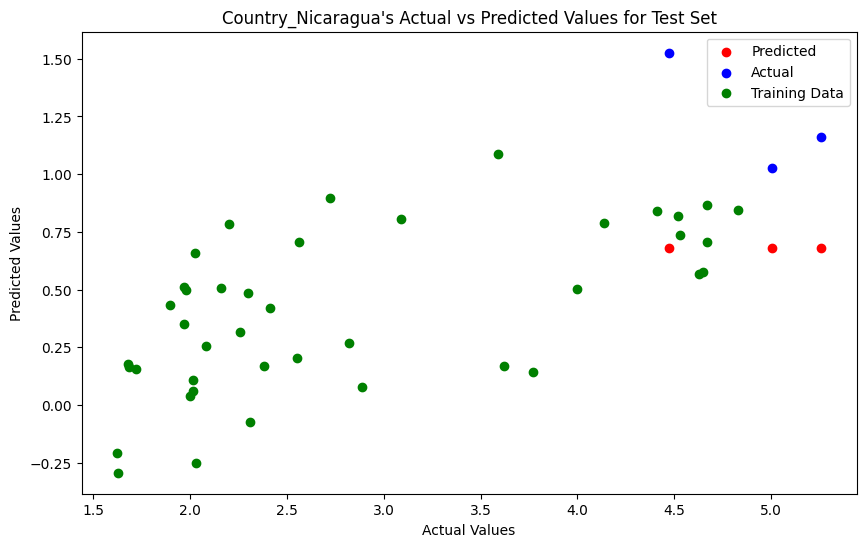

Epoch 1/100
8/8 [==============================] - 3s 118ms/step - loss: 0.0989 - mae: 0.3427 - val_loss: 0.1153 - val_mae: 0.4752
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 0.1259 - mae: 0.3930 - val_loss: 0.1119 - val_mae: 0.4706
Epoch 3/100
8/8 [==============================] - 0s 35ms/step - loss: 0.0900 - mae: 0.3367 - val_loss: 0.0685 - val_mae: 0.3651
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0830 - mae: 0.3344 - val_loss: 0.0253 - val_mae: 0.2158
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0789 - mae: 0.3239 - val_loss: 0.0372 - val_mae: 0.2640
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0756 - mae: 0.3106 - val_loss: 0.0186 - val_mae: 0.1757
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0689 - mae: 0.2944 - val_loss: 0.0057 - val_mae: 0.0841
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1373 - mae: 0.4

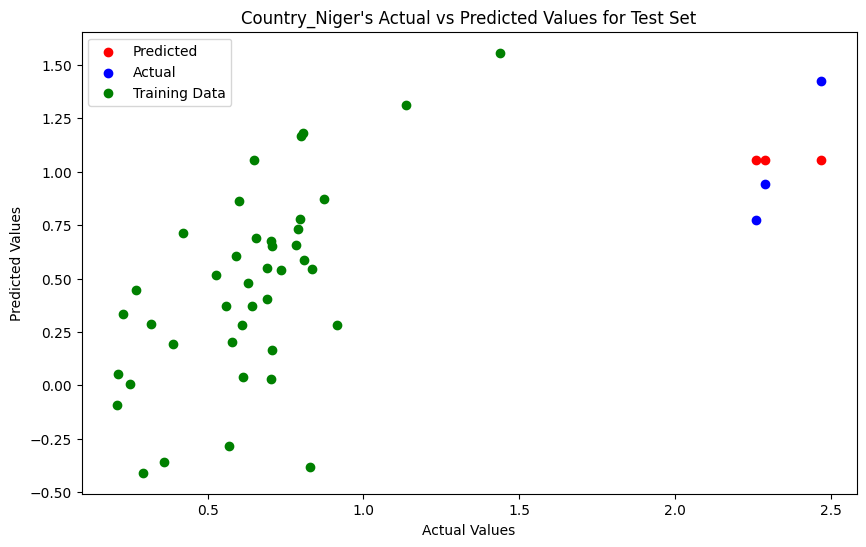

Epoch 1/100
8/8 [==============================] - 5s 82ms/step - loss: 0.1509 - mae: 0.4711 - val_loss: 0.2498 - val_mae: 0.7014
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1079 - mae: 0.3625 - val_loss: 0.1255 - val_mae: 0.4933
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0848 - mae: 0.3166 - val_loss: 0.1912 - val_mae: 0.6122
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0840 - mae: 0.3139 - val_loss: 0.1403 - val_mae: 0.5224
Epoch 5/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0842 - mae: 0.3189 - val_loss: 0.1910 - val_mae: 0.6119
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 0.0845 - mae: 0.3195 - val_loss: 0.1493 - val_mae: 0.5394
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0830 - mae: 0.3165 - val_loss: 0.1864 - val_mae: 0.6043
Epoch 8/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0830 - mae: 0.31

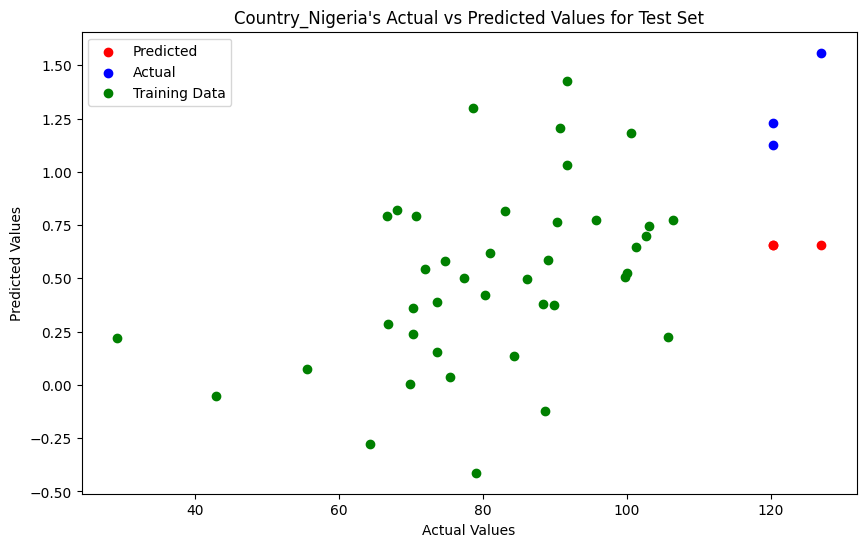

Epoch 1/100
8/8 [==============================] - 4s 123ms/step - loss: 0.3149 - mae: 0.6946 - val_loss: 0.9663 - val_mae: 1.4663
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.3177 - mae: 0.7026 - val_loss: 0.9862 - val_mae: 1.4862
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.3197 - mae: 0.6892 - val_loss: 0.8153 - val_mae: 1.3153
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3095 - mae: 0.6878 - val_loss: 0.9820 - val_mae: 1.4820
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.3119 - mae: 0.6934 - val_loss: 1.0192 - val_mae: 1.5192
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3122 - mae: 0.6978 - val_loss: 0.9119 - val_mae: 1.4119
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.3126 - mae: 0.6750 - val_loss: 0.9258 - val_mae: 1.4258
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.3289 - mae: 0.6

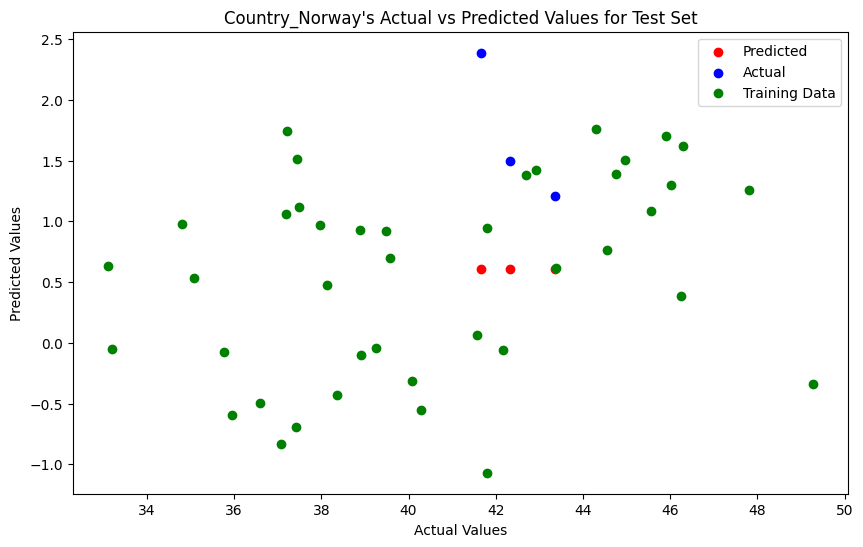

Epoch 1/100
8/8 [==============================] - 3s 82ms/step - loss: 0.1545 - mae: 0.4722 - val_loss: 0.2864 - val_mae: 0.6638
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1344 - mae: 0.4281 - val_loss: 0.4030 - val_mae: 0.8323
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1105 - mae: 0.3987 - val_loss: 0.1994 - val_mae: 0.5161
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1294 - mae: 0.4430 - val_loss: 0.2119 - val_mae: 0.5396
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 0.1161 - mae: 0.4095 - val_loss: 0.3668 - val_mae: 0.7821
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1196 - mae: 0.3972 - val_loss: 0.2970 - val_mae: 0.6801
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1279 - mae: 0.4408 - val_loss: 0.2198 - val_mae: 0.5542
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1178 - mae: 0.40

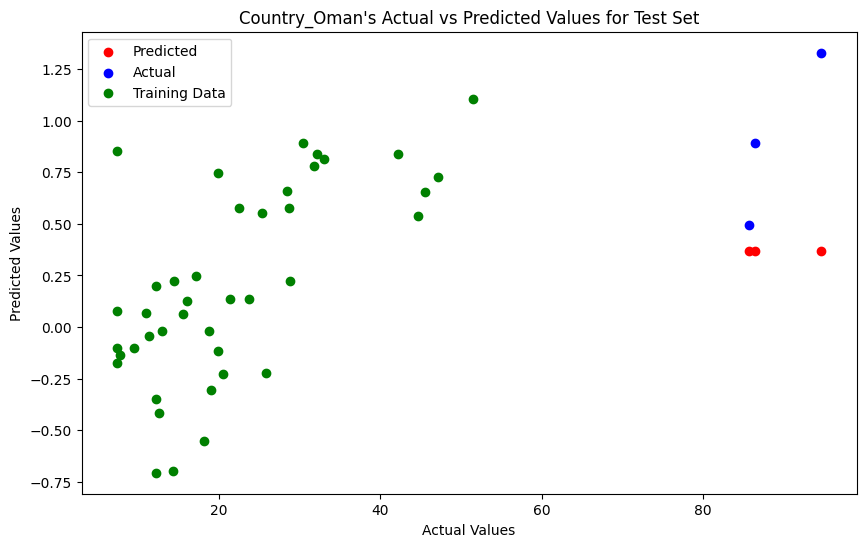

Epoch 1/100
8/8 [==============================] - 3s 86ms/step - loss: 0.1261 - mae: 0.4200 - val_loss: 0.0258 - val_mae: 0.2104
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1296 - mae: 0.4311 - val_loss: 0.0458 - val_mae: 0.2905
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1207 - mae: 0.4179 - val_loss: 0.0114 - val_mae: 0.1242
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1338 - mae: 0.4372 - val_loss: 0.0119 - val_mae: 0.1281
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1297 - mae: 0.4258 - val_loss: 0.0667 - val_mae: 0.3552
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1312 - mae: 0.4302 - val_loss: 0.0292 - val_mae: 0.2261
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1449 - mae: 0.4628 - val_loss: 0.0062 - val_mae: 0.0855
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1325 - mae: 0.42

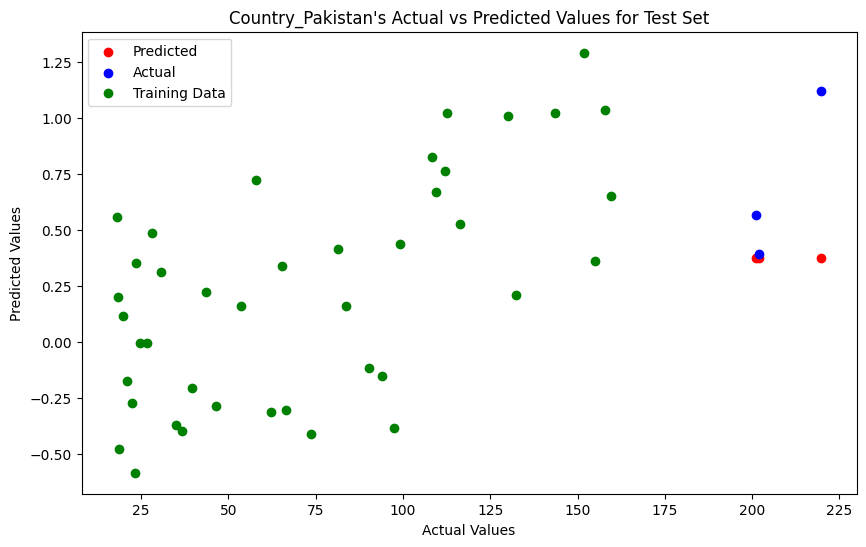

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.0674 - mae: 0.3009 - val_loss: 0.2584 - val_mae: 0.7106
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0683 - mae: 0.3017 - val_loss: 0.2870 - val_mae: 0.7498
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0658 - mae: 0.3007 - val_loss: 0.2436 - val_mae: 0.6894
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0681 - mae: 0.2980 - val_loss: 0.2296 - val_mae: 0.6689
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0658 - mae: 0.2924 - val_loss: 0.2820 - val_mae: 0.7431
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0683 - mae: 0.3064 - val_loss: 0.3144 - val_mae: 0.7855
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0718 - mae: 0.3093 - val_loss: 0.2492 - val_mae: 0.6976
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0680 - mae: 0.30

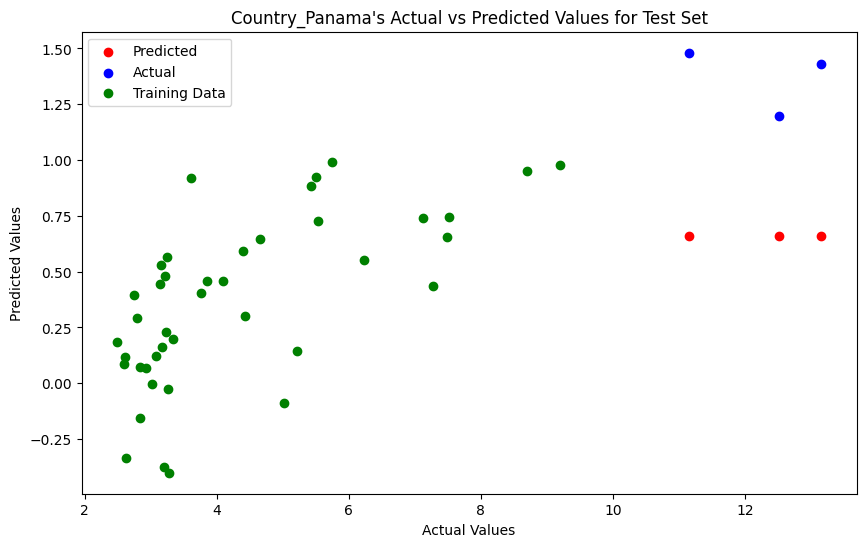

Epoch 1/100
8/8 [==============================] - 3s 81ms/step - loss: 0.0488 - mae: 0.2590 - val_loss: 0.0577 - val_mae: 0.3100
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0229 - mae: 0.1700 - val_loss: 0.0462 - val_mae: 0.2720
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0205 - mae: 0.1602 - val_loss: 0.0445 - val_mae: 0.2700
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0221 - mae: 0.1664 - val_loss: 0.0332 - val_mae: 0.2256
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0270 - mae: 0.1785 - val_loss: 0.0315 - val_mae: 0.2185
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0234 - mae: 0.1759 - val_loss: 0.0382 - val_mae: 0.2476
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0182 - mae: 0.1505 - val_loss: 0.0279 - val_mae: 0.2012
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0179 - mae: 0.14

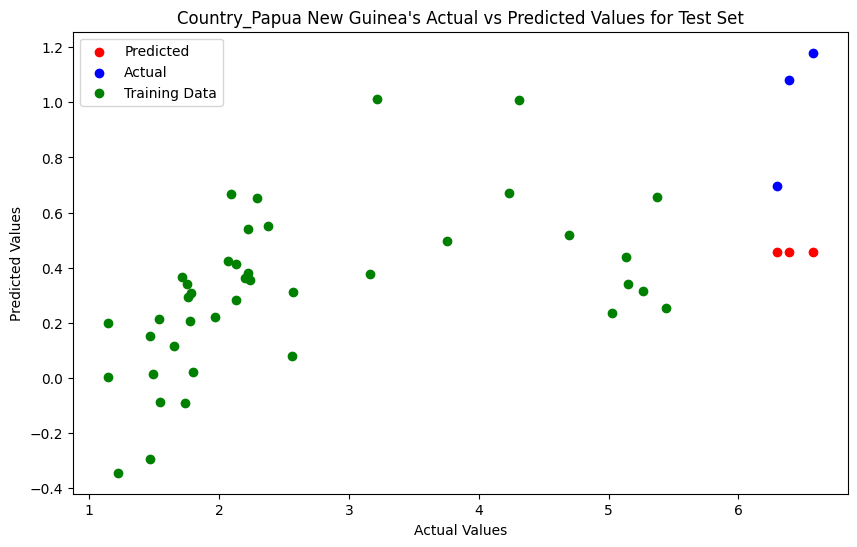

Epoch 1/100
8/8 [==============================] - 3s 120ms/step - loss: 0.0794 - mae: 0.3313 - val_loss: 0.4121 - val_mae: 0.8901
Epoch 2/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0791 - mae: 0.3198 - val_loss: 0.4288 - val_mae: 0.9096
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0660 - mae: 0.2916 - val_loss: 0.3110 - val_mae: 0.7663
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 0.0773 - mae: 0.3461 - val_loss: 0.3702 - val_mae: 0.8401
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0829 - mae: 0.3500 - val_loss: 0.3590 - val_mae: 0.8265
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0764 - mae: 0.3254 - val_loss: 0.4742 - val_mae: 0.9614
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0578 - mae: 0.2739 - val_loss: 0.3390 - val_mae: 0.8018
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0657 - mae: 0.3

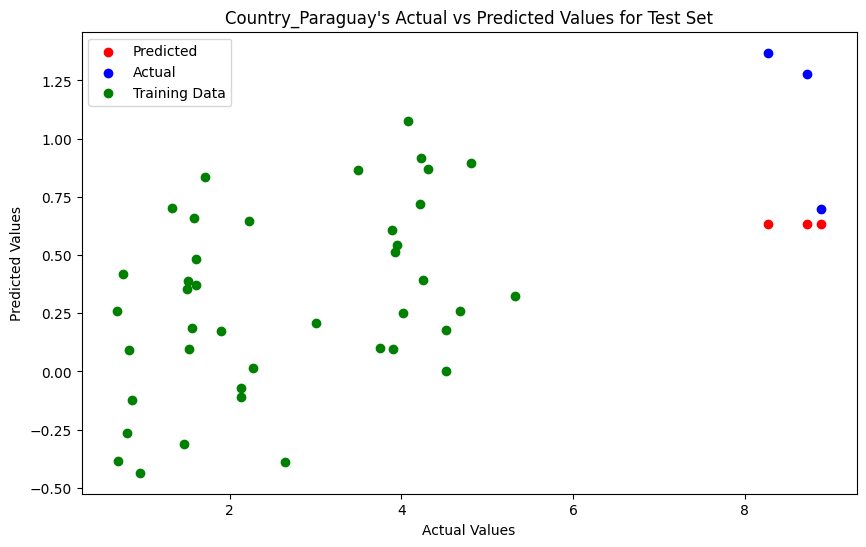

Epoch 1/100
8/8 [==============================] - 3s 78ms/step - loss: 0.0742 - mae: 0.3274 - val_loss: 0.2508 - val_mae: 0.6832
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0752 - mae: 0.3152 - val_loss: 0.1797 - val_mae: 0.5698
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0695 - mae: 0.3071 - val_loss: 0.1293 - val_mae: 0.4732
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0688 - mae: 0.3043 - val_loss: 0.1309 - val_mae: 0.4764
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0636 - mae: 0.2873 - val_loss: 0.1209 - val_mae: 0.4551
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0653 - mae: 0.2970 - val_loss: 0.1466 - val_mae: 0.5117
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1139 - mae: 0.3866 - val_loss: 0.2835 - val_mae: 0.7296
Epoch 8/100
8/8 [==============================] - 0s 28ms/step - loss: 0.1091 - mae: 0.37

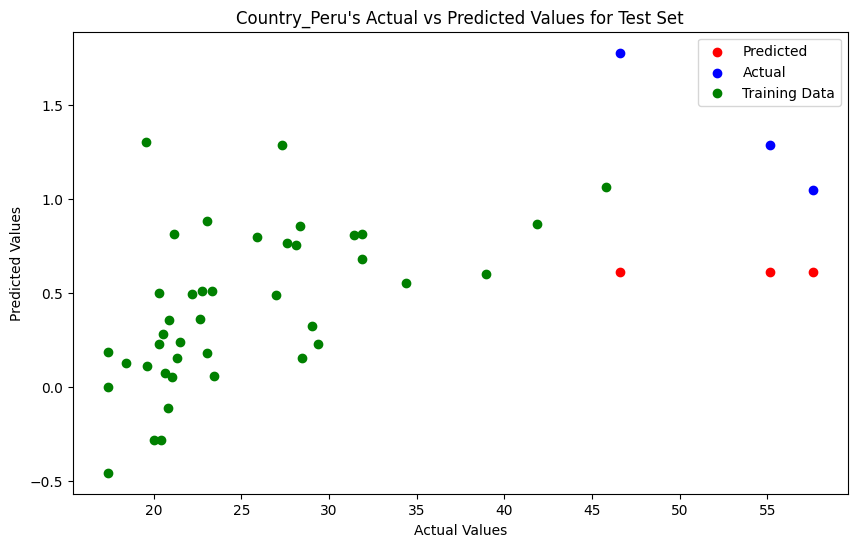

Epoch 1/100
8/8 [==============================] - 3s 123ms/step - loss: 0.0423 - mae: 0.2239 - val_loss: 0.0783 - val_mae: 0.3836
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0591 - mae: 0.2869 - val_loss: 0.2360 - val_mae: 0.6801
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0450 - mae: 0.2359 - val_loss: 0.1179 - val_mae: 0.4757
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0506 - mae: 0.2594 - val_loss: 0.1836 - val_mae: 0.5981
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0513 - mae: 0.2486 - val_loss: 0.2113 - val_mae: 0.6428
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0476 - mae: 0.2487 - val_loss: 0.1355 - val_mae: 0.5113
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0500 - mae: 0.2602 - val_loss: 0.1701 - val_mae: 0.5750
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0545 - mae: 0.2

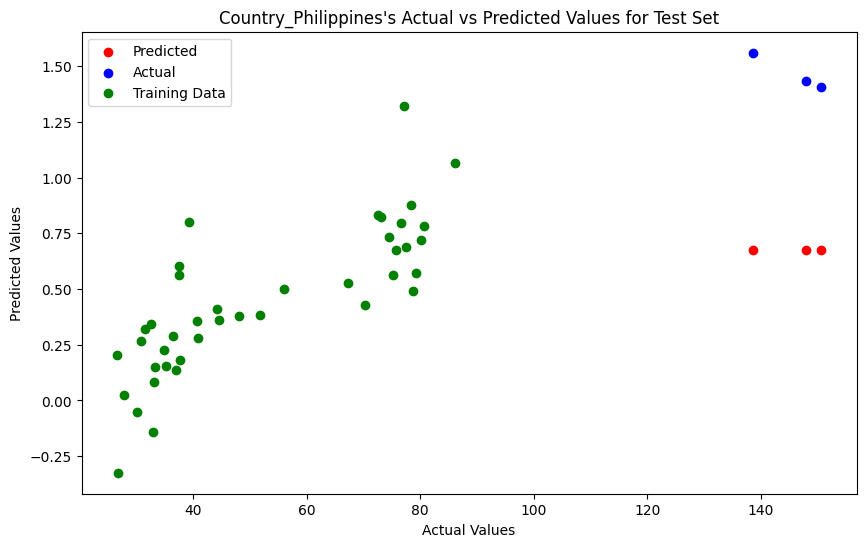

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.1317 - mae: 0.4055 - val_loss: 0.2008 - val_mae: 0.6332
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1535 - mae: 0.4559 - val_loss: 0.0428 - val_mae: 0.2913
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 0.2251 - mae: 0.5625 - val_loss: 0.2722 - val_mae: 0.7373
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1692 - mae: 0.4645 - val_loss: 0.3044 - val_mae: 0.7797
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1906 - mae: 0.5001 - val_loss: 0.2574 - val_mae: 0.7169
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1796 - mae: 0.4917 - val_loss: 0.3775 - val_mae: 0.8684
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1809 - mae: 0.4986 - val_loss: 0.1985 - val_mae: 0.6294
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 0.1744 - mae: 0.47

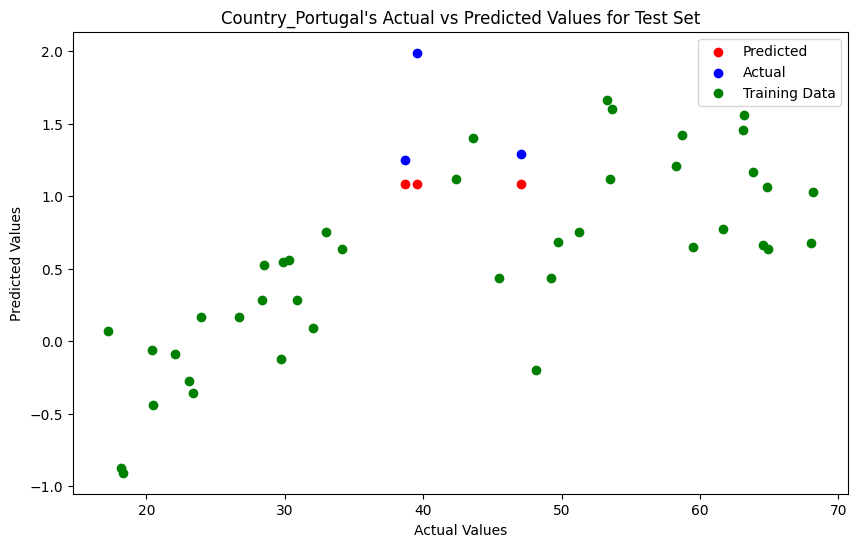

Epoch 1/100
8/8 [==============================] - 3s 118ms/step - loss: 0.1400 - mae: 0.4352 - val_loss: 0.0371 - val_mae: 0.2482
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0534 - mae: 0.2775 - val_loss: 0.0091 - val_mae: 0.1143
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0361 - mae: 0.2256 - val_loss: 0.0095 - val_mae: 0.1164
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0369 - mae: 0.2256 - val_loss: 0.0194 - val_mae: 0.1586
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0424 - mae: 0.2363 - val_loss: 0.0145 - val_mae: 0.1223
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0394 - mae: 0.2260 - val_loss: 0.0150 - val_mae: 0.1255
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0337 - mae: 0.2047 - val_loss: 0.0217 - val_mae: 0.1713
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0340 - mae: 0.2

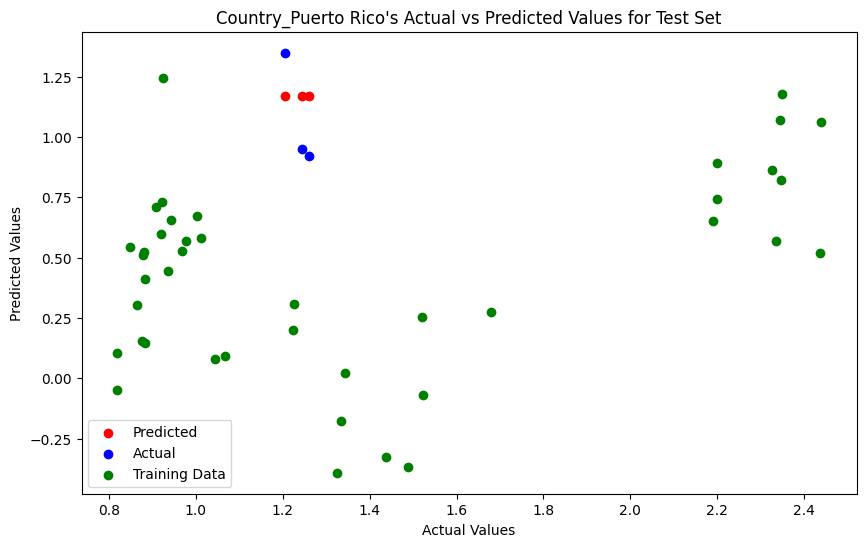

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.2757 - mae: 0.6126 - val_loss: 0.8962 - val_mae: 1.3962
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.2283 - mae: 0.5553 - val_loss: 0.7778 - val_mae: 1.2778
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 0.2222 - mae: 0.5648 - val_loss: 0.6566 - val_mae: 1.1557
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.2211 - mae: 0.5628 - val_loss: 0.8283 - val_mae: 1.3283
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.2347 - mae: 0.5656 - val_loss: 0.9330 - val_mae: 1.4330
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2208 - mae: 0.5406 - val_loss: 0.7034 - val_mae: 1.2033
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.2479 - mae: 0.6035 - val_loss: 0.6880 - val_mae: 1.1878
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 0.2276 - mae: 0.55

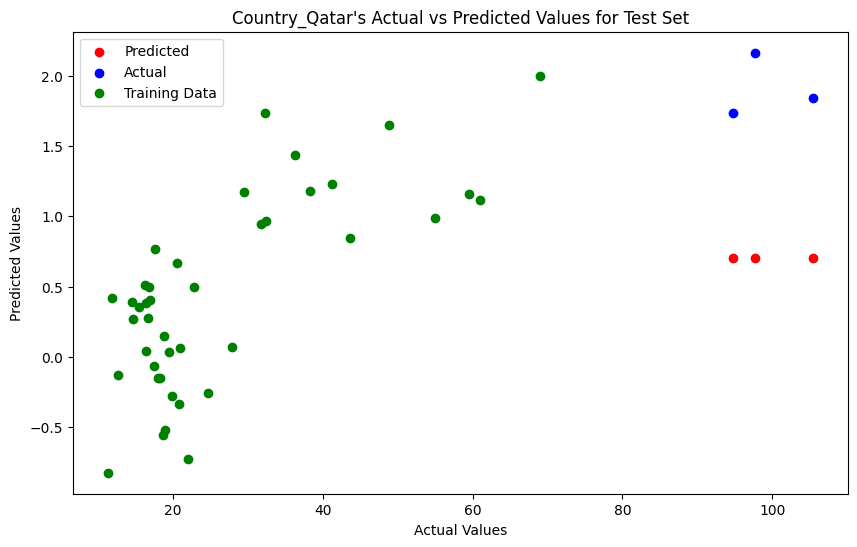

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.3117 - mae: 0.6741 - val_loss: 0.7887 - val_mae: 1.2887
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2959 - mae: 0.6417 - val_loss: 0.9431 - val_mae: 1.4431
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2913 - mae: 0.6393 - val_loss: 0.7970 - val_mae: 1.2970
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3264 - mae: 0.6865 - val_loss: 0.6440 - val_mae: 1.1440
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.3006 - mae: 0.6605 - val_loss: 0.9035 - val_mae: 1.4035
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3000 - mae: 0.6534 - val_loss: 0.6999 - val_mae: 1.1999
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3235 - mae: 0.6834 - val_loss: 0.7823 - val_mae: 1.2823
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.3123 - mae: 0.67

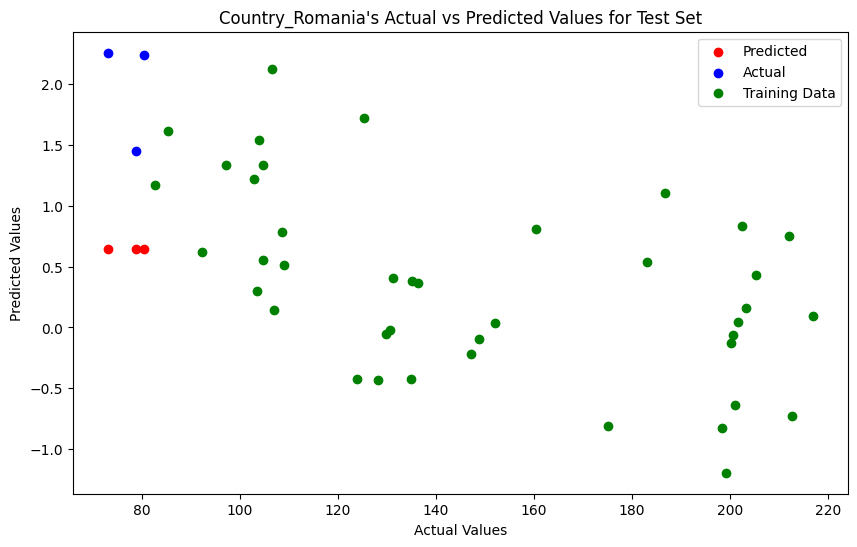

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.2974 - mae: 0.6565 - val_loss: 0.0851 - val_mae: 0.3917
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 0.2889 - mae: 0.6477 - val_loss: 0.0114 - val_mae: 0.1255
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.2833 - mae: 0.6309 - val_loss: 0.0083 - val_mae: 0.1255
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3452 - mae: 0.7230 - val_loss: 0.0090 - val_mae: 0.1307
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.3323 - mae: 0.6807 - val_loss: 0.0182 - val_mae: 0.1649
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.2944 - mae: 0.6572 - val_loss: 0.0581 - val_mae: 0.3102
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.3014 - mae: 0.6683 - val_loss: 0.1222 - val_mae: 0.4754
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 0.3098 - mae: 0.65

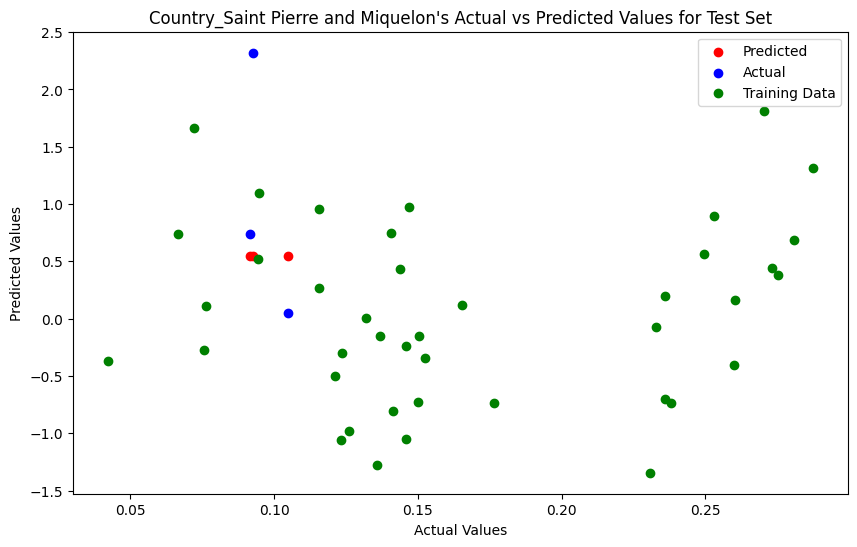

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.1097 - mae: 0.3885 - val_loss: 0.1054 - val_mae: 0.4522
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0943 - mae: 0.3565 - val_loss: 0.1374 - val_mae: 0.5184
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0667 - mae: 0.3147 - val_loss: 0.0035 - val_mae: 0.0804
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0750 - mae: 0.3124 - val_loss: 0.0174 - val_mae: 0.1681
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0888 - mae: 0.3424 - val_loss: 0.1925 - val_mae: 0.6154
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1070 - mae: 0.3770 - val_loss: 0.0709 - val_mae: 0.3681
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0793 - mae: 0.3303 - val_loss: 0.0492 - val_mae: 0.3038
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0661 - mae: 0.29

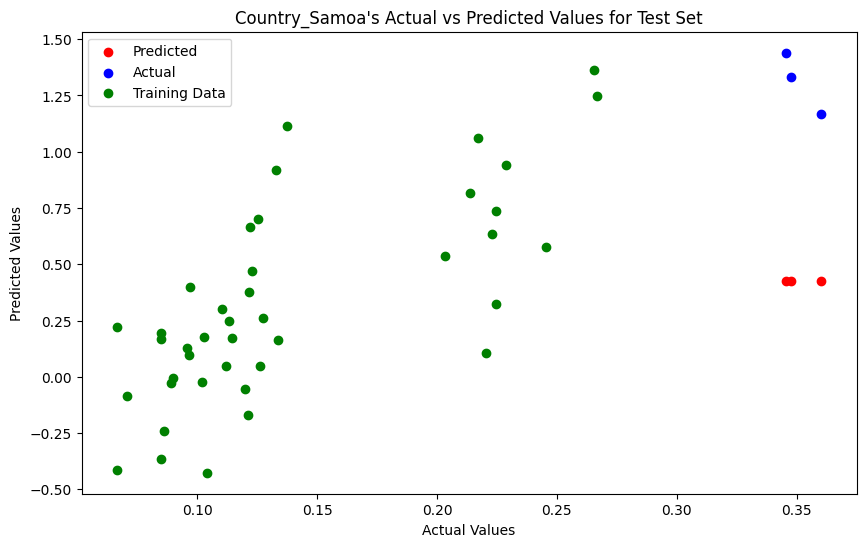

Epoch 1/100
8/8 [==============================] - 3s 78ms/step - loss: 0.2080 - mae: 0.5462 - val_loss: 0.7393 - val_mae: 1.2380
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 0.2128 - mae: 0.5527 - val_loss: 0.7479 - val_mae: 1.2470
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.2041 - mae: 0.5464 - val_loss: 0.5855 - val_mae: 1.0714
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.2095 - mae: 0.5475 - val_loss: 0.7543 - val_mae: 1.2536
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.2148 - mae: 0.5452 - val_loss: 0.8745 - val_mae: 1.3745
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2070 - mae: 0.5468 - val_loss: 0.6646 - val_mae: 1.1589
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.2229 - mae: 0.5697 - val_loss: 0.6397 - val_mae: 1.1319
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.2138 - mae: 0.55

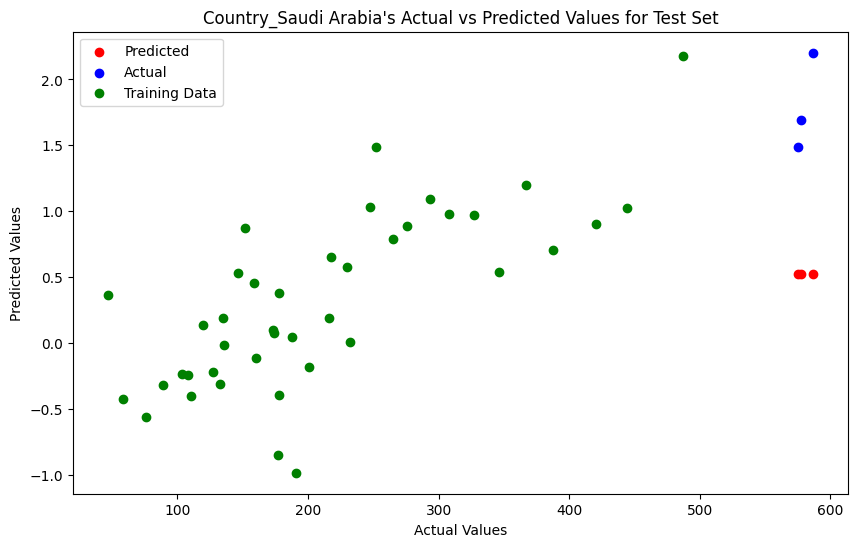

Epoch 1/100
8/8 [==============================] - 3s 91ms/step - loss: 0.1293 - mae: 0.4202 - val_loss: 0.0228 - val_mae: 0.2066
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0913 - mae: 0.3425 - val_loss: 0.0281 - val_mae: 0.2310
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0625 - mae: 0.2985 - val_loss: 0.0015 - val_mae: 0.0535
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0668 - mae: 0.2955 - val_loss: 0.0040 - val_mae: 0.0712
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0622 - mae: 0.3044 - val_loss: 0.0126 - val_mae: 0.1492
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0466 - mae: 0.2590 - val_loss: 0.0033 - val_mae: 0.0611
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0464 - mae: 0.2484 - val_loss: 0.0018 - val_mae: 0.0535
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0576 - mae: 0.27

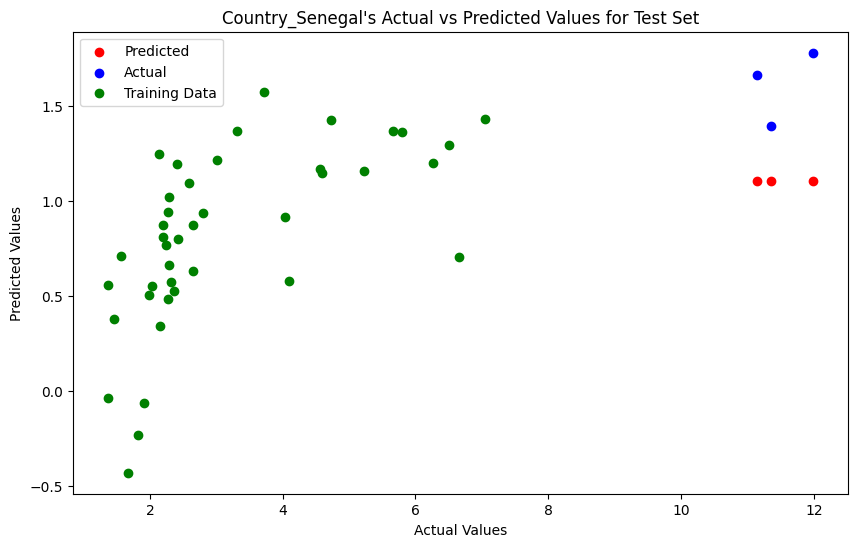

Epoch 1/100
8/8 [==============================] - 3s 79ms/step - loss: 0.1033 - mae: 0.3720 - val_loss: 0.1830 - val_mae: 0.5797
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0684 - mae: 0.3015 - val_loss: 0.1284 - val_mae: 0.4790
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0517 - mae: 0.2665 - val_loss: 0.1325 - val_mae: 0.4822
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0522 - mae: 0.2579 - val_loss: 0.1483 - val_mae: 0.5211
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0369 - mae: 0.2311 - val_loss: 0.1066 - val_mae: 0.4331
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0318 - mae: 0.2127 - val_loss: 0.1632 - val_mae: 0.5491
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0341 - mae: 0.2013 - val_loss: 0.1325 - val_mae: 0.4909
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0356 - mae: 0.22

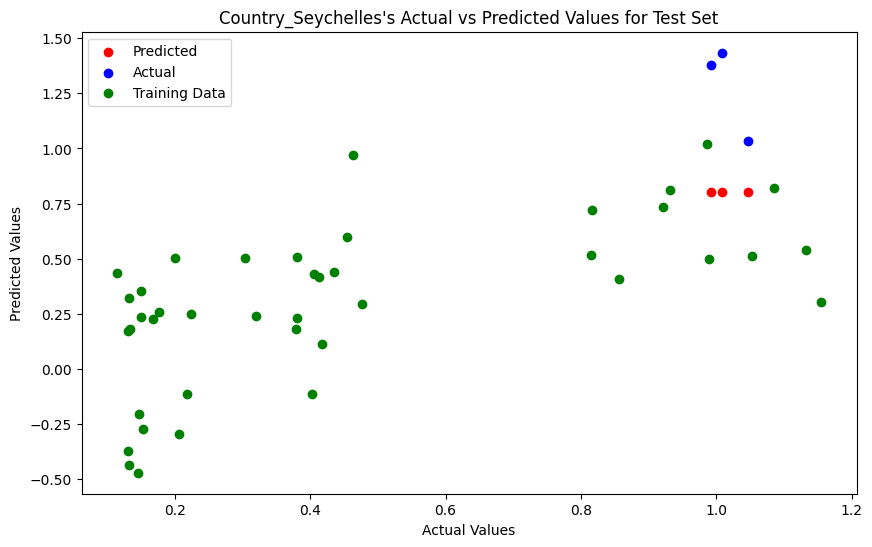

Epoch 1/100
8/8 [==============================] - 3s 107ms/step - loss: 0.0915 - mae: 0.3491 - val_loss: 0.1101 - val_mae: 0.4691
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0506 - mae: 0.2663 - val_loss: 0.1363 - val_mae: 0.5214
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0628 - mae: 0.2838 - val_loss: 0.3057 - val_mae: 0.7816
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0647 - mae: 0.2975 - val_loss: 0.1533 - val_mae: 0.5537
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0373 - mae: 0.2207 - val_loss: 0.0591 - val_mae: 0.3386
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0328 - mae: 0.2036 - val_loss: 0.1195 - val_mae: 0.4880
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0333 - mae: 0.2172 - val_loss: 0.2394 - val_mae: 0.6907
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0489 - mae: 0.2

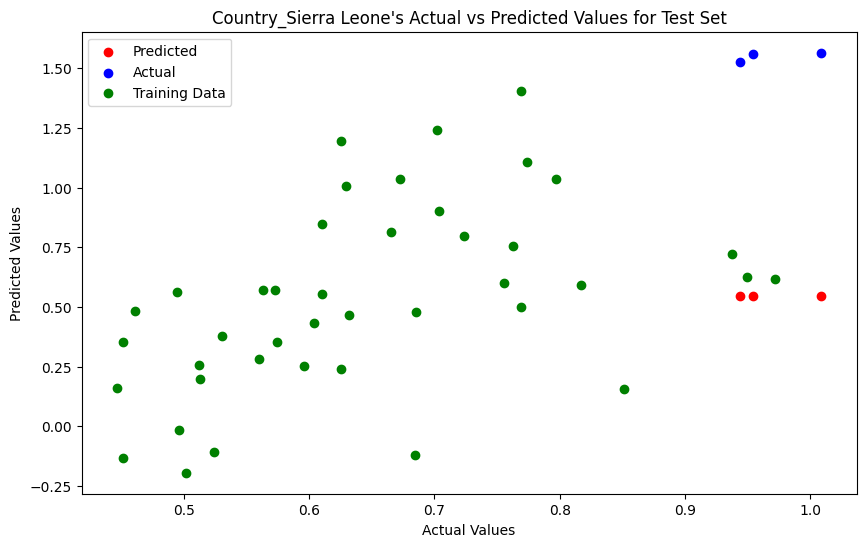

Epoch 1/100
8/8 [==============================] - 3s 81ms/step - loss: 0.0394 - mae: 0.2342 - val_loss: 0.0240 - val_mae: 0.2136
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0278 - mae: 0.1895 - val_loss: 0.0162 - val_mae: 0.1735
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0253 - mae: 0.1838 - val_loss: 0.0061 - val_mae: 0.0986
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0280 - mae: 0.1890 - val_loss: 0.0233 - val_mae: 0.2103
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0331 - mae: 0.2116 - val_loss: 0.0019 - val_mae: 0.0490
Epoch 6/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0334 - mae: 0.2148 - val_loss: 0.0012 - val_mae: 0.0481
Epoch 7/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0349 - mae: 0.2110 - val_loss: 0.0122 - val_mae: 0.1486
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0441 - mae: 0.24

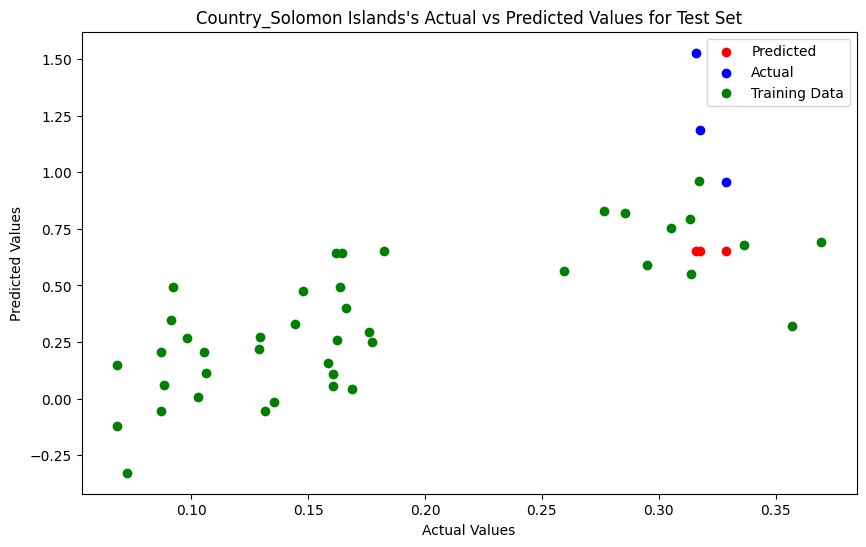

Epoch 1/100
8/8 [==============================] - 4s 78ms/step - loss: 0.0740 - mae: 0.3205 - val_loss: 0.4114 - val_mae: 0.8922
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0595 - mae: 0.2850 - val_loss: 0.1617 - val_mae: 0.5381
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0589 - mae: 0.2782 - val_loss: 0.1706 - val_mae: 0.5566
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0545 - mae: 0.2685 - val_loss: 0.3624 - val_mae: 0.8294
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0490 - mae: 0.2454 - val_loss: 0.2601 - val_mae: 0.6950
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0470 - mae: 0.2345 - val_loss: 0.2907 - val_mae: 0.7370
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0459 - mae: 0.2397 - val_loss: 0.4006 - val_mae: 0.8756
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0636 - mae: 0.27

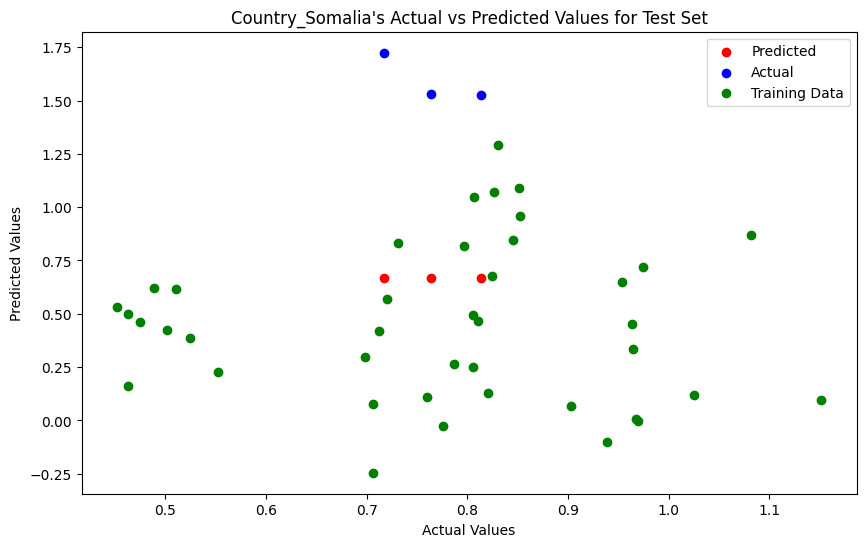

Epoch 1/100
8/8 [==============================] - 7s 93ms/step - loss: 0.0832 - mae: 0.3313 - val_loss: 0.3178 - val_mae: 0.7631
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0789 - mae: 0.3184 - val_loss: 0.2214 - val_mae: 0.6241
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0799 - mae: 0.3264 - val_loss: 0.2004 - val_mae: 0.5894
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0784 - mae: 0.3216 - val_loss: 0.2641 - val_mae: 0.6890
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0775 - mae: 0.3173 - val_loss: 0.2521 - val_mae: 0.6714
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0835 - mae: 0.3303 - val_loss: 0.1771 - val_mae: 0.5485
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0733 - mae: 0.3123 - val_loss: 0.2845 - val_mae: 0.7180
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0810 - mae: 0.32

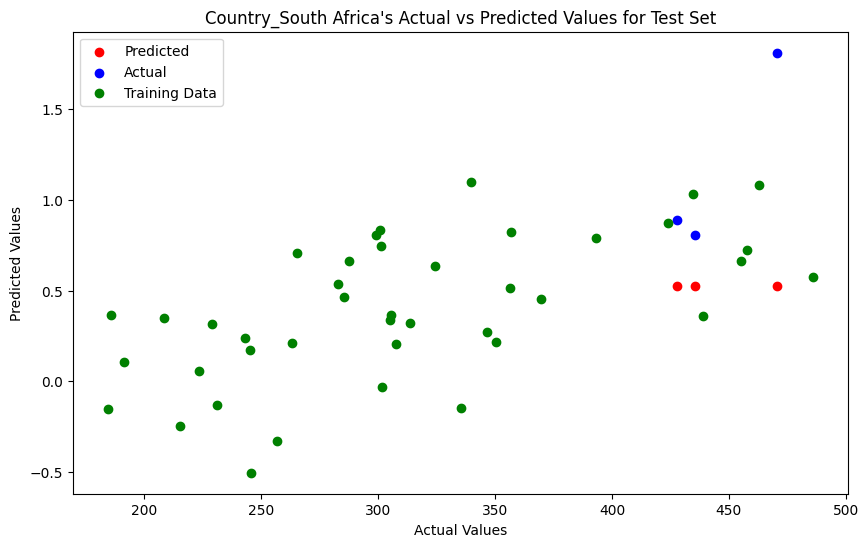

Epoch 1/100
8/8 [==============================] - 4s 82ms/step - loss: 0.0564 - mae: 0.2668 - val_loss: 0.1727 - val_mae: 0.5877
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0550 - mae: 0.2678 - val_loss: 0.2157 - val_mae: 0.6567
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0529 - mae: 0.2665 - val_loss: 0.1464 - val_mae: 0.5411
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0565 - mae: 0.2687 - val_loss: 0.1408 - val_mae: 0.5306
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0521 - mae: 0.2545 - val_loss: 0.2030 - val_mae: 0.6371
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0551 - mae: 0.2724 - val_loss: 0.1873 - val_mae: 0.6121
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0580 - mae: 0.2739 - val_loss: 0.1450 - val_mae: 0.5385
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0575 - mae: 0.27

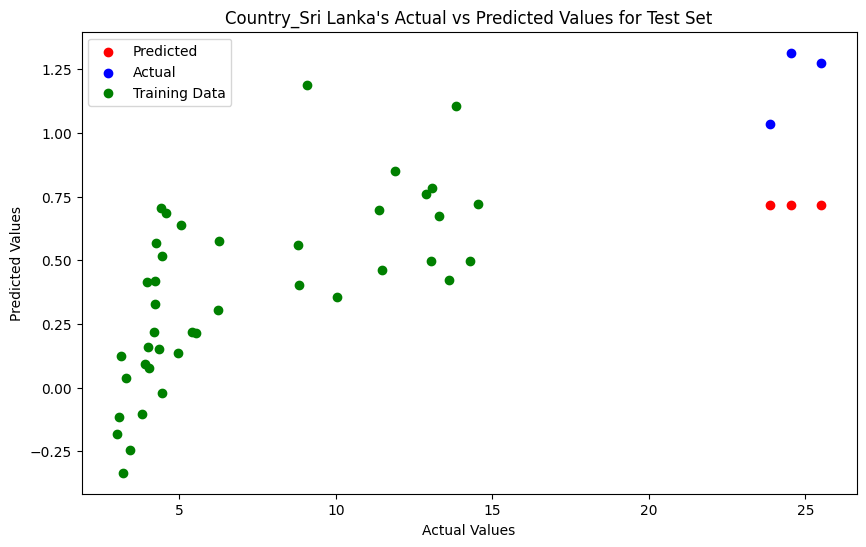

Epoch 1/100
8/8 [==============================] - 4s 81ms/step - loss: 0.0568 - mae: 0.2549 - val_loss: 0.0722 - val_mae: 0.3647
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0632 - mae: 0.2885 - val_loss: 0.0089 - val_mae: 0.1180
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0565 - mae: 0.2749 - val_loss: 0.0489 - val_mae: 0.2887
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0535 - mae: 0.2518 - val_loss: 0.0546 - val_mae: 0.3087
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0474 - mae: 0.2481 - val_loss: 0.0289 - val_mae: 0.2098
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0484 - mae: 0.2454 - val_loss: 0.0441 - val_mae: 0.2731
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0527 - mae: 0.2621 - val_loss: 0.1260 - val_mae: 0.4883
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0559 - mae: 0.26

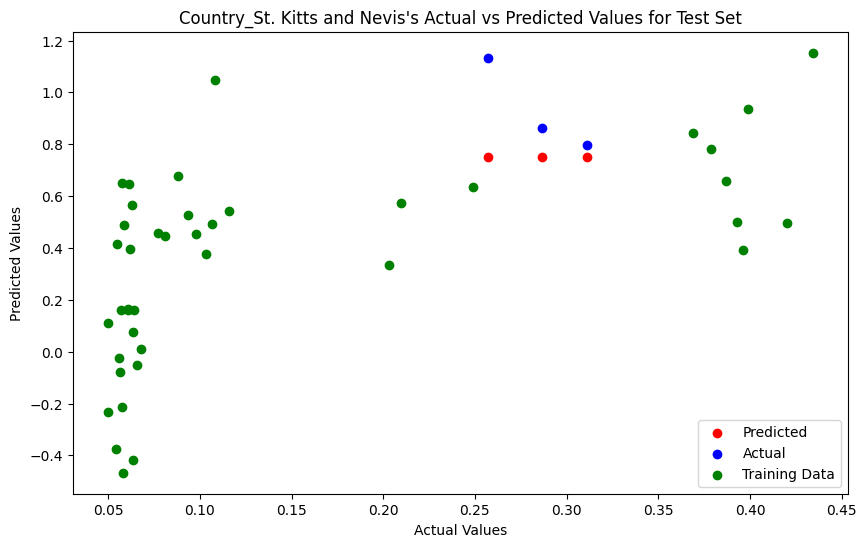

Epoch 1/100
8/8 [==============================] - 3s 76ms/step - loss: 0.0426 - mae: 0.2395 - val_loss: 0.1009 - val_mae: 0.4337
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0564 - mae: 0.2593 - val_loss: 0.0114 - val_mae: 0.1497
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0434 - mae: 0.2329 - val_loss: 0.0126 - val_mae: 0.1282
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0315 - mae: 0.1944 - val_loss: 0.0084 - val_mae: 0.1244
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0310 - mae: 0.2084 - val_loss: 0.0083 - val_mae: 0.1278
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0348 - mae: 0.2216 - val_loss: 0.0126 - val_mae: 0.1215
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0383 - mae: 0.2108 - val_loss: 0.0086 - val_mae: 0.1248
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0331 - mae: 0.19

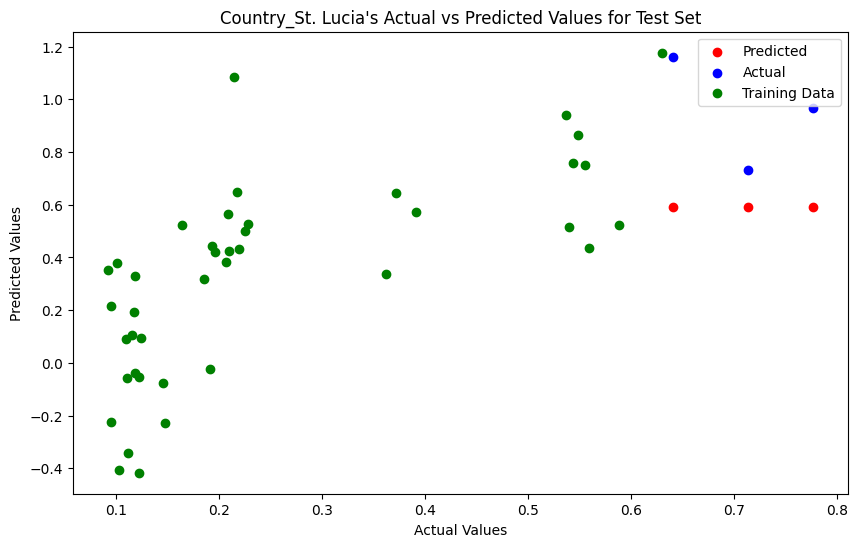

Epoch 1/100
8/8 [==============================] - 3s 106ms/step - loss: 0.1008 - mae: 0.3518 - val_loss: 0.0070 - val_mae: 0.1120
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0446 - mae: 0.2483 - val_loss: 0.0147 - val_mae: 0.1390
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0352 - mae: 0.2075 - val_loss: 0.0054 - val_mae: 0.1042
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0300 - mae: 0.2013 - val_loss: 0.0234 - val_mae: 0.1889
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0386 - mae: 0.2419 - val_loss: 0.0060 - val_mae: 0.1089
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0456 - mae: 0.2461 - val_loss: 0.0061 - val_mae: 0.1037
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0750 - mae: 0.3170 - val_loss: 0.1951 - val_mae: 0.6212
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1004 - mae: 0.3

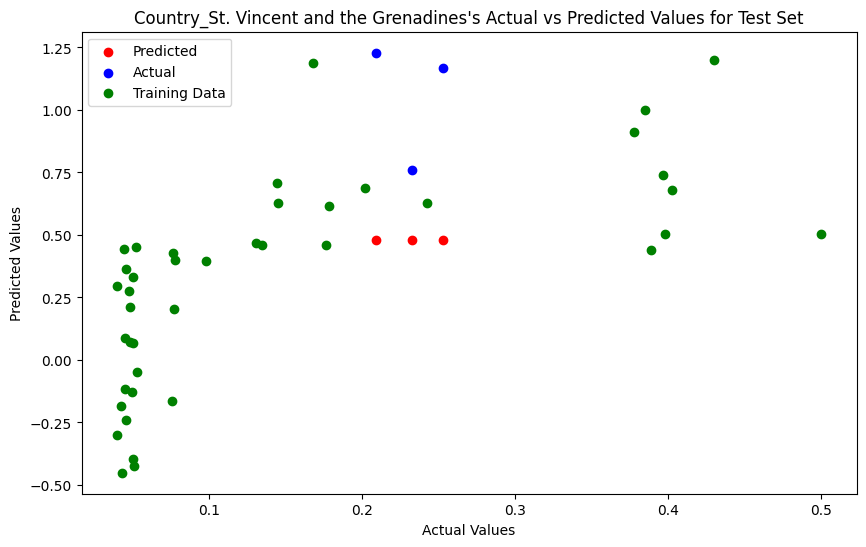

Epoch 1/100
8/8 [==============================] - 3s 82ms/step - loss: 0.1325 - mae: 0.4281 - val_loss: 0.4014 - val_mae: 0.8920
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0971 - mae: 0.3486 - val_loss: 0.6364 - val_mae: 1.1364
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1417 - mae: 0.4247 - val_loss: 0.5130 - val_mae: 1.0118
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1027 - mae: 0.3678 - val_loss: 0.6218 - val_mae: 1.1218
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1031 - mae: 0.3622 - val_loss: 0.6282 - val_mae: 1.1282
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1210 - mae: 0.4119 - val_loss: 0.2882 - val_mae: 0.7533
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1562 - mae: 0.4594 - val_loss: 0.3507 - val_mae: 0.8363
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1379 - mae: 0.42

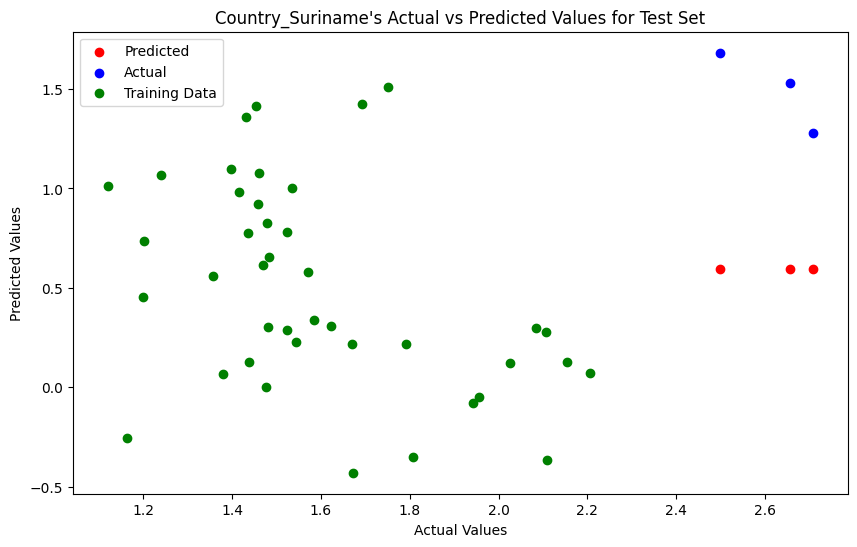

Epoch 1/100
8/8 [==============================] - 4s 81ms/step - loss: 0.4090 - mae: 0.8011 - val_loss: 0.7503 - val_mae: 1.2491
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.4602 - mae: 0.8835 - val_loss: 1.3149 - val_mae: 1.8149
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.4060 - mae: 0.7778 - val_loss: 0.9010 - val_mae: 1.4010
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.3868 - mae: 0.7646 - val_loss: 1.2409 - val_mae: 1.7409
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.3964 - mae: 0.7986 - val_loss: 1.1339 - val_mae: 1.6339
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 0.3911 - mae: 0.7767 - val_loss: 1.0262 - val_mae: 1.5262
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3935 - mae: 0.7606 - val_loss: 1.0526 - val_mae: 1.5526
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.3991 - mae: 0.79

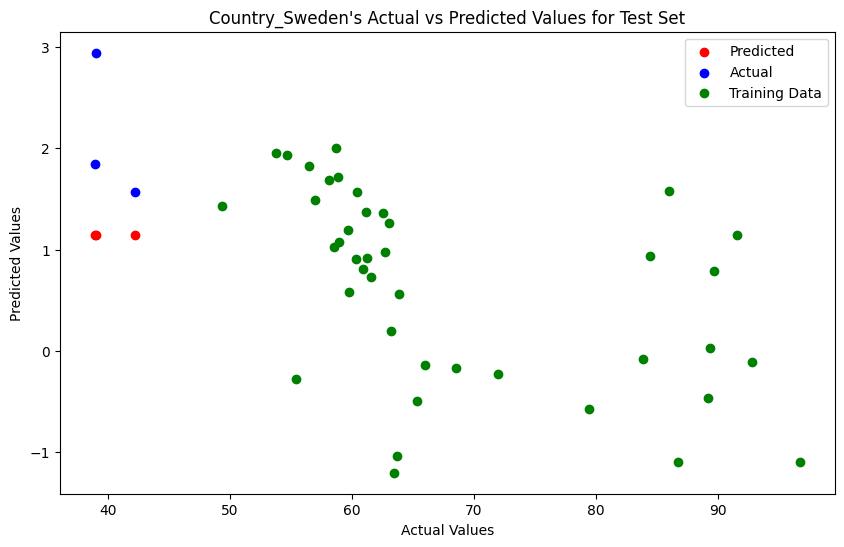

Epoch 1/100
8/8 [==============================] - 4s 83ms/step - loss: 0.0712 - mae: 0.3092 - val_loss: 0.1114 - val_mae: 0.4703
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0795 - mae: 0.3341 - val_loss: 0.0082 - val_mae: 0.1214
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1033 - mae: 0.3788 - val_loss: 0.0507 - val_mae: 0.3154
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0638 - mae: 0.2966 - val_loss: 0.0722 - val_mae: 0.3771
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0561 - mae: 0.2546 - val_loss: 0.0083 - val_mae: 0.1212
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0618 - mae: 0.2812 - val_loss: 0.0051 - val_mae: 0.0905
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0473 - mae: 0.2479 - val_loss: 0.0024 - val_mae: 0.0523
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0398 - mae: 0.23

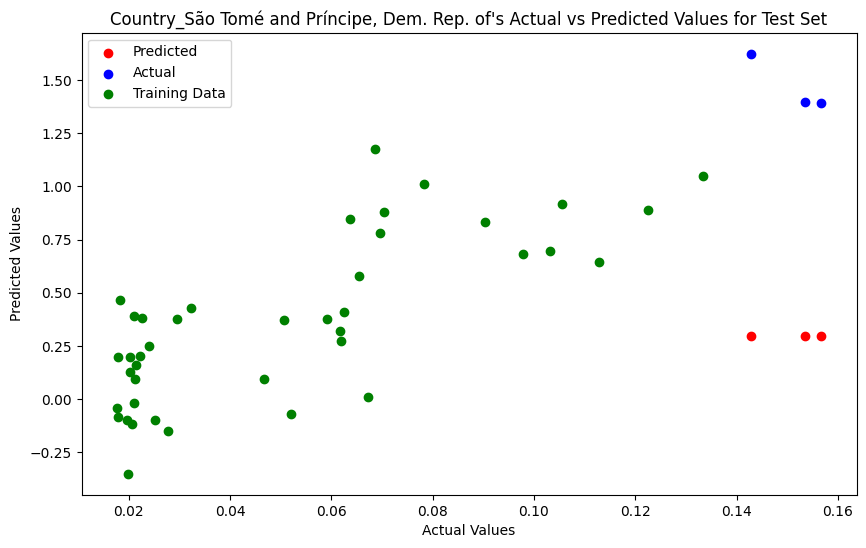

Epoch 1/100
8/8 [==============================] - 5s 128ms/step - loss: 0.0809 - mae: 0.2972 - val_loss: 0.1615 - val_mae: 0.4981
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0756 - mae: 0.2851 - val_loss: 0.2939 - val_mae: 0.7162
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0678 - mae: 0.2553 - val_loss: 0.1733 - val_mae: 0.5213
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0770 - mae: 0.2886 - val_loss: 0.2172 - val_mae: 0.5996
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0671 - mae: 0.2575 - val_loss: 0.2209 - val_mae: 0.6057
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0635 - mae: 0.2444 - val_loss: 0.1917 - val_mae: 0.5556
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0901 - mae: 0.3243 - val_loss: 0.1677 - val_mae: 0.5105
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0896 - mae: 0.3

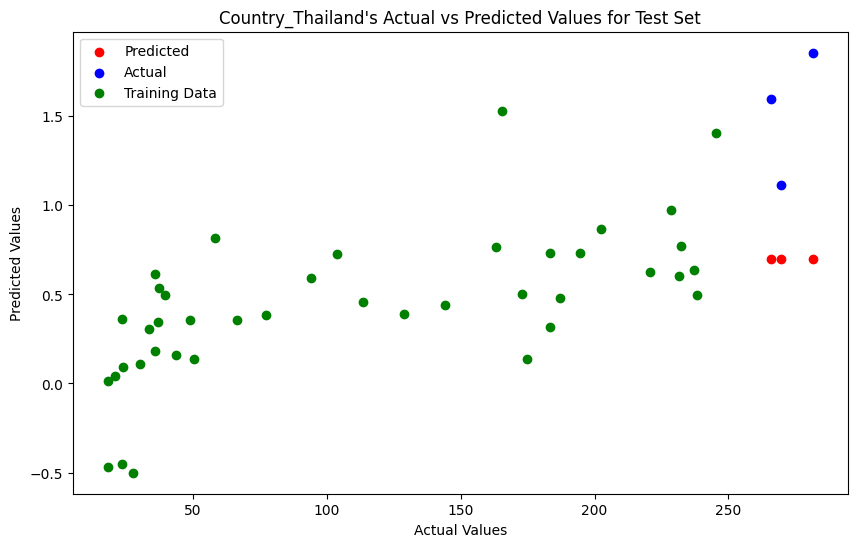

Epoch 1/100
8/8 [==============================] - 5s 136ms/step - loss: 0.0667 - mae: 0.2921 - val_loss: 0.1246 - val_mae: 0.4840
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0686 - mae: 0.3150 - val_loss: 0.0543 - val_mae: 0.3185
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0389 - mae: 0.2197 - val_loss: 0.0414 - val_mae: 0.2765
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0322 - mae: 0.2053 - val_loss: 0.0068 - val_mae: 0.0854
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0330 - mae: 0.2142 - val_loss: 0.0141 - val_mae: 0.1487
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0295 - mae: 0.1832 - val_loss: 0.0069 - val_mae: 0.0852
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0233 - mae: 0.1719 - val_loss: 0.0054 - val_mae: 0.0827
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0251 - mae: 0.1

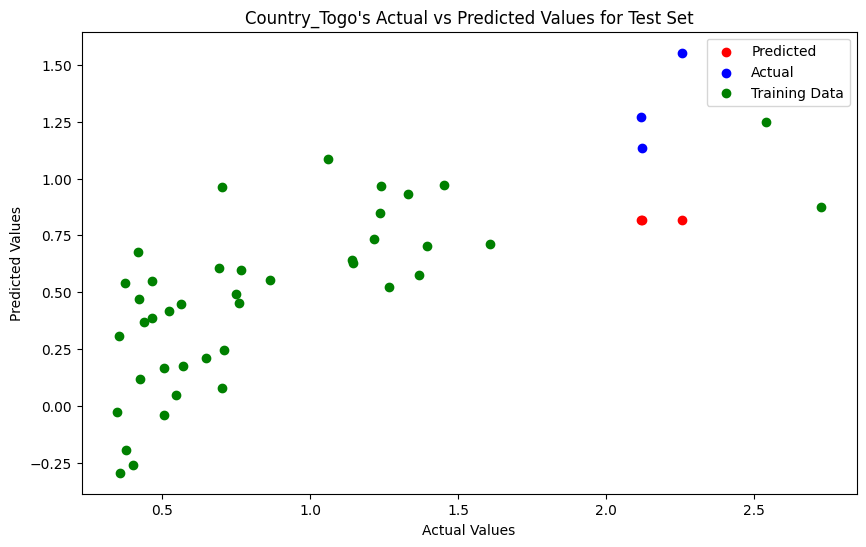

Epoch 1/100
8/8 [==============================] - 3s 80ms/step - loss: 0.0362 - mae: 0.2148 - val_loss: 0.0869 - val_mae: 0.4163
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0363 - mae: 0.2319 - val_loss: 0.1102 - val_mae: 0.4688
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0260 - mae: 0.1843 - val_loss: 0.0255 - val_mae: 0.2247
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0306 - mae: 0.1979 - val_loss: 0.0229 - val_mae: 0.2125
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0297 - mae: 0.1906 - val_loss: 0.0379 - val_mae: 0.2741
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0293 - mae: 0.1928 - val_loss: 0.0219 - val_mae: 0.2079
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0404 - mae: 0.2414 - val_loss: 0.0954 - val_mae: 0.4361
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0446 - mae: 0.22

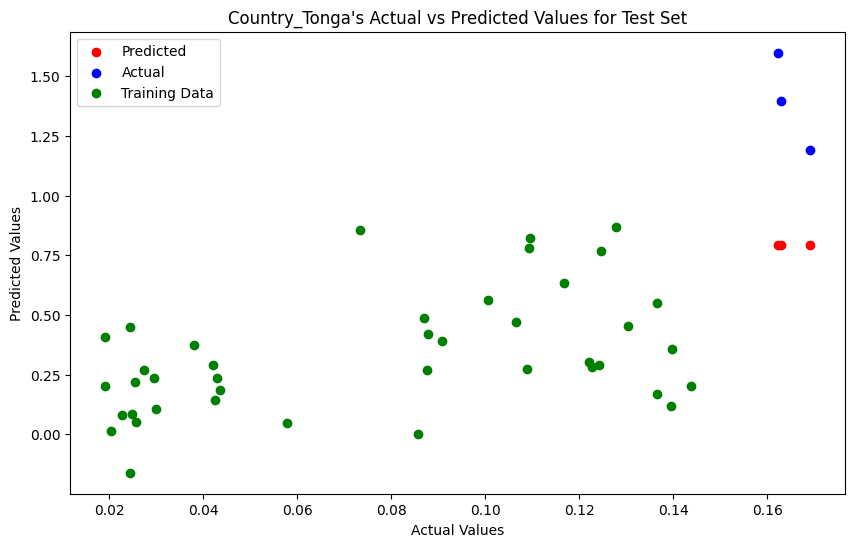

Epoch 1/100
8/8 [==============================] - 4s 84ms/step - loss: 0.1173 - mae: 0.4050 - val_loss: 0.1979 - val_mae: 0.6257
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1041 - mae: 0.3669 - val_loss: 0.0760 - val_mae: 0.3842
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0944 - mae: 0.3420 - val_loss: 0.0562 - val_mae: 0.3286
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0933 - mae: 0.3370 - val_loss: 0.1123 - val_mae: 0.4692
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0950 - mae: 0.3437 - val_loss: 0.0955 - val_mae: 0.4320
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0952 - mae: 0.3385 - val_loss: 0.0825 - val_mae: 0.4008
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 0.0931 - mae: 0.3368 - val_loss: 0.1020 - val_mae: 0.4467
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0941 - mae: 0.34

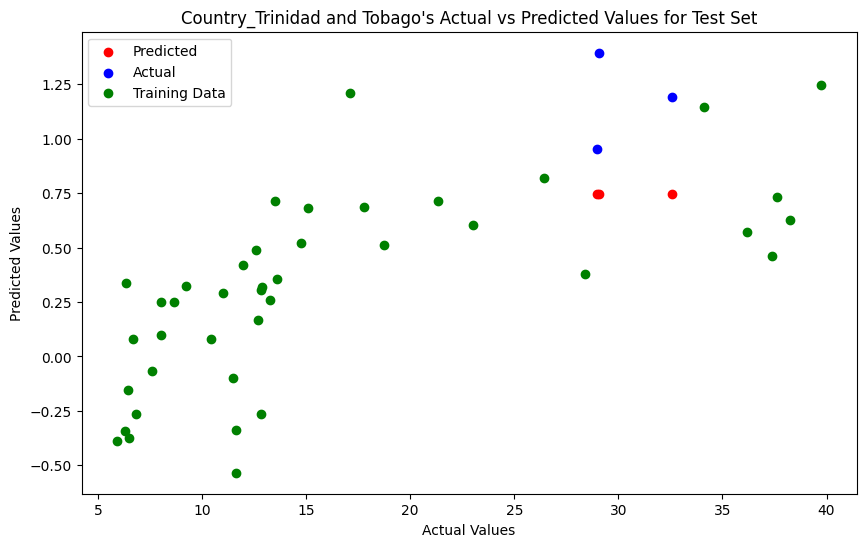

Epoch 1/100
8/8 [==============================] - 3s 81ms/step - loss: 0.1758 - mae: 0.4946 - val_loss: 0.3423 - val_mae: 0.7560
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1436 - mae: 0.4341 - val_loss: 0.1077 - val_mae: 0.3435
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1073 - mae: 0.3901 - val_loss: 0.0593 - val_mae: 0.3435
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.1482 - mae: 0.4803 - val_loss: 0.6643 - val_mae: 1.1552
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.2864 - mae: 0.6470 - val_loss: 0.2732 - val_mae: 0.6546
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 0.2404 - mae: 0.5888 - val_loss: 0.4526 - val_mae: 0.9044
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 0.1969 - mae: 0.5332 - val_loss: 0.6943 - val_mae: 1.1883
Epoch 8/100
8/8 [==============================] - 0s 28ms/step - loss: 0.3180 - mae: 0.67

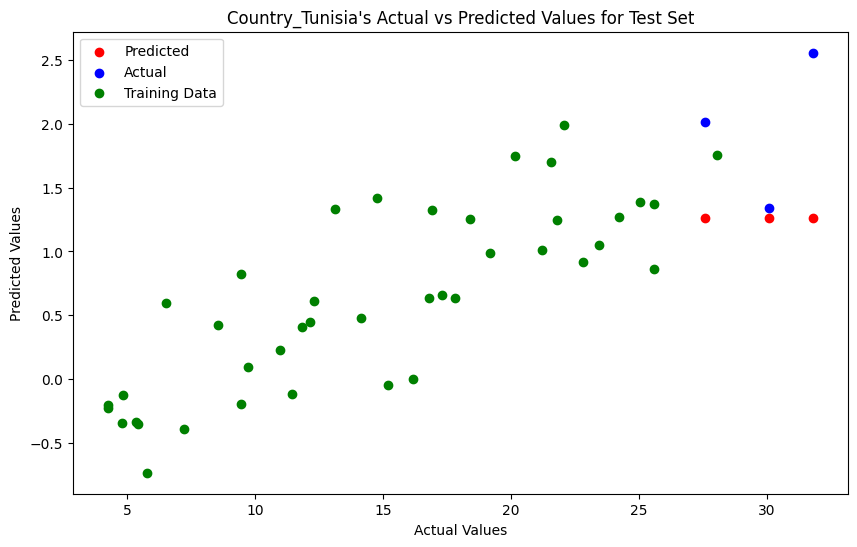

Epoch 1/100
8/8 [==============================] - 4s 147ms/step - loss: 0.0977 - mae: 0.3756 - val_loss: 0.2961 - val_mae: 0.7622
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0859 - mae: 0.3374 - val_loss: 0.0054 - val_mae: 0.1032
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0852 - mae: 0.3514 - val_loss: 0.1217 - val_mae: 0.4820
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0777 - mae: 0.3284 - val_loss: 0.0852 - val_mae: 0.3985
Epoch 5/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0593 - mae: 0.2762 - val_loss: 0.0537 - val_mae: 0.3095
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0611 - mae: 0.2802 - val_loss: 0.0668 - val_mae: 0.3492
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1001 - mae: 0.3638 - val_loss: 0.1112 - val_mae: 0.4589
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0974 - mae: 0.3

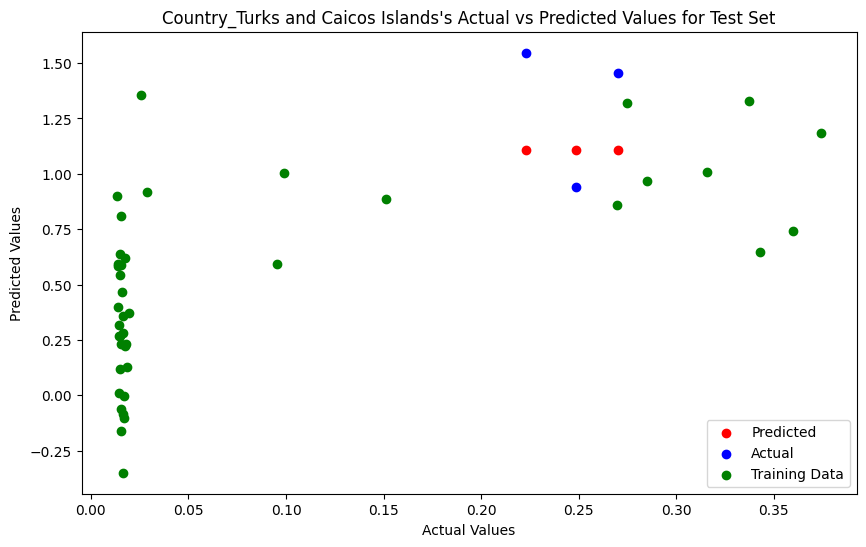

Epoch 1/100
8/8 [==============================] - 4s 116ms/step - loss: 0.1363 - mae: 0.4351 - val_loss: 0.1867 - val_mae: 0.6109
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0710 - mae: 0.3124 - val_loss: 0.0016 - val_mae: 0.0559
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0374 - mae: 0.2287 - val_loss: 0.0698 - val_mae: 0.3735
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0348 - mae: 0.2117 - val_loss: 0.0109 - val_mae: 0.1470
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0360 - mae: 0.2188 - val_loss: 0.0069 - val_mae: 0.1165
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0262 - mae: 0.1895 - val_loss: 0.0450 - val_mae: 0.2999
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0294 - mae: 0.1907 - val_loss: 0.0077 - val_mae: 0.1239
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0303 - mae: 0.1

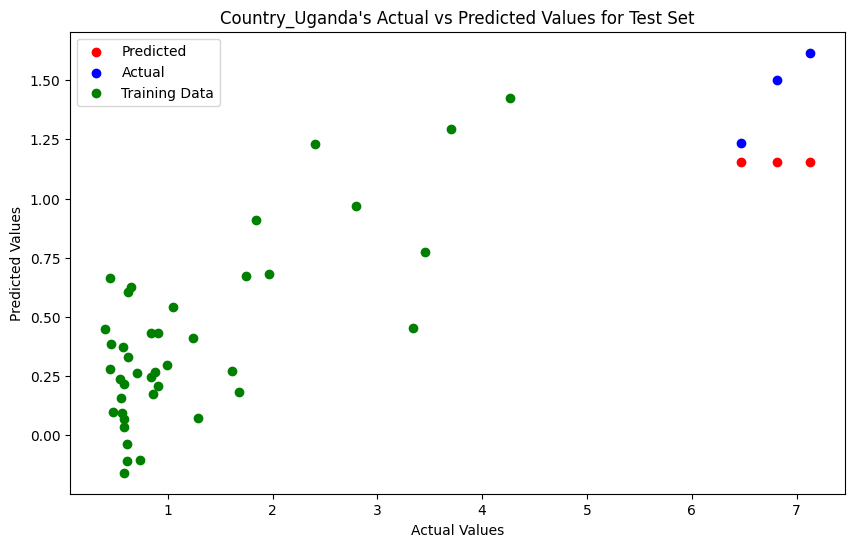

Epoch 1/100
8/8 [==============================] - 4s 124ms/step - loss: 0.3127 - mae: 0.6412 - val_loss: 0.4543 - val_mae: 0.9120
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.2442 - mae: 0.5822 - val_loss: 0.4846 - val_mae: 0.9496
Epoch 3/100
8/8 [==============================] - 0s 31ms/step - loss: 0.2027 - mae: 0.5481 - val_loss: 0.5842 - val_mae: 1.0679
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1934 - mae: 0.5336 - val_loss: 0.4725 - val_mae: 0.9348
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1915 - mae: 0.5178 - val_loss: 0.4531 - val_mae: 0.9105
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1811 - mae: 0.5059 - val_loss: 0.4493 - val_mae: 0.9057
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1867 - mae: 0.5155 - val_loss: 0.5217 - val_mae: 0.9947
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1964 - mae: 0.5

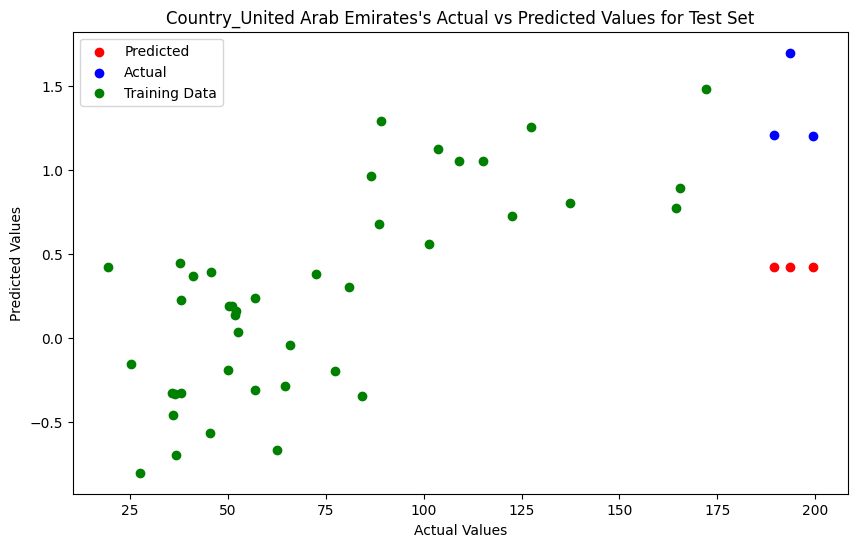

Epoch 1/100
8/8 [==============================] - 5s 146ms/step - loss: 0.1636 - mae: 0.4948 - val_loss: 0.3511 - val_mae: 0.6458
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 0.1693 - mae: 0.5055 - val_loss: 0.3972 - val_mae: 0.7272
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1667 - mae: 0.5006 - val_loss: 0.3256 - val_mae: 0.5981
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 0.1668 - mae: 0.5003 - val_loss: 0.4265 - val_mae: 0.7759
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1682 - mae: 0.5064 - val_loss: 0.3395 - val_mae: 0.6244
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1728 - mae: 0.5052 - val_loss: 0.3966 - val_mae: 0.7260
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1828 - mae: 0.5231 - val_loss: 0.3307 - val_mae: 0.6079
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1839 - mae: 0.5

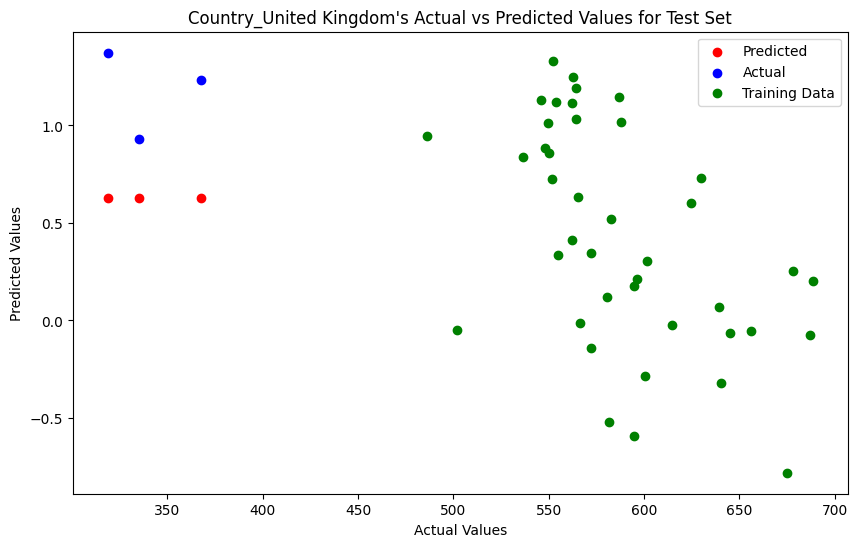

Epoch 1/100
8/8 [==============================] - 4s 116ms/step - loss: 0.1061 - mae: 0.3796 - val_loss: 0.3165 - val_mae: 0.6131
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1118 - mae: 0.3953 - val_loss: 0.3155 - val_mae: 0.6113
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 0.1003 - mae: 0.3684 - val_loss: 0.2099 - val_mae: 0.5150
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1084 - mae: 0.3897 - val_loss: 0.3195 - val_mae: 0.6186
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1077 - mae: 0.3889 - val_loss: 0.2804 - val_mae: 0.5453
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1044 - mae: 0.3780 - val_loss: 0.2681 - val_mae: 0.5212
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1088 - mae: 0.3856 - val_loss: 0.3131 - val_mae: 0.6069
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1108 - mae: 0.3

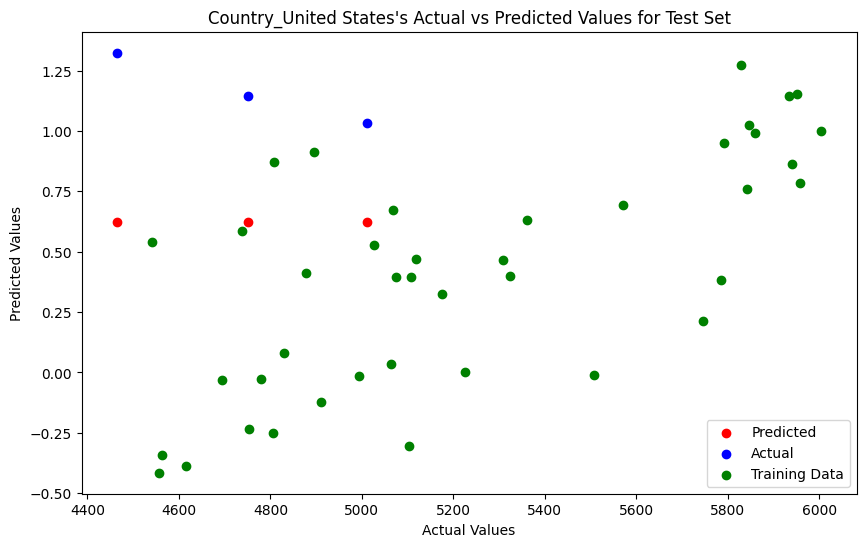

Epoch 1/100
8/8 [==============================] - 4s 111ms/step - loss: 0.0754 - mae: 0.3064 - val_loss: 0.3817 - val_mae: 0.8719
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0737 - mae: 0.2937 - val_loss: 0.2518 - val_mae: 0.7074
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0702 - mae: 0.2881 - val_loss: 0.2235 - val_mae: 0.6662
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0747 - mae: 0.3066 - val_loss: 0.3707 - val_mae: 0.8591
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0893 - mae: 0.3378 - val_loss: 0.2224 - val_mae: 0.6645
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0701 - mae: 0.3058 - val_loss: 0.3776 - val_mae: 0.8672
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0666 - mae: 0.2927 - val_loss: 0.1982 - val_mae: 0.6271
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0638 - mae: 0.2

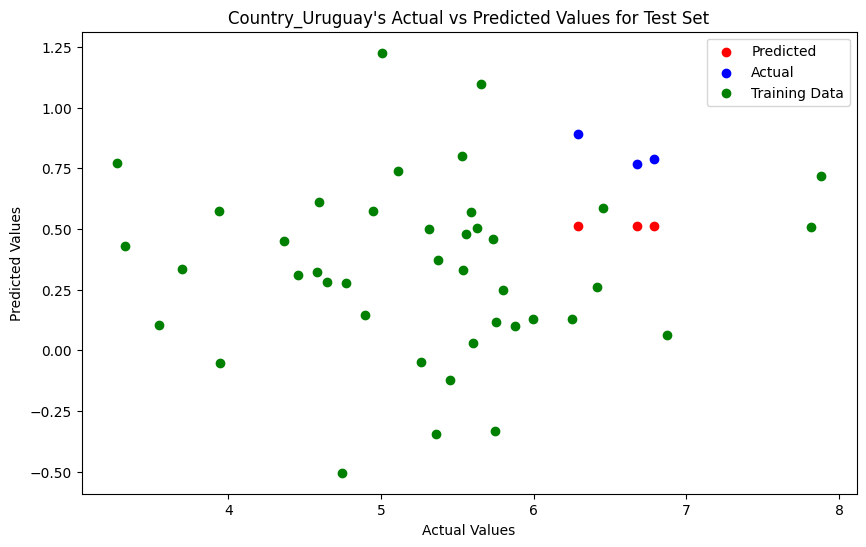

Epoch 1/100
8/8 [==============================] - 4s 109ms/step - loss: 0.0942 - mae: 0.3561 - val_loss: 0.0695 - val_mae: 0.3727
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0712 - mae: 0.3119 - val_loss: 0.0330 - val_mae: 0.2569
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0525 - mae: 0.2569 - val_loss: 0.0599 - val_mae: 0.3460
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0496 - mae: 0.2622 - val_loss: 0.0583 - val_mae: 0.3412
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0512 - mae: 0.2501 - val_loss: 0.0528 - val_mae: 0.3247
Epoch 6/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0436 - mae: 0.2483 - val_loss: 0.0613 - val_mae: 0.3499
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0417 - mae: 0.2442 - val_loss: 0.1032 - val_mae: 0.4541
Epoch 8/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0547 - mae: 0.2

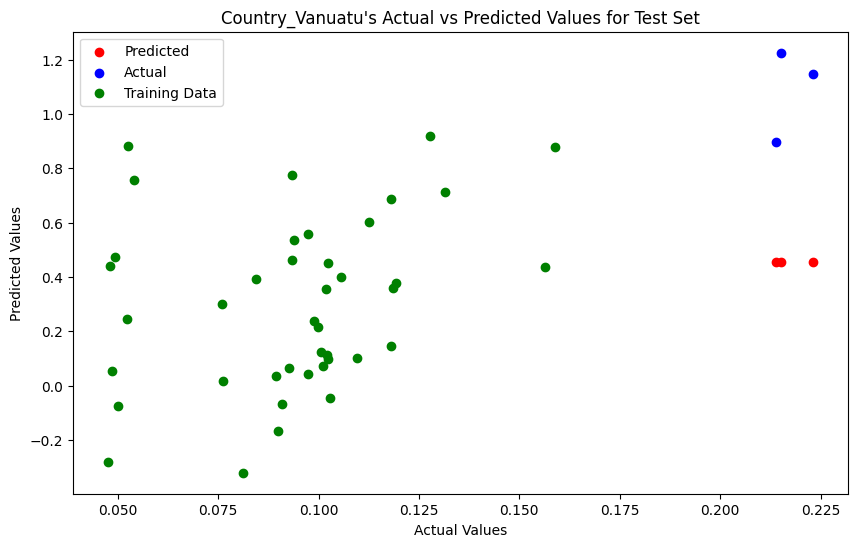

Epoch 1/100
8/8 [==============================] - 5s 113ms/step - loss: 0.0841 - mae: 0.3269 - val_loss: 0.1944 - val_mae: 0.5220
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0894 - mae: 0.3360 - val_loss: 0.1909 - val_mae: 0.5153
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0780 - mae: 0.3101 - val_loss: 0.1234 - val_mae: 0.3612
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0879 - mae: 0.3319 - val_loss: 0.2035 - val_mae: 0.5391
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0740 - mae: 0.2987 - val_loss: 0.1226 - val_mae: 0.3590
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0688 - mae: 0.3063 - val_loss: 0.1661 - val_mae: 0.4647
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0628 - mae: 0.2676 - val_loss: 0.0582 - val_mae: 0.3410
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0703 - mae: 0.2

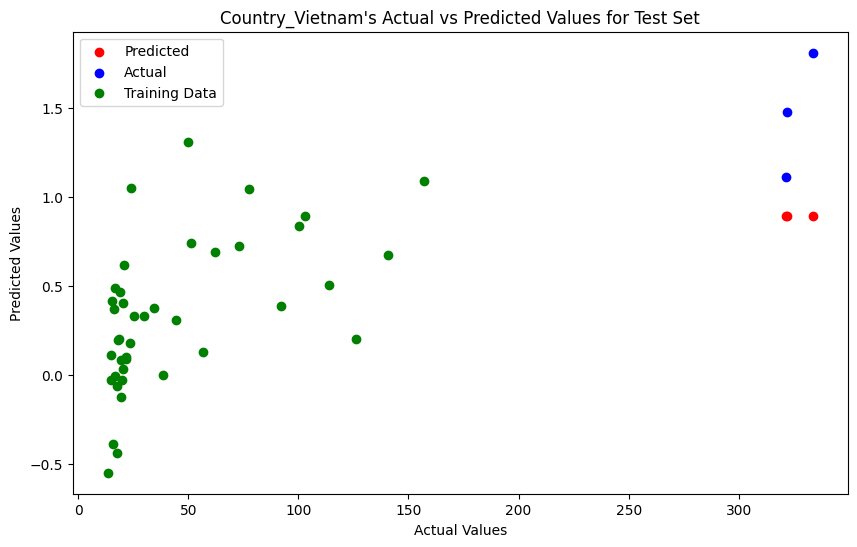

Epoch 1/100
8/8 [==============================] - 4s 125ms/step - loss: 0.2606 - mae: 0.6063 - val_loss: 0.2302 - val_mae: 0.6764
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 0.1733 - mae: 0.4859 - val_loss: 0.1104 - val_mae: 0.4667
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.1199 - mae: 0.4002 - val_loss: 0.0301 - val_mae: 0.2396
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0884 - mae: 0.3344 - val_loss: 0.0035 - val_mae: 0.0644
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0953 - mae: 0.3242 - val_loss: 0.0651 - val_mae: 0.3568
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0926 - mae: 0.3390 - val_loss: 0.0117 - val_mae: 0.1434
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0750 - mae: 0.3029 - val_loss: 0.0105 - val_mae: 0.1343
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0839 - mae: 0.3

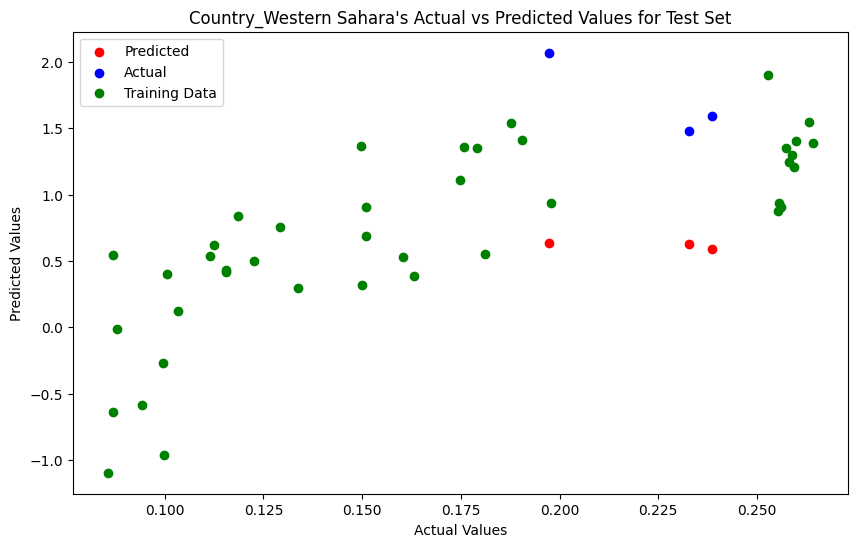

Epoch 1/100
8/8 [==============================] - 4s 114ms/step - loss: 0.0782 - mae: 0.3281 - val_loss: 0.4222 - val_mae: 0.8855
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1327 - mae: 0.4636 - val_loss: 0.7135 - val_mae: 1.2126
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0796 - mae: 0.3330 - val_loss: 0.2147 - val_mae: 0.5942
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0893 - mae: 0.3369 - val_loss: 0.4412 - val_mae: 0.9075
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0726 - mae: 0.3077 - val_loss: 0.3686 - val_mae: 0.8142
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0658 - mae: 0.2938 - val_loss: 0.4568 - val_mae: 0.9235
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0747 - mae: 0.3129 - val_loss: 0.5132 - val_mae: 0.9911
Epoch 8/100
8/8 [==============================] - 0s 34ms/step - loss: 0.0823 - mae: 0.3

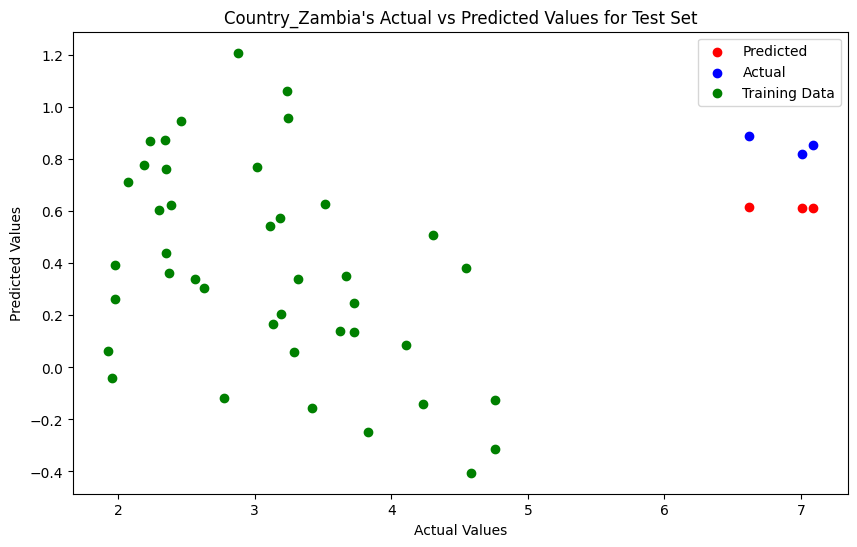

Epoch 1/100
8/8 [==============================] - 4s 110ms/step - loss: 0.1138 - mae: 0.3924 - val_loss: 0.2438 - val_mae: 0.5142
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1200 - mae: 0.3994 - val_loss: 0.1290 - val_mae: 0.4725
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1166 - mae: 0.3748 - val_loss: 0.1594 - val_mae: 0.4725
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 0.1044 - mae: 0.3853 - val_loss: 0.1269 - val_mae: 0.4725
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1124 - mae: 0.3900 - val_loss: 0.1750 - val_mae: 0.4725
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1268 - mae: 0.4270 - val_loss: 0.1351 - val_mae: 0.4725
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0994 - mae: 0.3586 - val_loss: 0.1872 - val_mae: 0.4725
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1078 - mae: 0.3

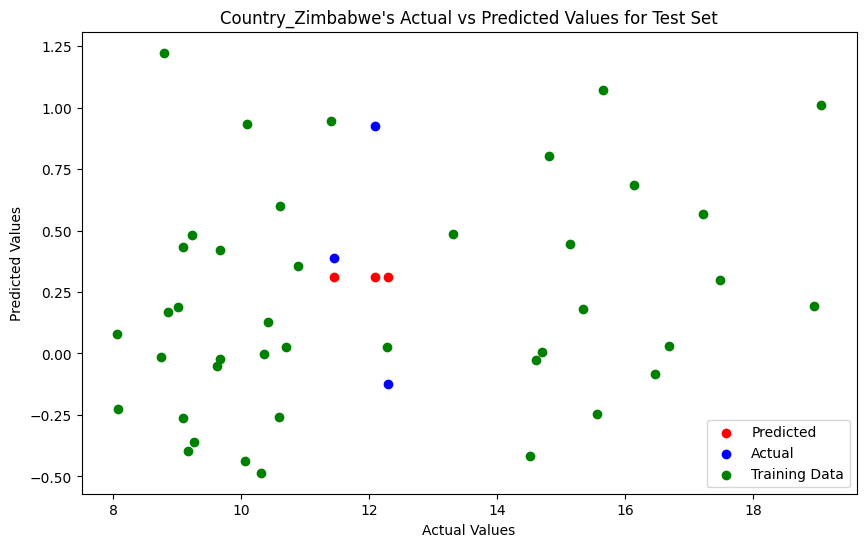

In [14]:
for country in df.columns[3:]:

  if df[country].sum() == 52:

    country_data = df[df[country] == 1][['Year', 'Temperature', 'Co2']]

    X = country_data[['Co2']].values
    y = country_data['Temperature'].values

    split_index = int(len(X) * 0.8)

    X_train, X_val_test = X[:split_index], X[split_index:]
    y_train, y_val_test = y[:split_index], y[split_index:]


    split_index_val = int(len(X_val_test) * 0.5)

    X_val, X_test = X_val_test[:split_index_val], X_val_test[split_index_val:]
    y_val, y_test = y_val_test[:split_index_val], y_val_test[split_index_val:]


    seq_length = 3
    tf.random.set_seed(42)

    train_ds = tf.keras.utils.timeseries_dataset_from_array(
        X_train,
        targets = y_train[seq_length:],
        sequence_length= seq_length,
        batch_size = 5,
        shuffle = True,
        seed = 42
    )

    valid_ds = tf.keras.utils.timeseries_dataset_from_array(
        X_val,
        targets= y_val[seq_length:],
        sequence_length = seq_length,
        batch_size = 32
    )

    model = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

    test_predictions = deep_model.predict(test_ds)

    plt.figure(figsize=(10, 6))

    plt.scatter(X_test[seq_length:], test_predictions, color='red', label='Predicted')
    plt.scatter(X_test[seq_length:], y_test[seq_length:], color='blue', label='Actual')
    plt.scatter(X_train, y_train, label='Training Data', color='green')

    plt.title(f"{country}'s Actual vs Predicted Values for Test Set")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()